# Importing

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


KeyboardInterrupt: 

# Datasets Preparation

In [ ]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [ ]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [ ]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [ ]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [ ]:
def plotting (depth, clusters, unique, sil, flag, diat):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(2,2, figsize=(10, 15))

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.15)

    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    cmap = plt.get_cmap('Accent')
    cmap.set_bad('gray')
    sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    flag[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
    diat[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Silicones')
    ax[1,0].title.set_text('Flaggelates')
    ax[1,1].title.set_text('Diatoms')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters,' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 26737 

The minimum temperature for cluster 0 is 6.81 degrees Celsius
The maximum temperature for cluster 0 is 9.73 degrees Celsius
The mean temperature for cluster 0 is 8.0 degrees Celsius 

The minimum salinity for cluster 0 is 28.84 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.34 g/kg 


The amount of grid boxes for cluster 1 is 9995 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 10.4 degrees Celsius
The mean temperature for cluster 1 is 8.96 degrees Celsius 

The minimum salinity for cluster 1 is 24.84 g/kg
The maximum salinity for cluster 1 is 27.22 g/kg
The mean salinity for cluster 1 is 25.82 g/kg 


The amount of grid boxes for cluster 2 is 10423 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 11.04 degrees Celsius
The mean temperature for cluster 2 is 9.01 degrees Celsius 

Th

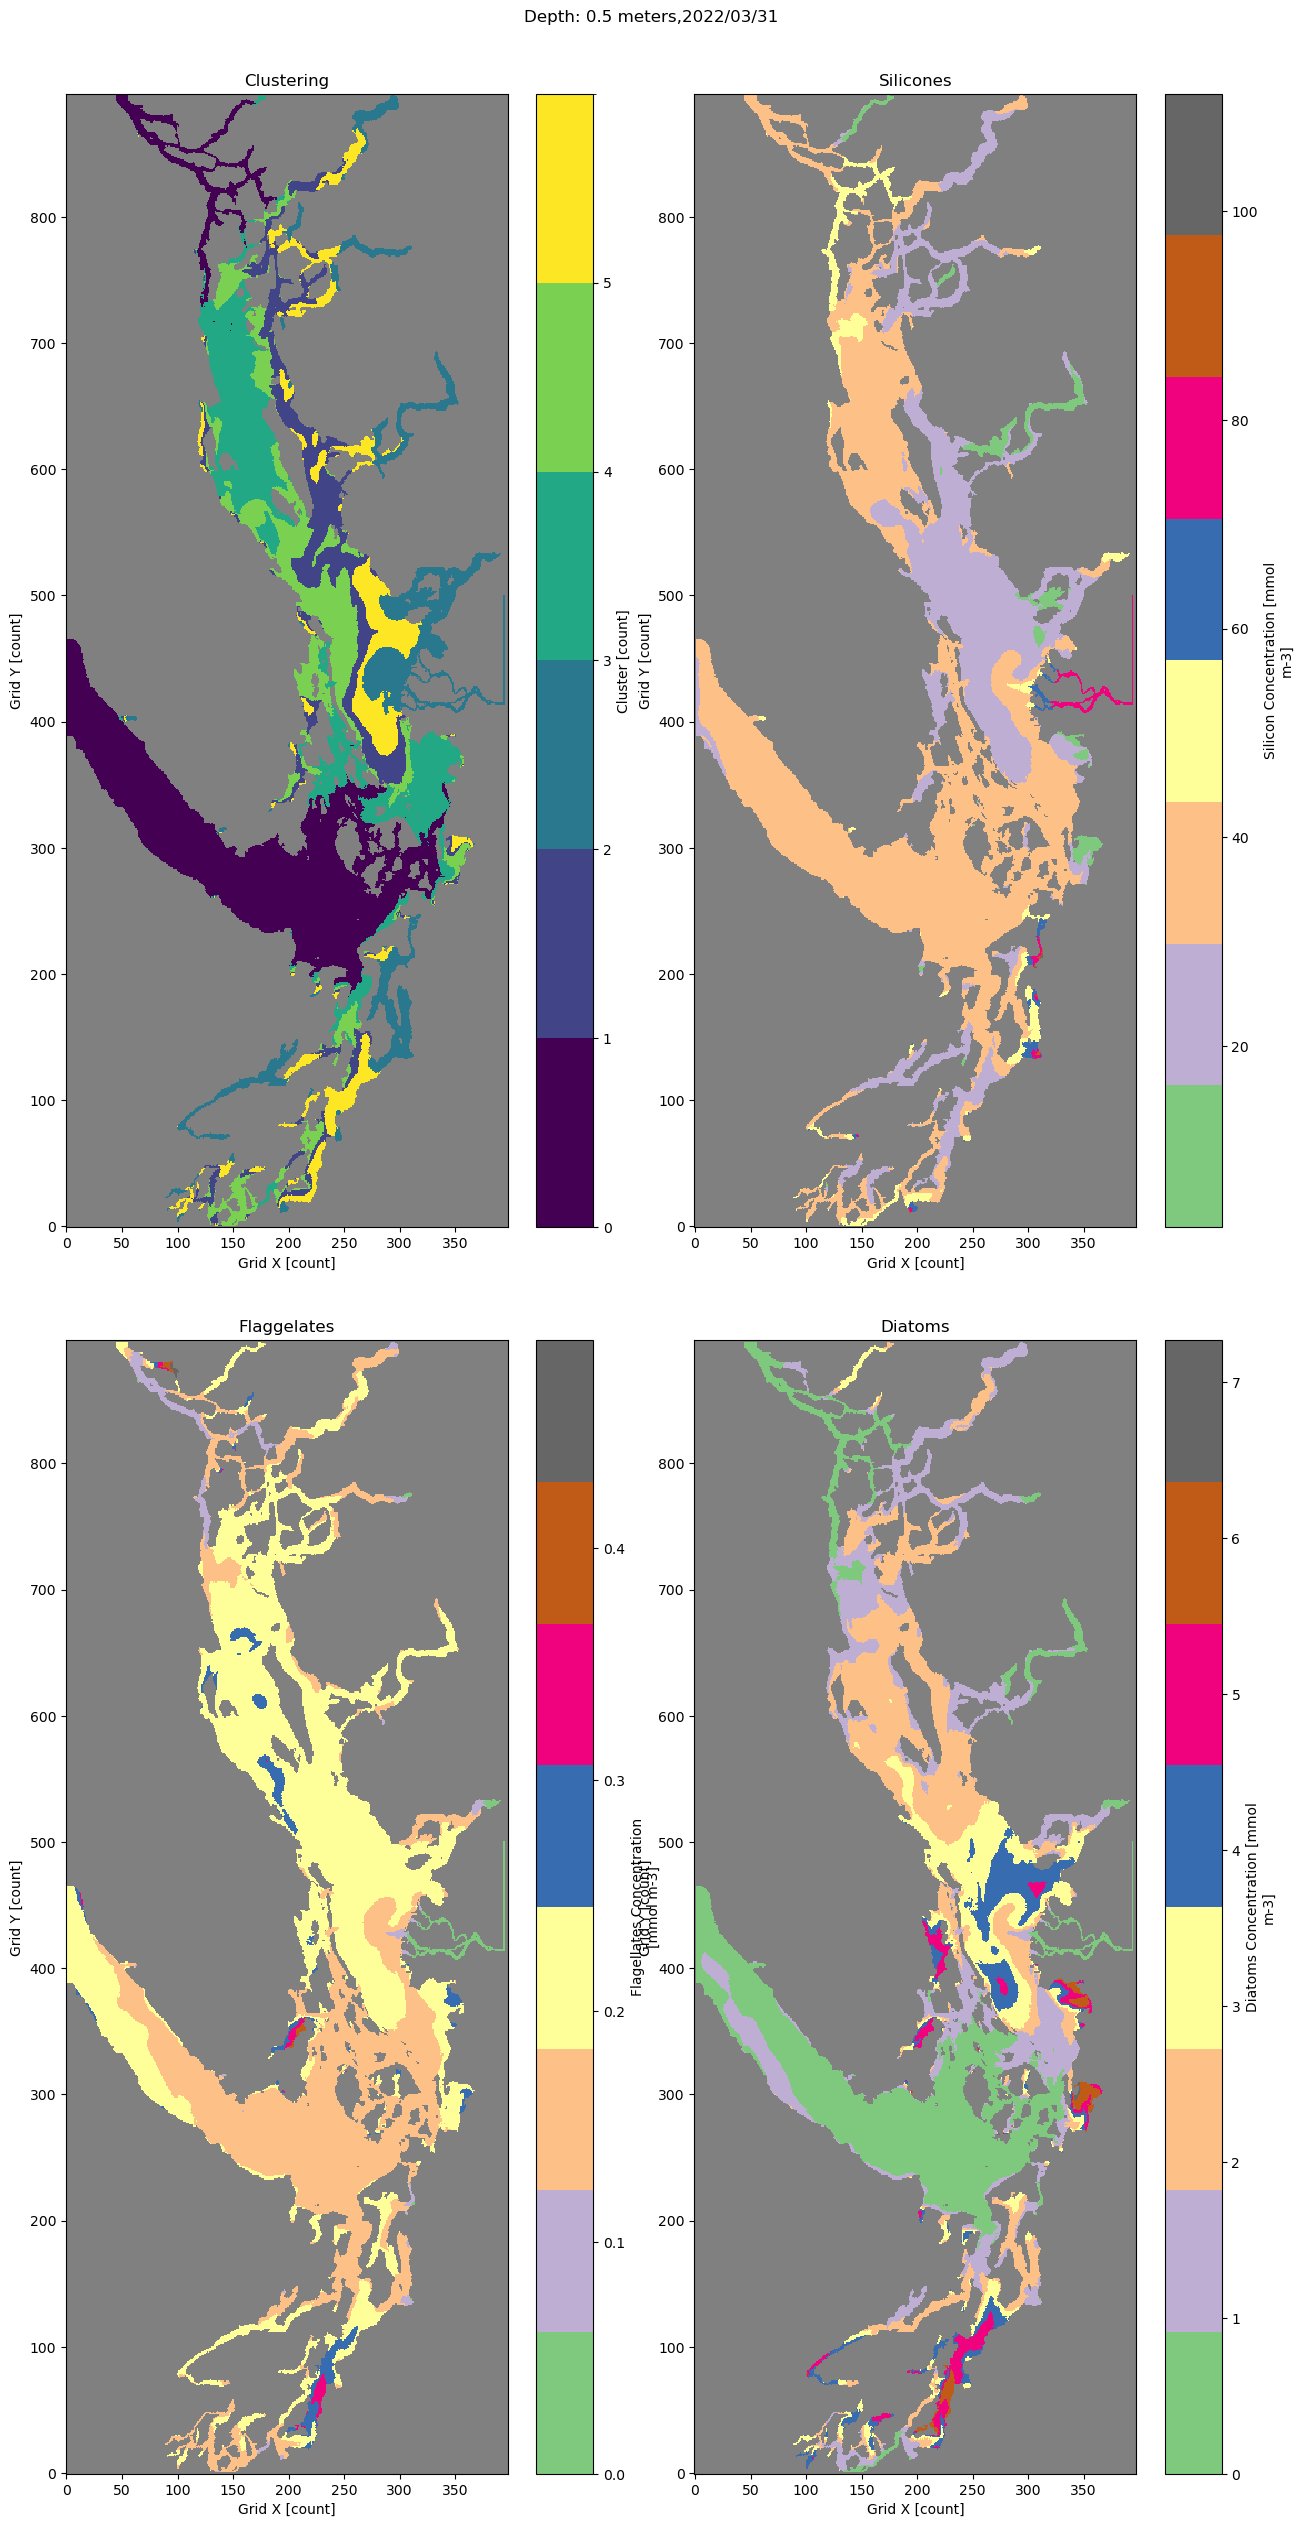

The amount of grid boxes for cluster 0 is 15090 

The minimum temperature for cluster 0 is 7.49 degrees Celsius
The maximum temperature for cluster 0 is 10.0 degrees Celsius
The mean temperature for cluster 0 is 8.53 degrees Celsius 

The minimum salinity for cluster 0 is 27.68 g/kg
The maximum salinity for cluster 0 is 29.27 g/kg
The mean salinity for cluster 0 is 28.37 g/kg 


The amount of grid boxes for cluster 1 is 13442 

The minimum temperature for cluster 1 is 8.16 degrees Celsius
The maximum temperature for cluster 1 is 10.49 degrees Celsius
The mean temperature for cluster 1 is 8.97 degrees Celsius 

The minimum salinity for cluster 1 is 25.27 g/kg
The maximum salinity for cluster 1 is 27.89 g/kg
The mean salinity for cluster 1 is 26.84 g/kg 


The amount of grid boxes for cluster 2 is 7628 

The minimum temperature for cluster 2 is 7.26 degrees Celsius
The maximum temperature for cluster 2 is 10.54 degrees Celsius
The mean temperature for cluster 2 is 9.16 degrees Celsius 



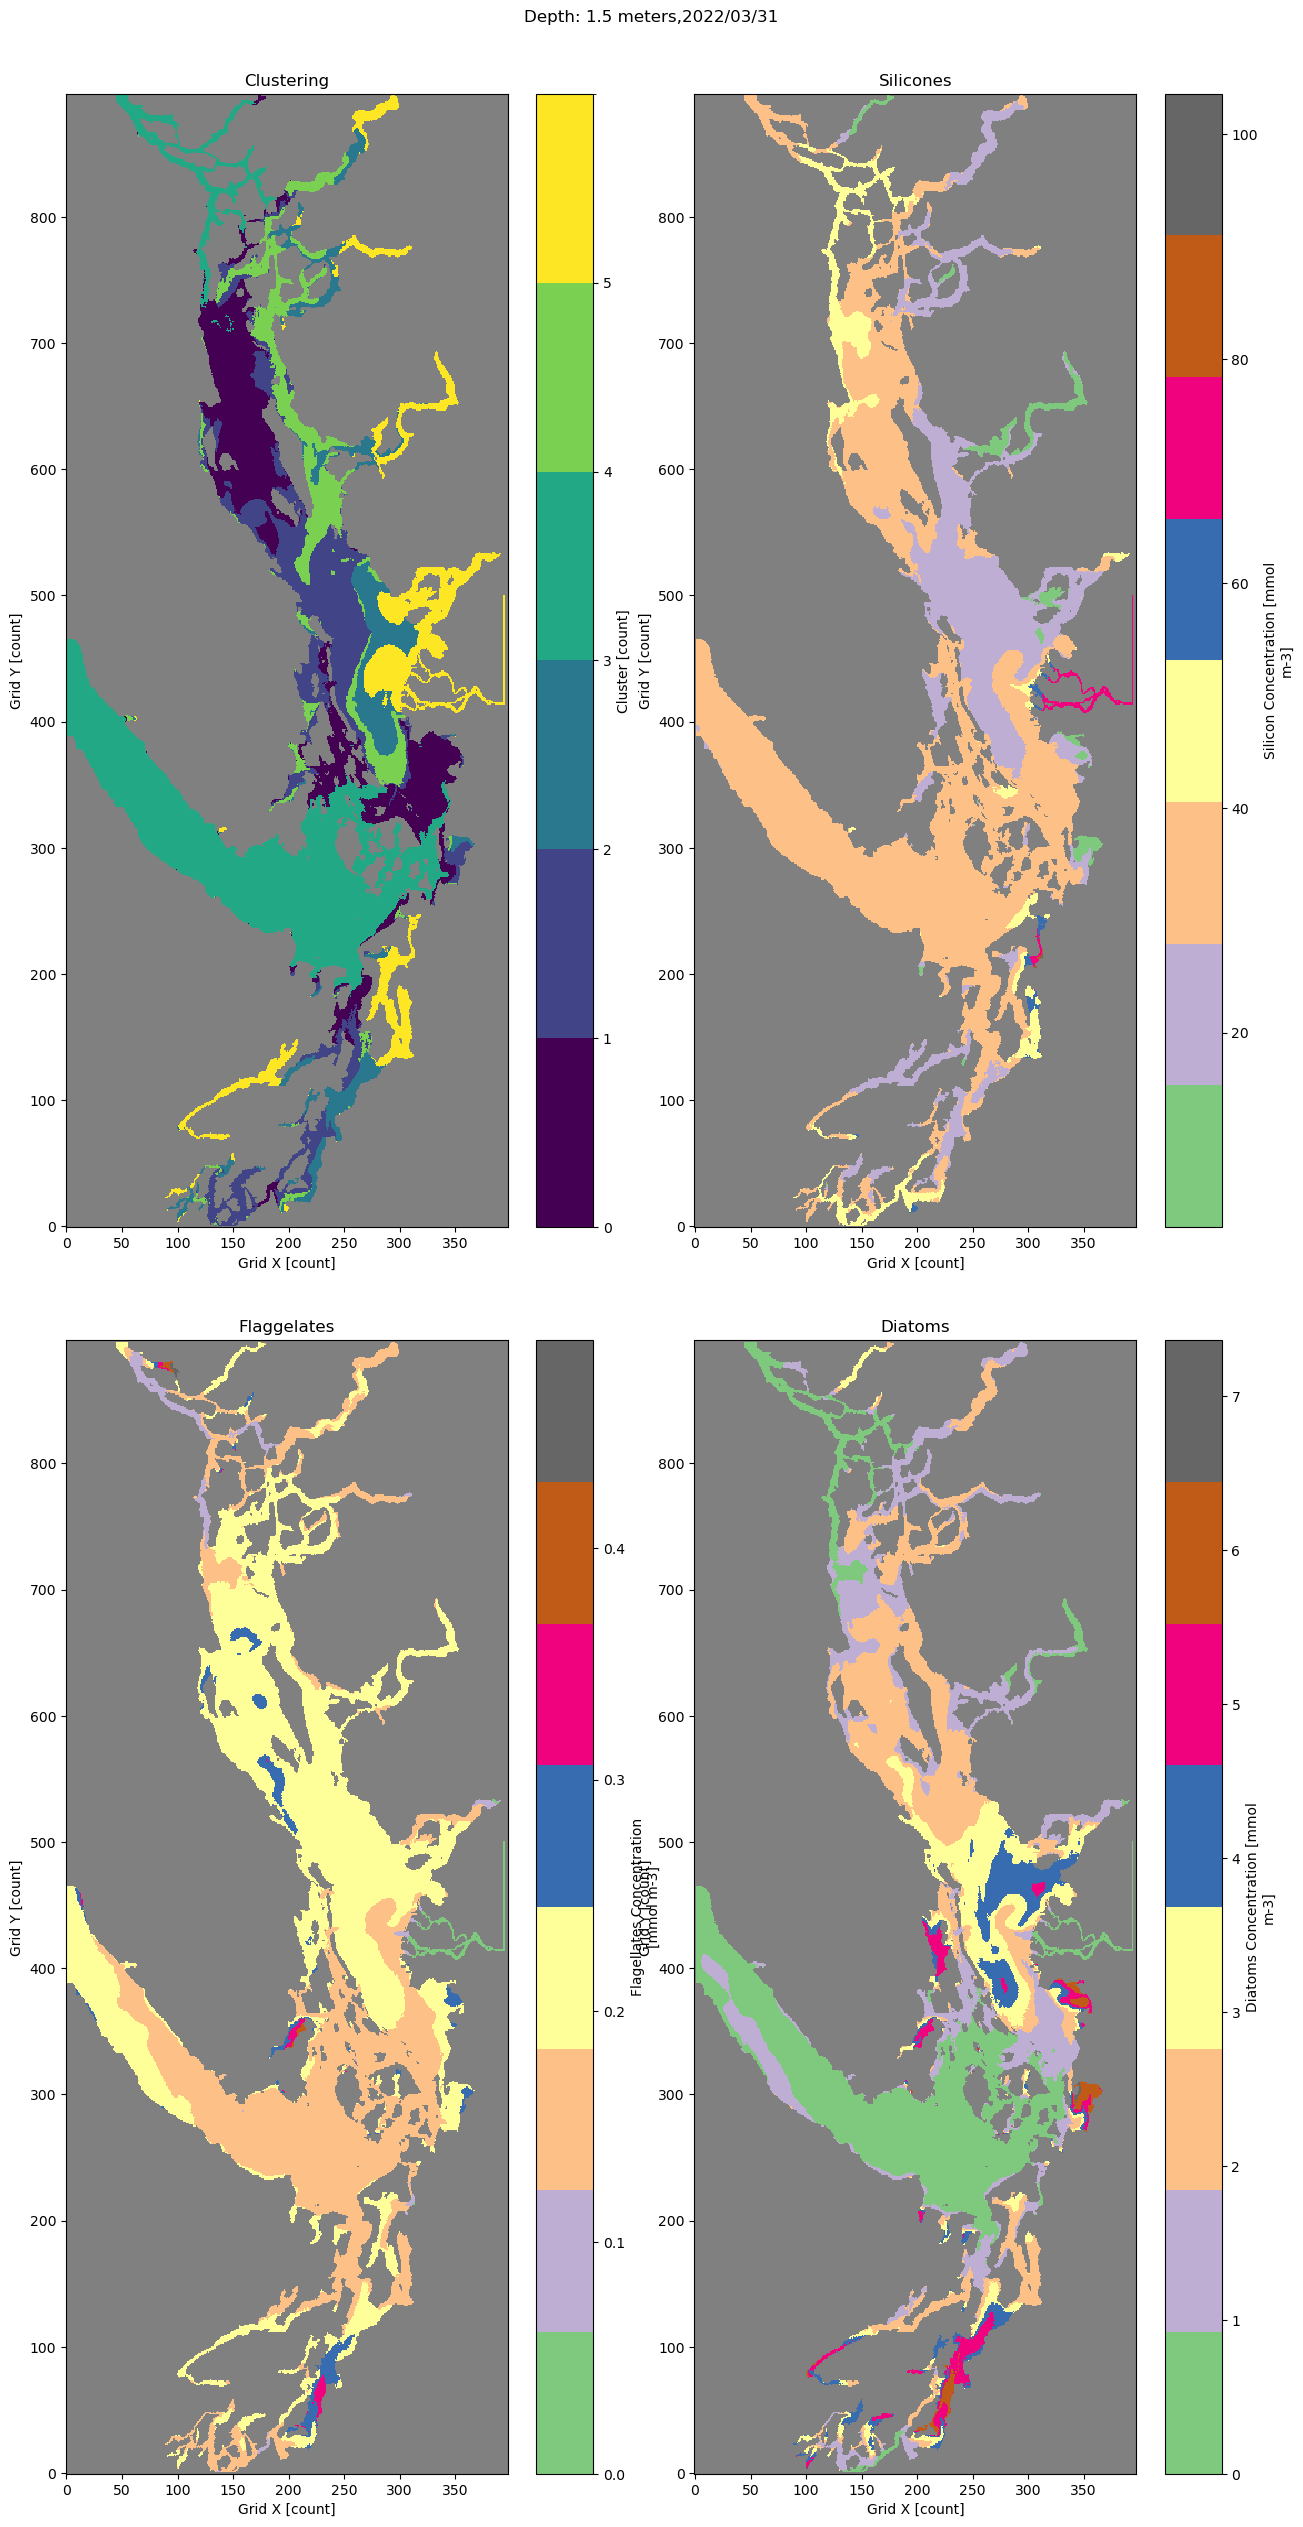

The amount of grid boxes for cluster 0 is 9842 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.12 degrees Celsius
The mean temperature for cluster 0 is 9.04 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 24.07 g/kg
The mean salinity for cluster 0 is 19.41 g/kg 


The amount of grid boxes for cluster 1 is 15277 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.3 degrees Celsius
The mean temperature for cluster 1 is 8.77 degrees Celsius 

The minimum salinity for cluster 1 is 25.75 g/kg
The maximum salinity for cluster 1 is 27.4 g/kg
The mean salinity for cluster 1 is 26.63 g/kg 


The amount of grid boxes for cluster 2 is 8985 

The minimum temperature for cluster 2 is 7.11 degrees Celsius
The maximum temperature for cluster 2 is 9.61 degrees Celsius
The mean temperature for cluster 2 is 8.36 degrees Celsius 

The m

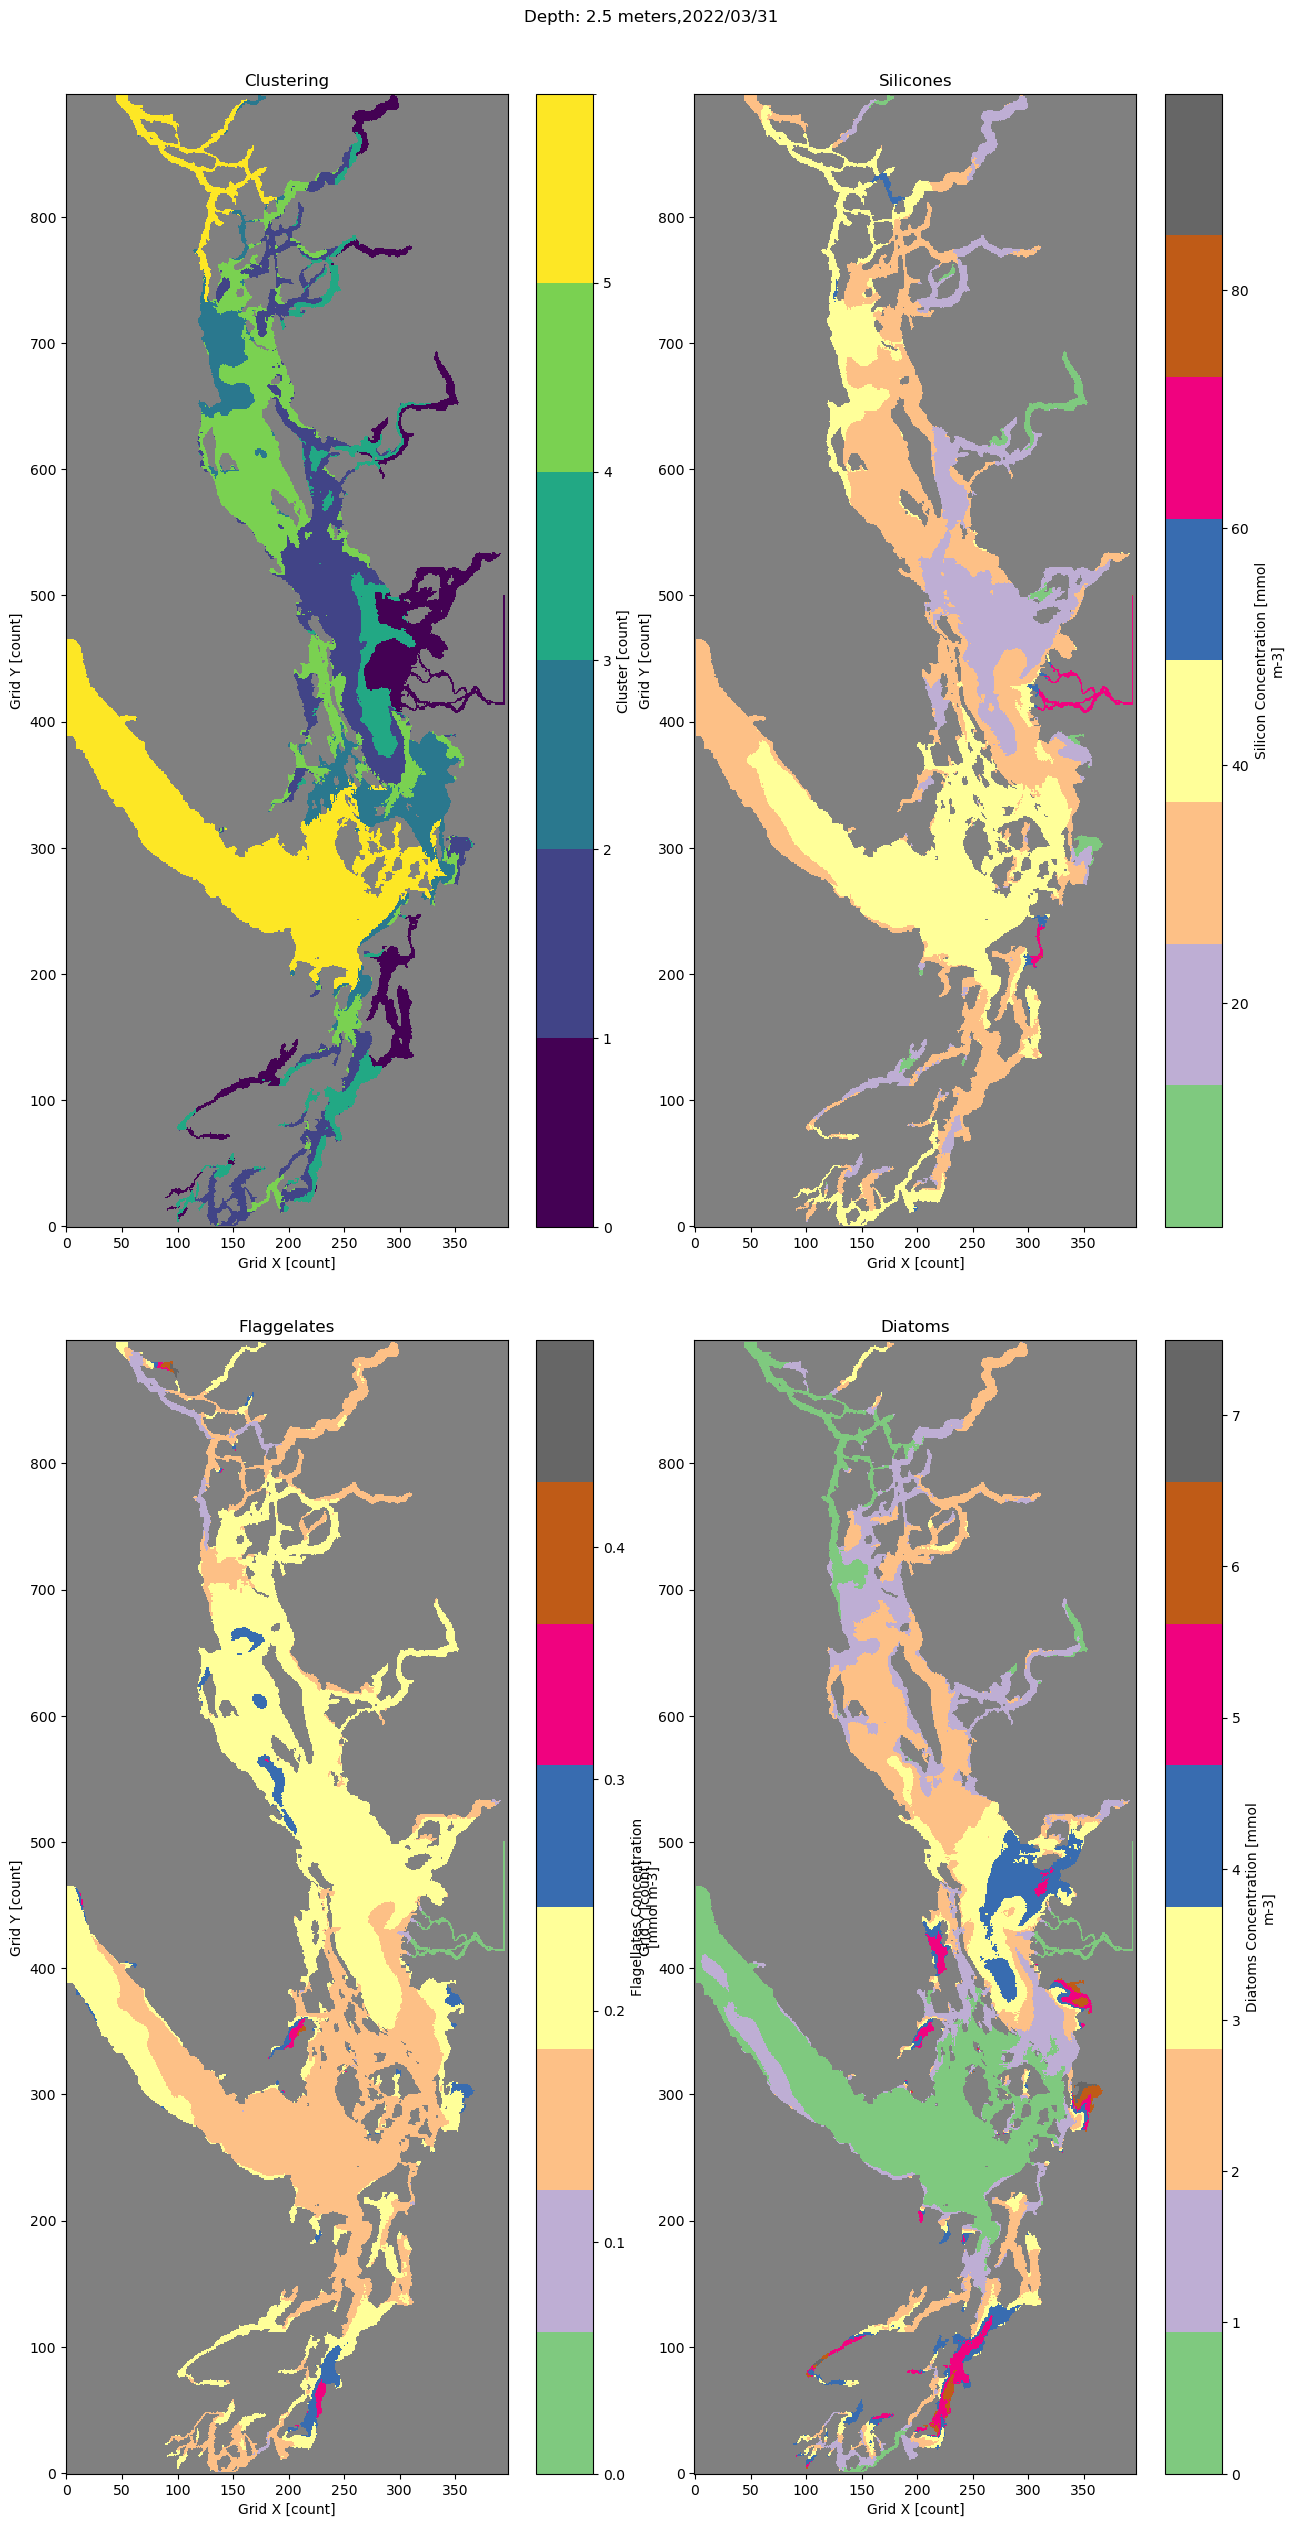

The amount of grid boxes for cluster 0 is 10381 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.84 degrees Celsius
The mean temperature for cluster 0 is 8.86 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.67 g/kg
The mean salinity for cluster 0 is 21.47 g/kg 


The amount of grid boxes for cluster 1 is 11543 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 9.71 degrees Celsius
The mean temperature for cluster 1 is 8.41 degrees Celsius 

The minimum salinity for cluster 1 is 27.76 g/kg
The maximum salinity for cluster 1 is 28.85 g/kg
The mean salinity for cluster 1 is 28.33 g/kg 


The amount of grid boxes for cluster 2 is 22573 

The minimum temperature for cluster 2 is 6.77 degrees Celsius
The maximum temperature for cluster 2 is 9.34 degrees Celsius
The mean temperature for cluster 2 is 7.95 degrees Celsius 

Th

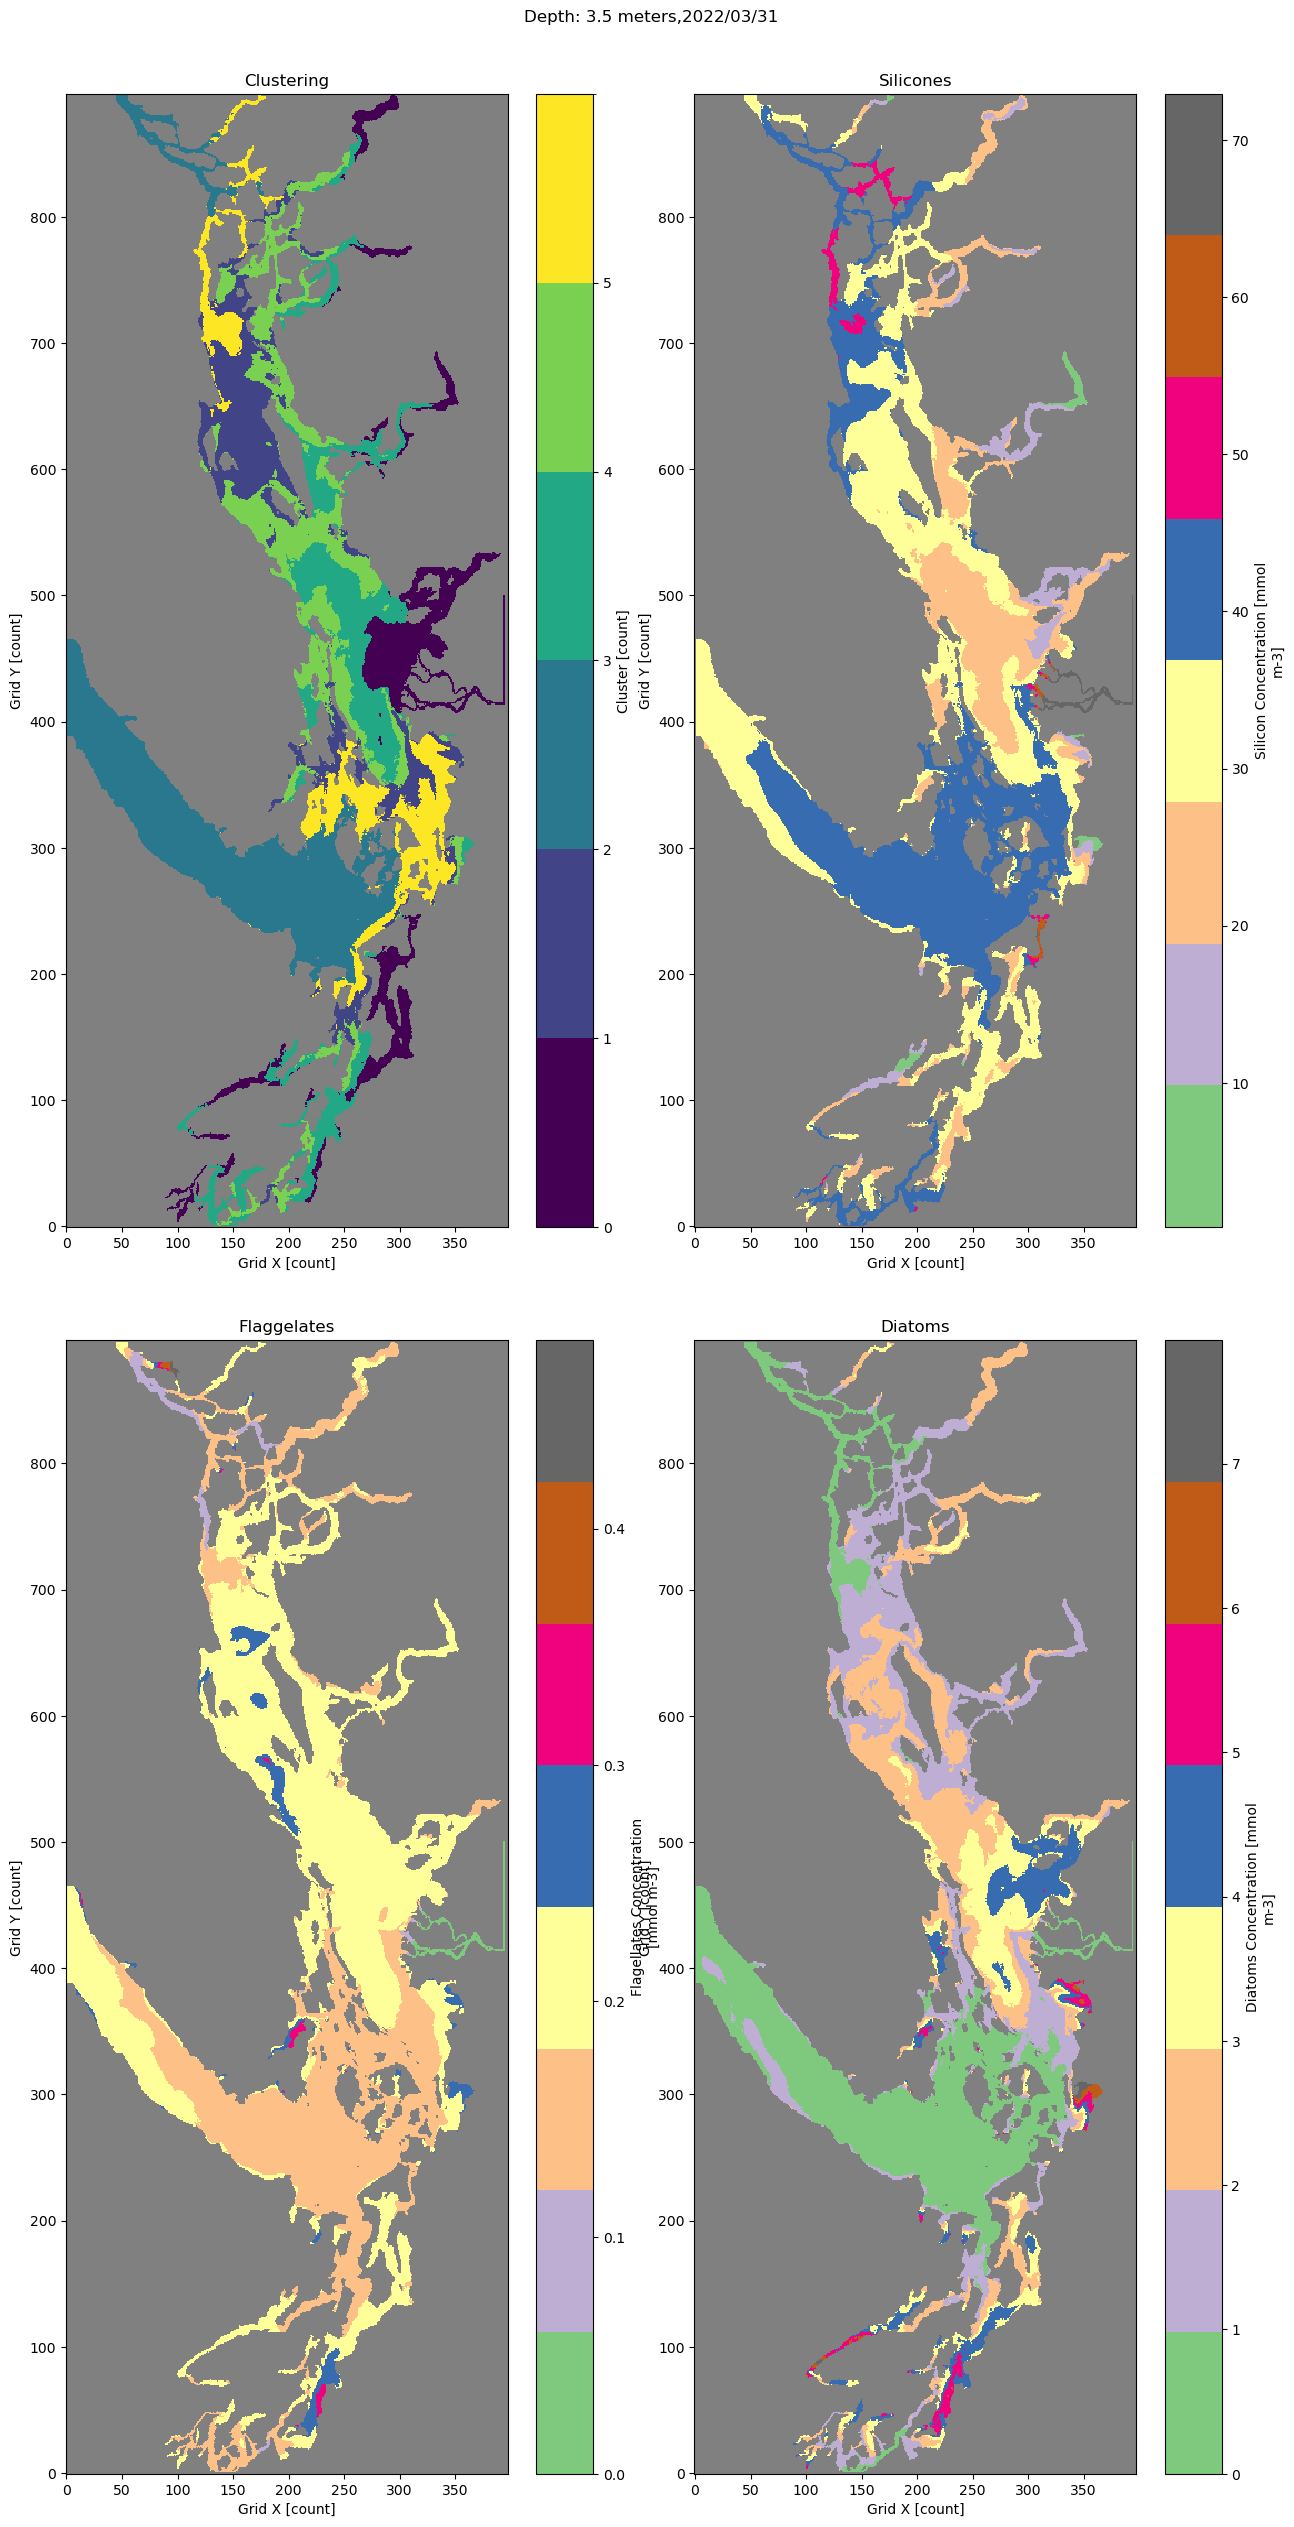

The amount of grid boxes for cluster 0 is 23627 

The minimum temperature for cluster 0 is 6.67 degrees Celsius
The maximum temperature for cluster 0 is 9.36 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 29.33 g/kg
The maximum salinity for cluster 0 is 31.36 g/kg
The mean salinity for cluster 0 is 30.52 g/kg 


The amount of grid boxes for cluster 1 is 10294 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 9.52 degrees Celsius
The mean temperature for cluster 1 is 8.29 degrees Celsius 

The minimum salinity for cluster 1 is 27.94 g/kg
The maximum salinity for cluster 1 is 28.91 g/kg
The mean salinity for cluster 1 is 28.43 g/kg 


The amount of grid boxes for cluster 2 is 9993 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.74 degrees Celsius 

T

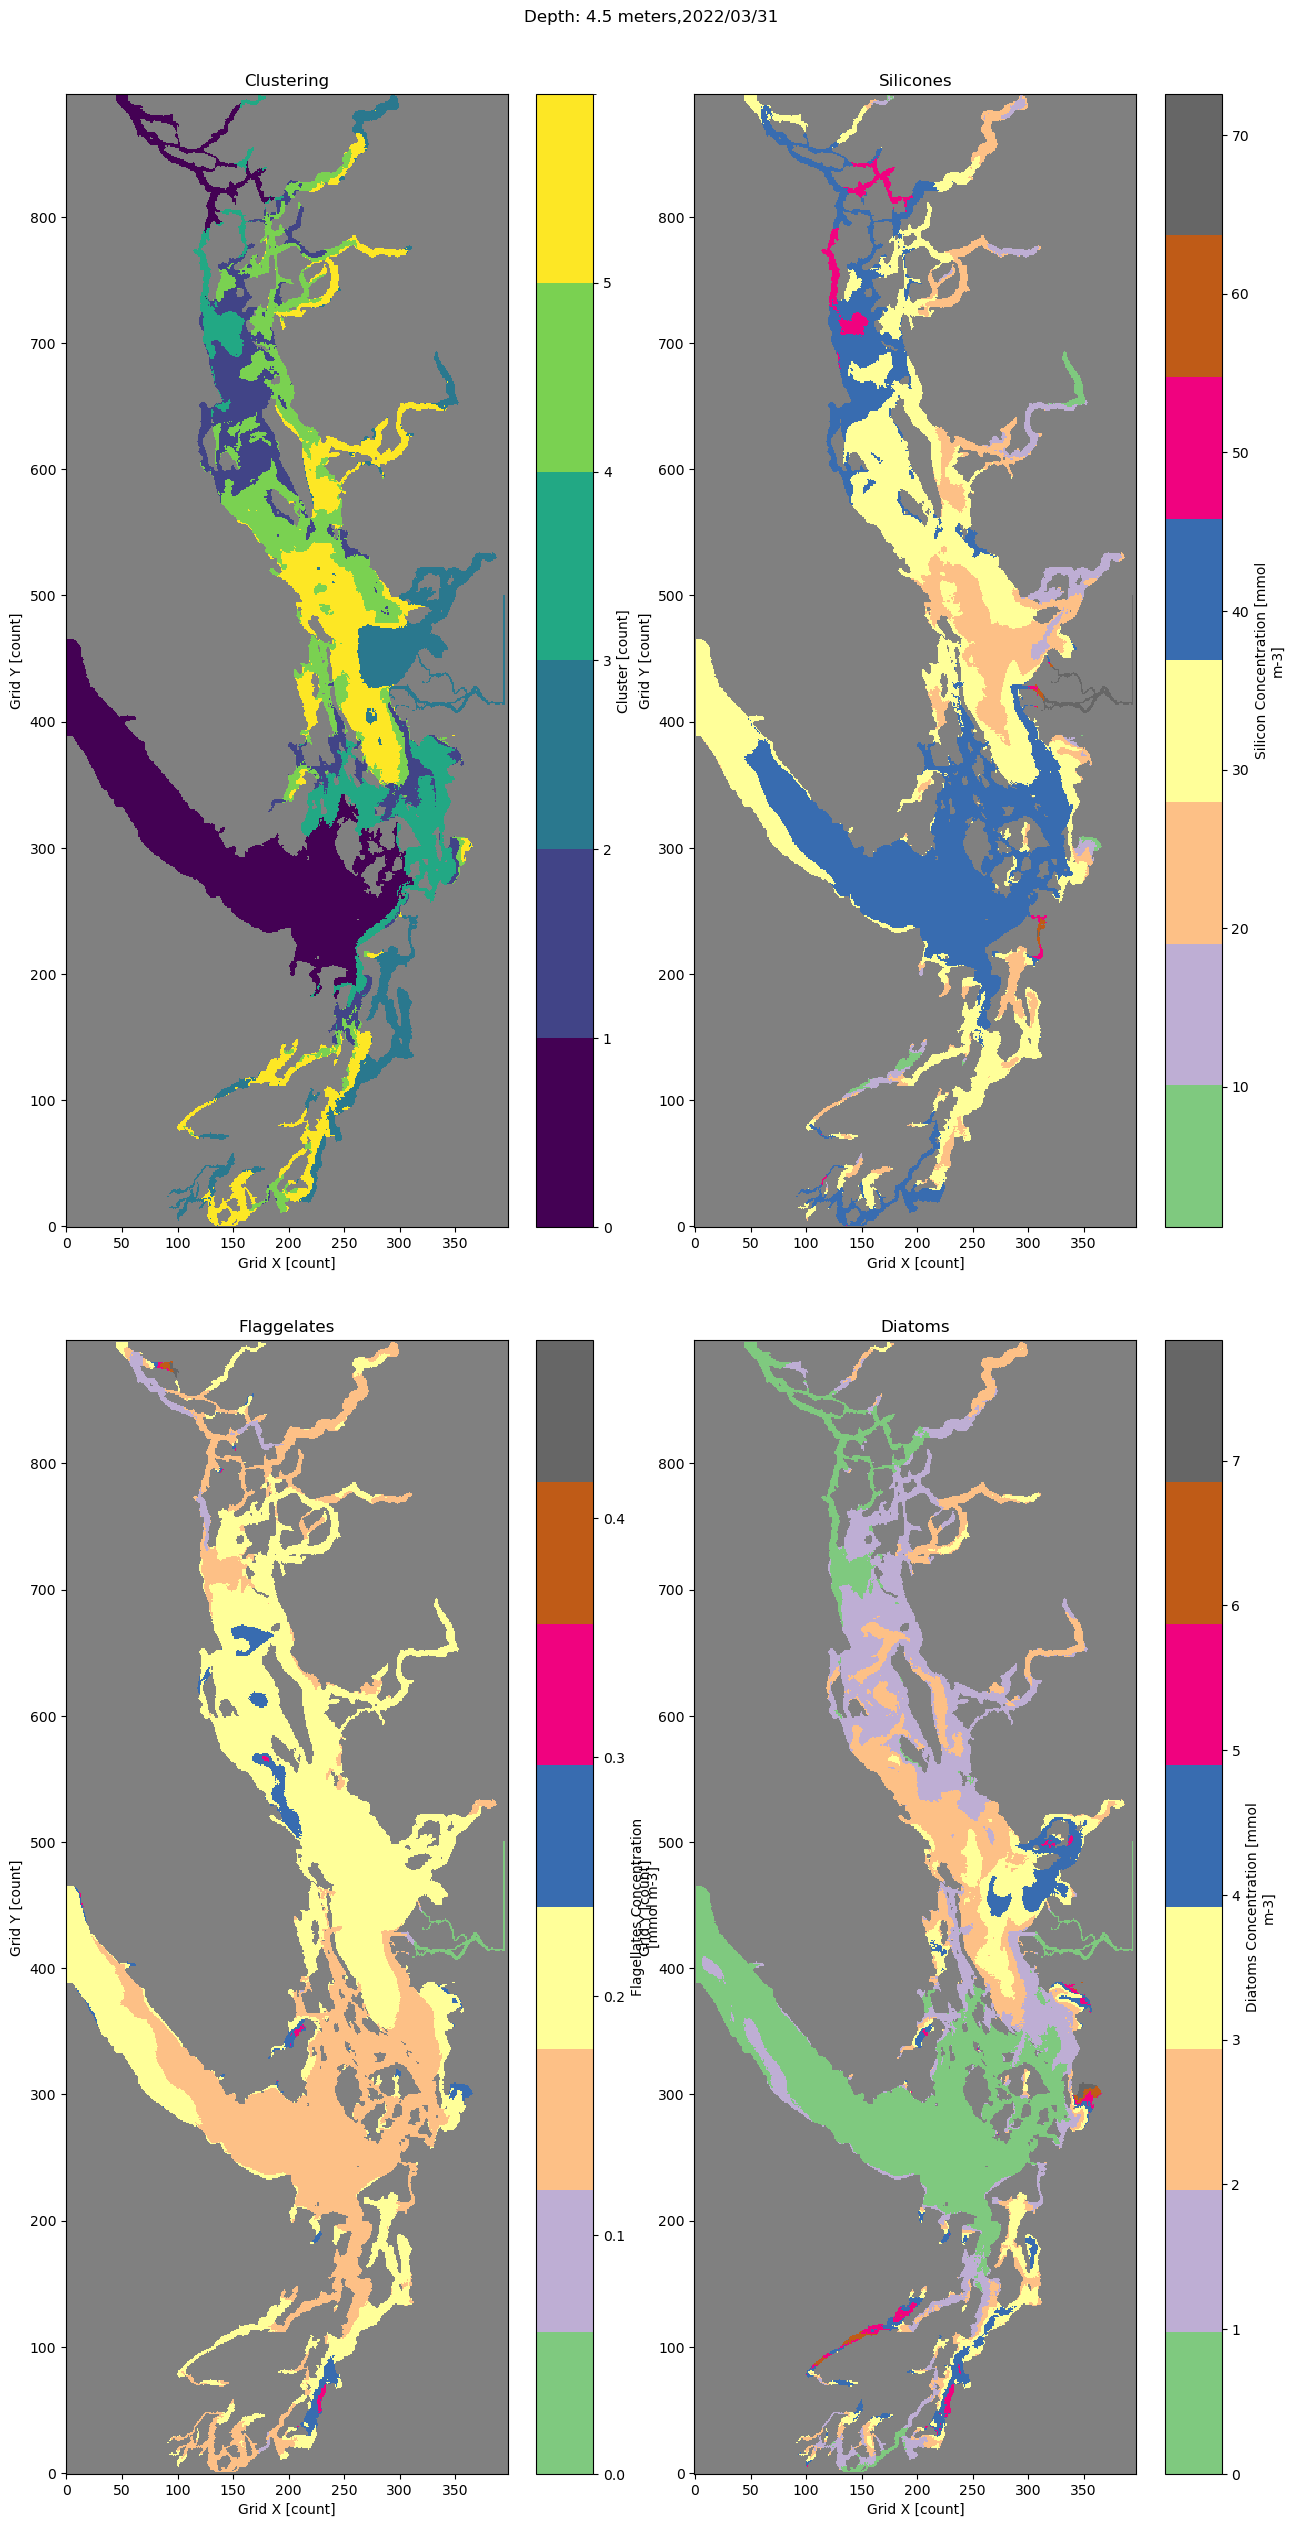

The amount of grid boxes for cluster 0 is 6589 

The minimum temperature for cluster 0 is 6.54 degrees Celsius
The maximum temperature for cluster 0 is 9.24 degrees Celsius
The mean temperature for cluster 0 is 8.14 degrees Celsius 

The minimum salinity for cluster 0 is 29.02 g/kg
The maximum salinity for cluster 0 is 29.85 g/kg
The mean salinity for cluster 0 is 29.34 g/kg 


The amount of grid boxes for cluster 1 is 23713 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 10.21 degrees Celsius
The mean temperature for cluster 1 is 8.24 degrees Celsius 

The minimum salinity for cluster 1 is 27.47 g/kg
The maximum salinity for cluster 1 is 28.7 g/kg
The mean salinity for cluster 1 is 28.07 g/kg 


The amount of grid boxes for cluster 2 is 13772 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 10.37 degrees Celsius
The mean temperature for cluster 2 is 8.52 degrees Celsius 

Th

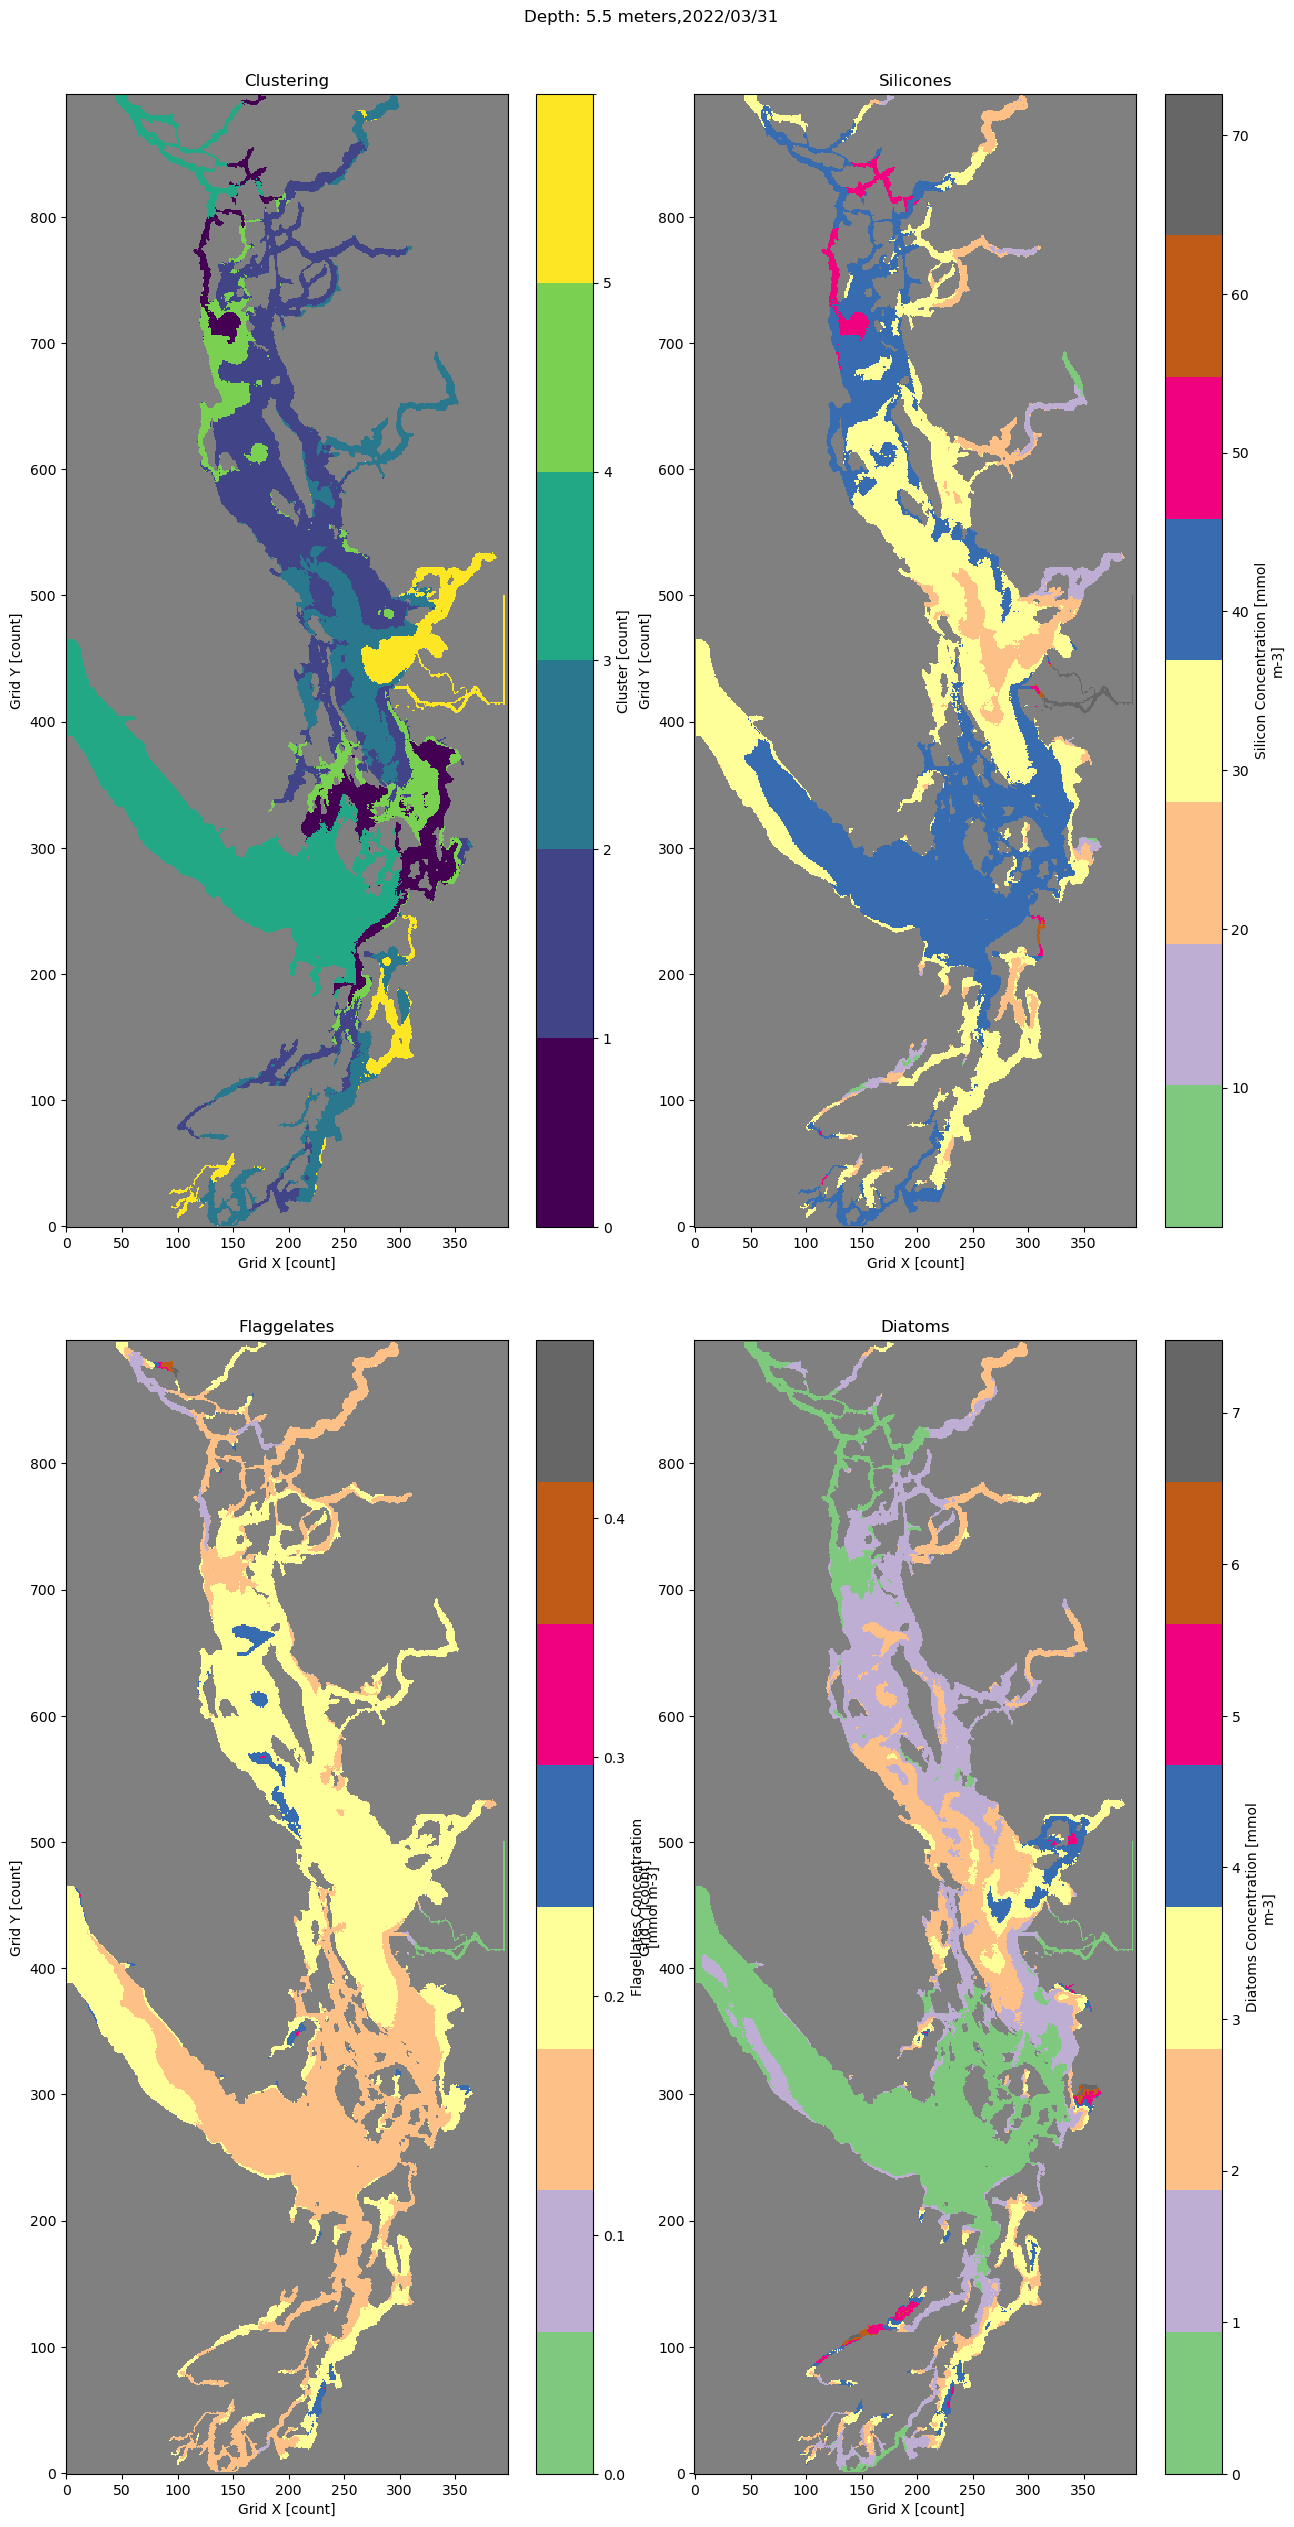

The amount of grid boxes for cluster 0 is 11517 

The minimum temperature for cluster 0 is 7.3 degrees Celsius
The maximum temperature for cluster 0 is 10.31 degrees Celsius
The mean temperature for cluster 0 is 8.47 degrees Celsius 

The minimum salinity for cluster 0 is 26.61 g/kg
The maximum salinity for cluster 0 is 27.98 g/kg
The mean salinity for cluster 0 is 27.33 g/kg 


The amount of grid boxes for cluster 1 is 13443 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.18 degrees Celsius 

The minimum salinity for cluster 1 is 28.32 g/kg
The maximum salinity for cluster 1 is 28.98 g/kg
The mean salinity for cluster 1 is 28.59 g/kg 


The amount of grid boxes for cluster 2 is 24533 

The minimum temperature for cluster 2 is 6.32 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 7.91 degrees Celsius 

T

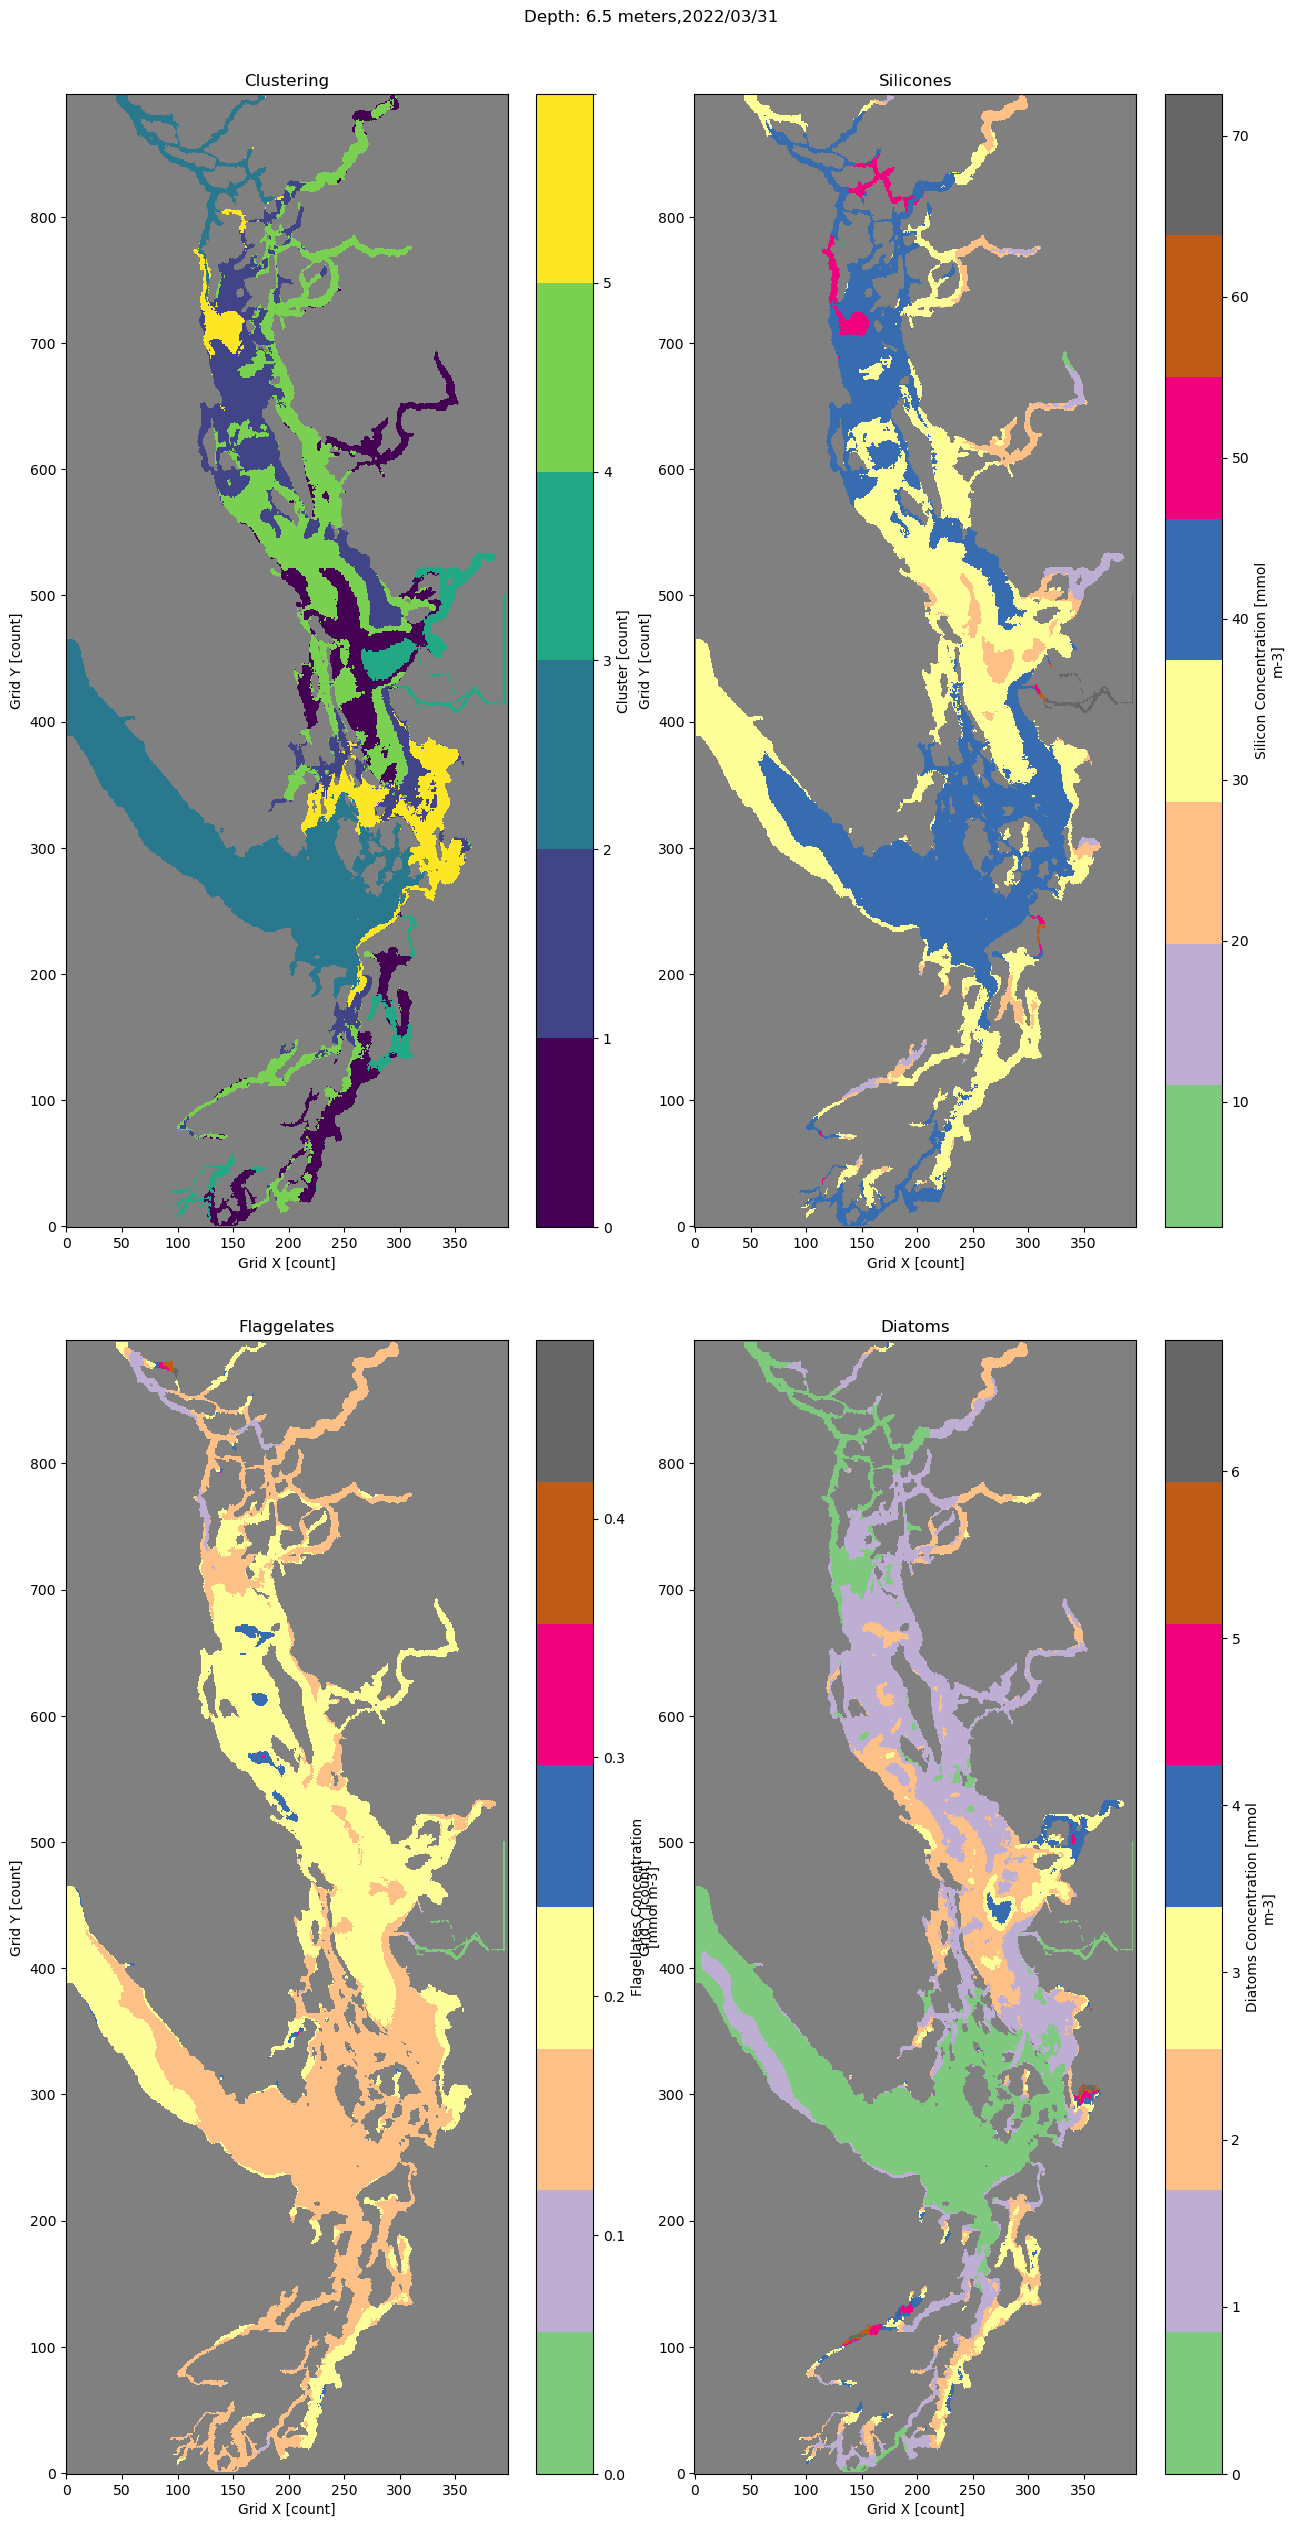

The amount of grid boxes for cluster 0 is 13131 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.3 degrees Celsius
The mean temperature for cluster 0 is 8.61 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.77 g/kg
The mean salinity for cluster 0 is 26.62 g/kg 


The amount of grid boxes for cluster 1 is 7444 

The minimum temperature for cluster 1 is 7.78 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.22 degrees Celsius 

The minimum salinity for cluster 1 is 28.56 g/kg
The maximum salinity for cluster 1 is 29.43 g/kg
The mean salinity for cluster 1 is 29.02 g/kg 


The amount of grid boxes for cluster 2 is 21155 

The minimum temperature for cluster 2 is 7.29 degrees Celsius
The maximum temperature for cluster 2 is 8.76 degrees Celsius
The mean temperature for cluster 2 is 7.9 degrees Celsius 

The 

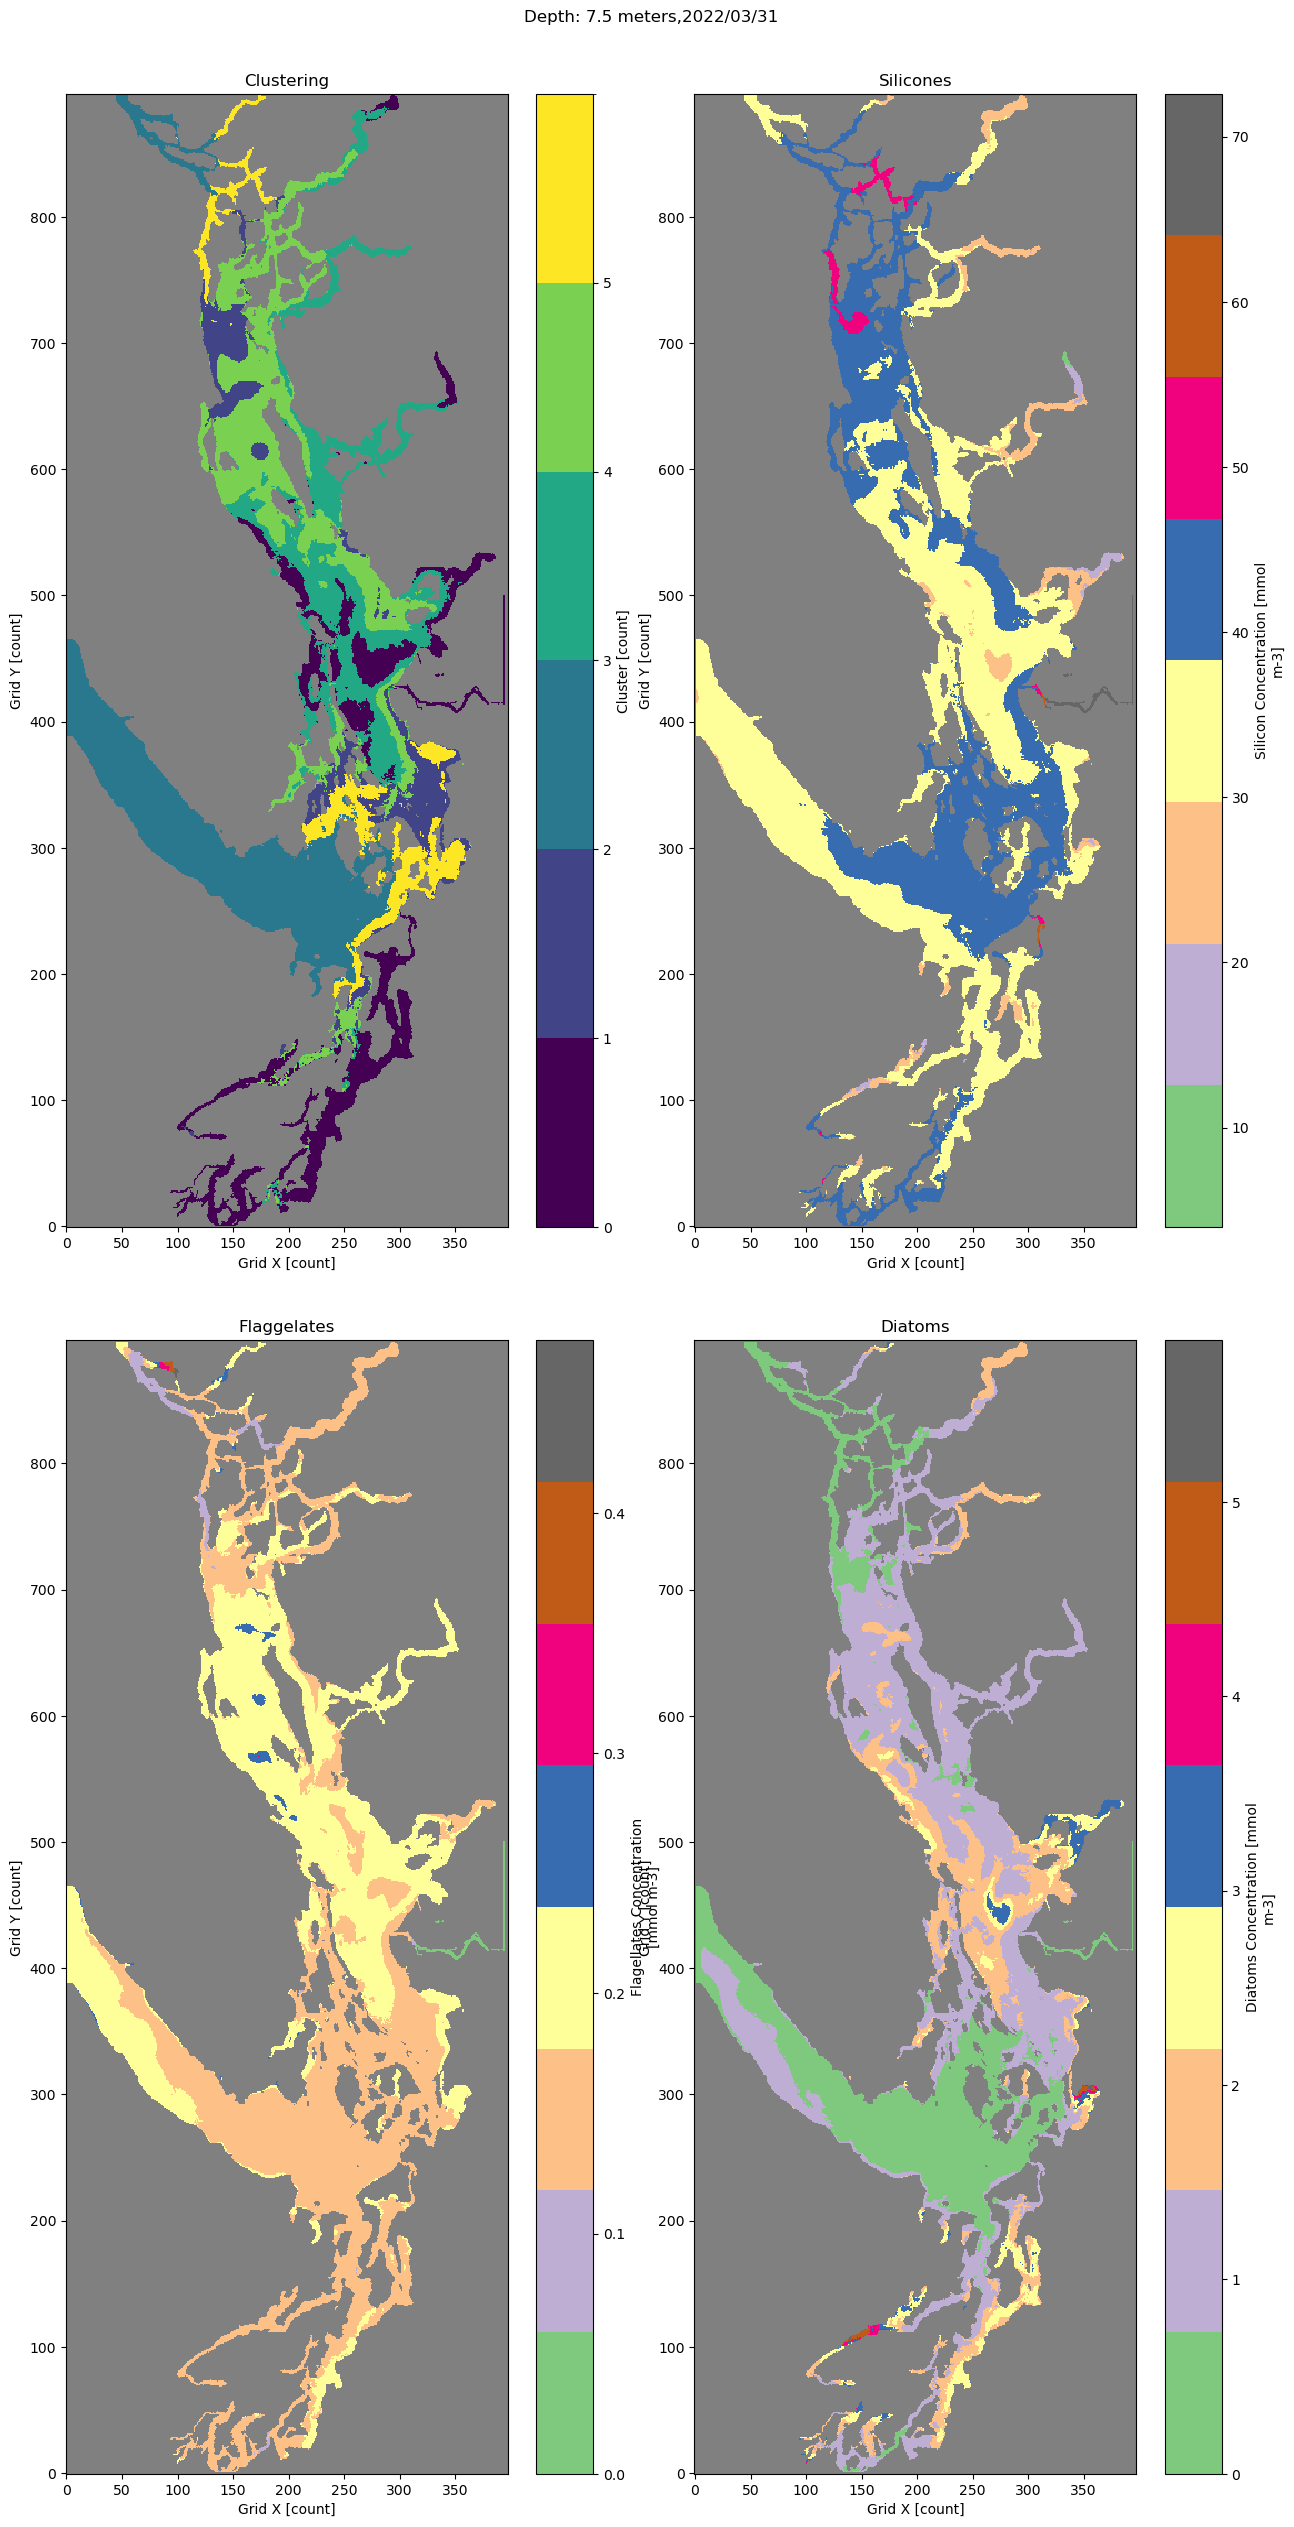

The amount of grid boxes for cluster 0 is 19113 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.75 degrees Celsius
The mean temperature for cluster 0 is 7.89 degrees Celsius 

The minimum salinity for cluster 0 is 30.0 g/kg
The maximum salinity for cluster 0 is 31.46 g/kg
The mean salinity for cluster 0 is 30.73 g/kg 


The amount of grid boxes for cluster 1 is 5556 

The minimum temperature for cluster 1 is 7.61 degrees Celsius
The maximum temperature for cluster 1 is 8.88 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 29.04 g/kg
The maximum salinity for cluster 1 is 29.59 g/kg
The mean salinity for cluster 1 is 29.3 g/kg 


The amount of grid boxes for cluster 2 is 19107 

The minimum temperature for cluster 2 is 7.4 degrees Celsius
The maximum temperature for cluster 2 is 10.27 degrees Celsius
The mean temperature for cluster 2 is 8.06 degrees Celsius 

The 

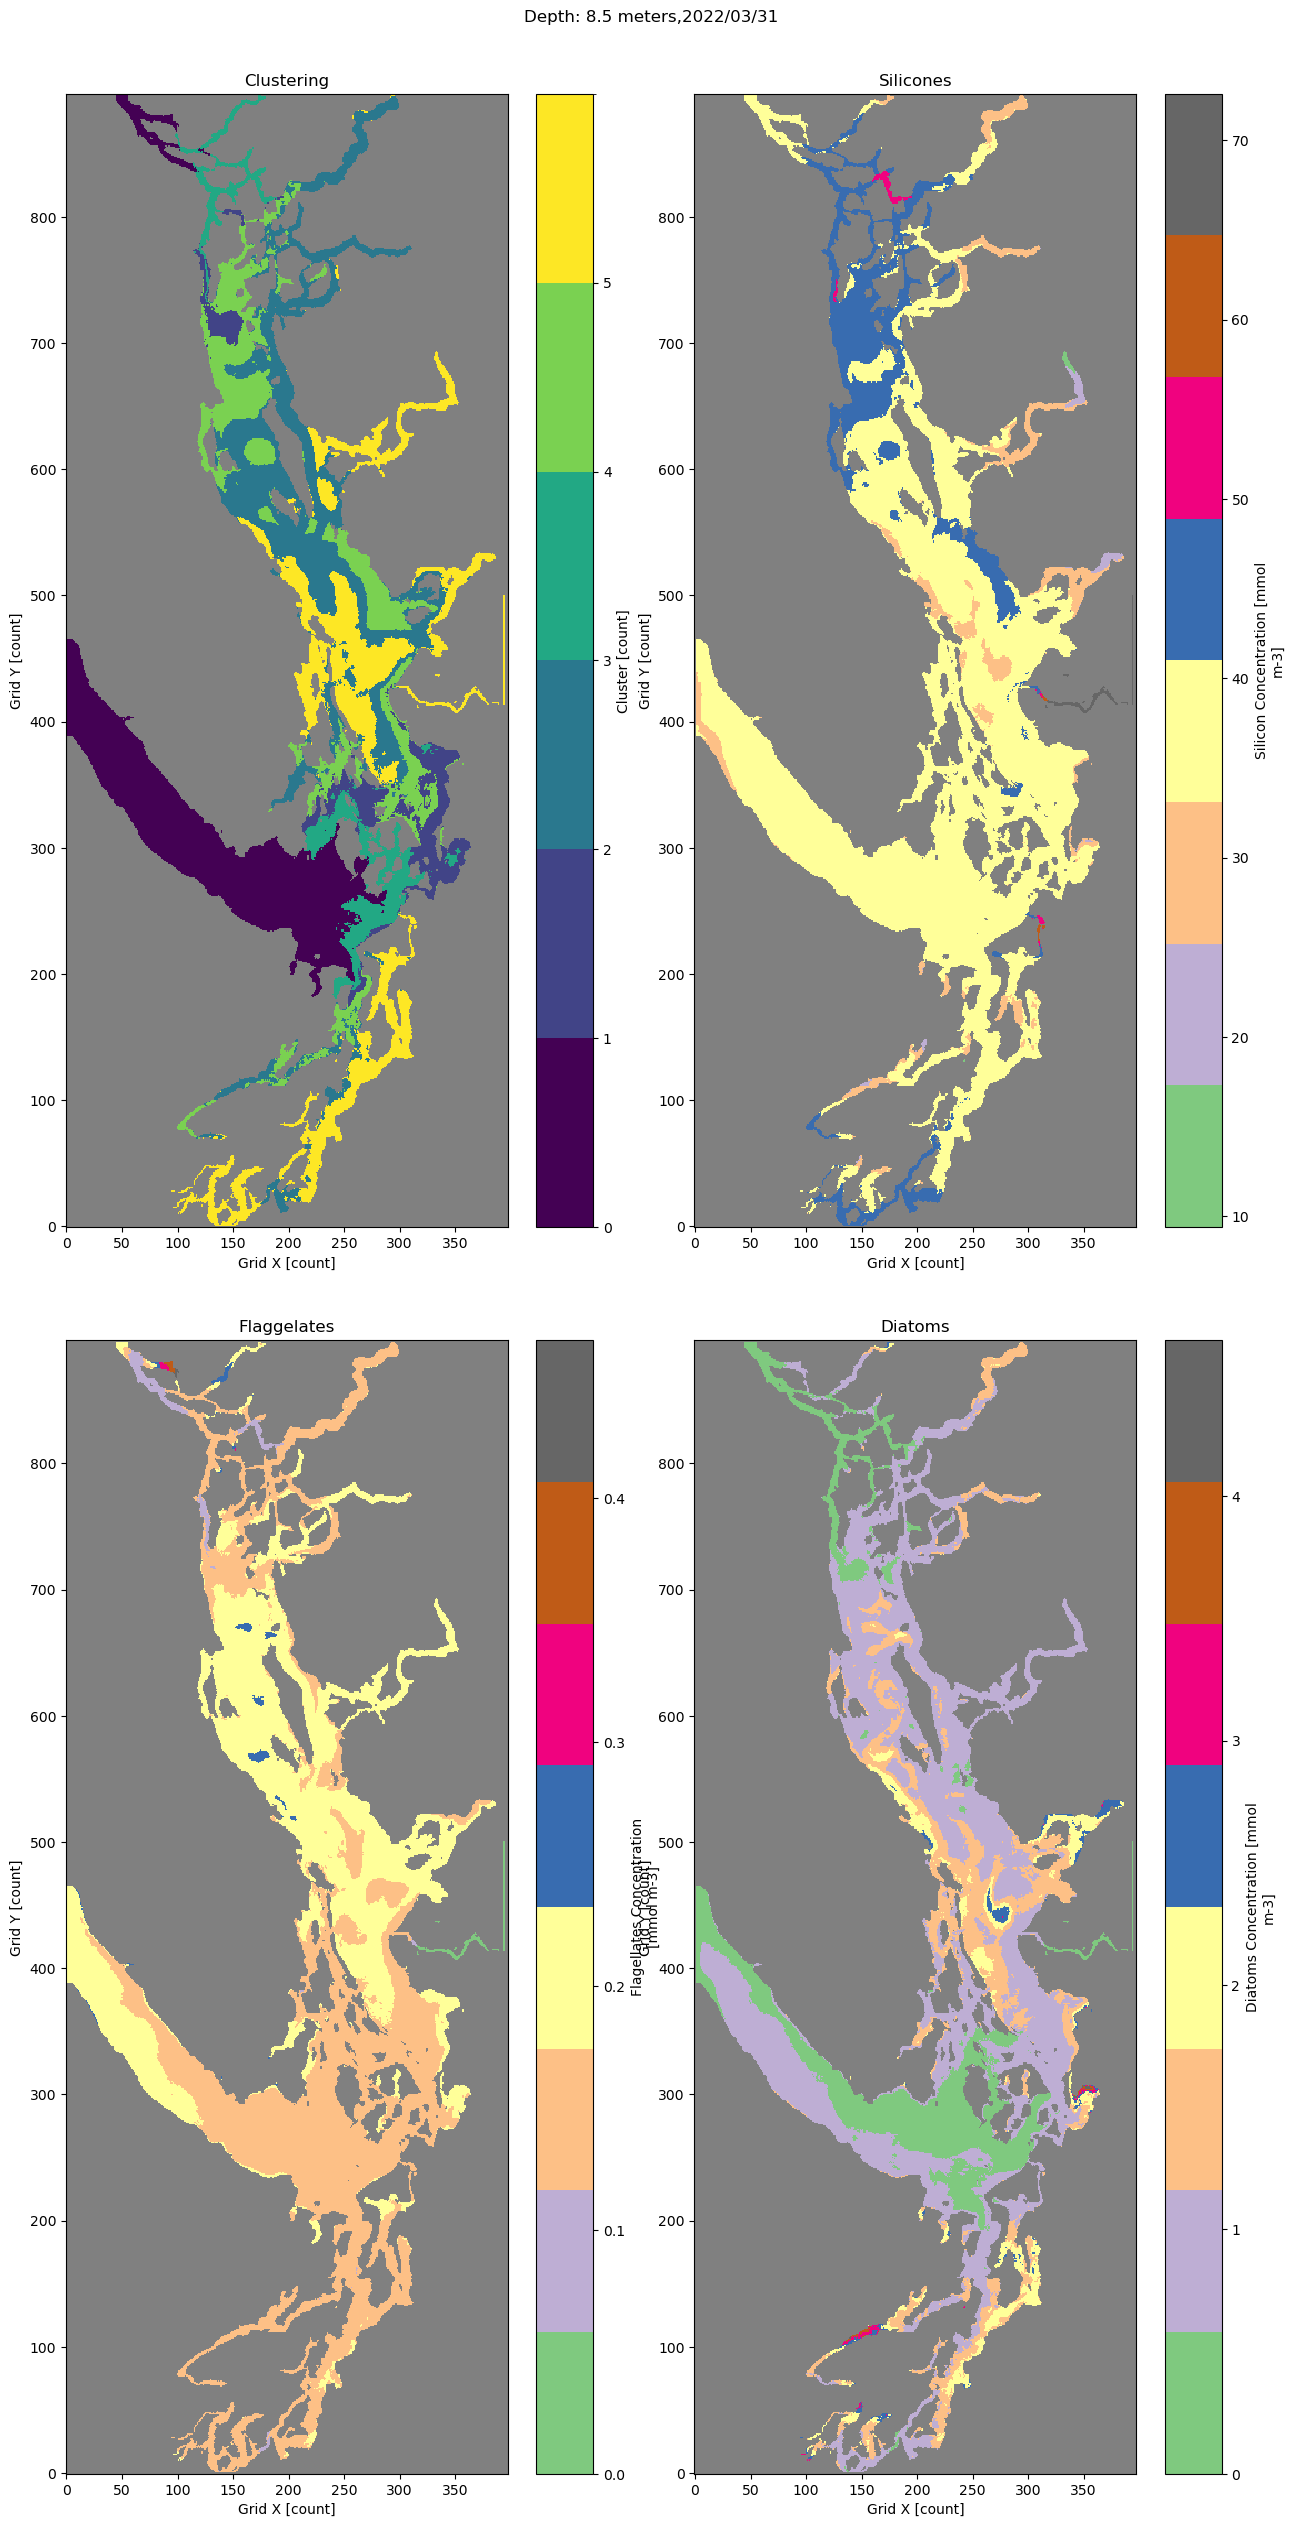

The amount of grid boxes for cluster 0 is 19116 

The minimum temperature for cluster 0 is 7.39 degrees Celsius
The maximum temperature for cluster 0 is 8.42 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 27.59 g/kg
The maximum salinity for cluster 0 is 28.71 g/kg
The mean salinity for cluster 0 is 28.36 g/kg 


The amount of grid boxes for cluster 1 is 8389 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.84 degrees Celsius
The mean temperature for cluster 1 is 8.1 degrees Celsius 

The minimum salinity for cluster 1 is 28.74 g/kg
The maximum salinity for cluster 1 is 29.5 g/kg
The mean salinity for cluster 1 is 29.2 g/kg 


The amount of grid boxes for cluster 2 is 18097 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The mi

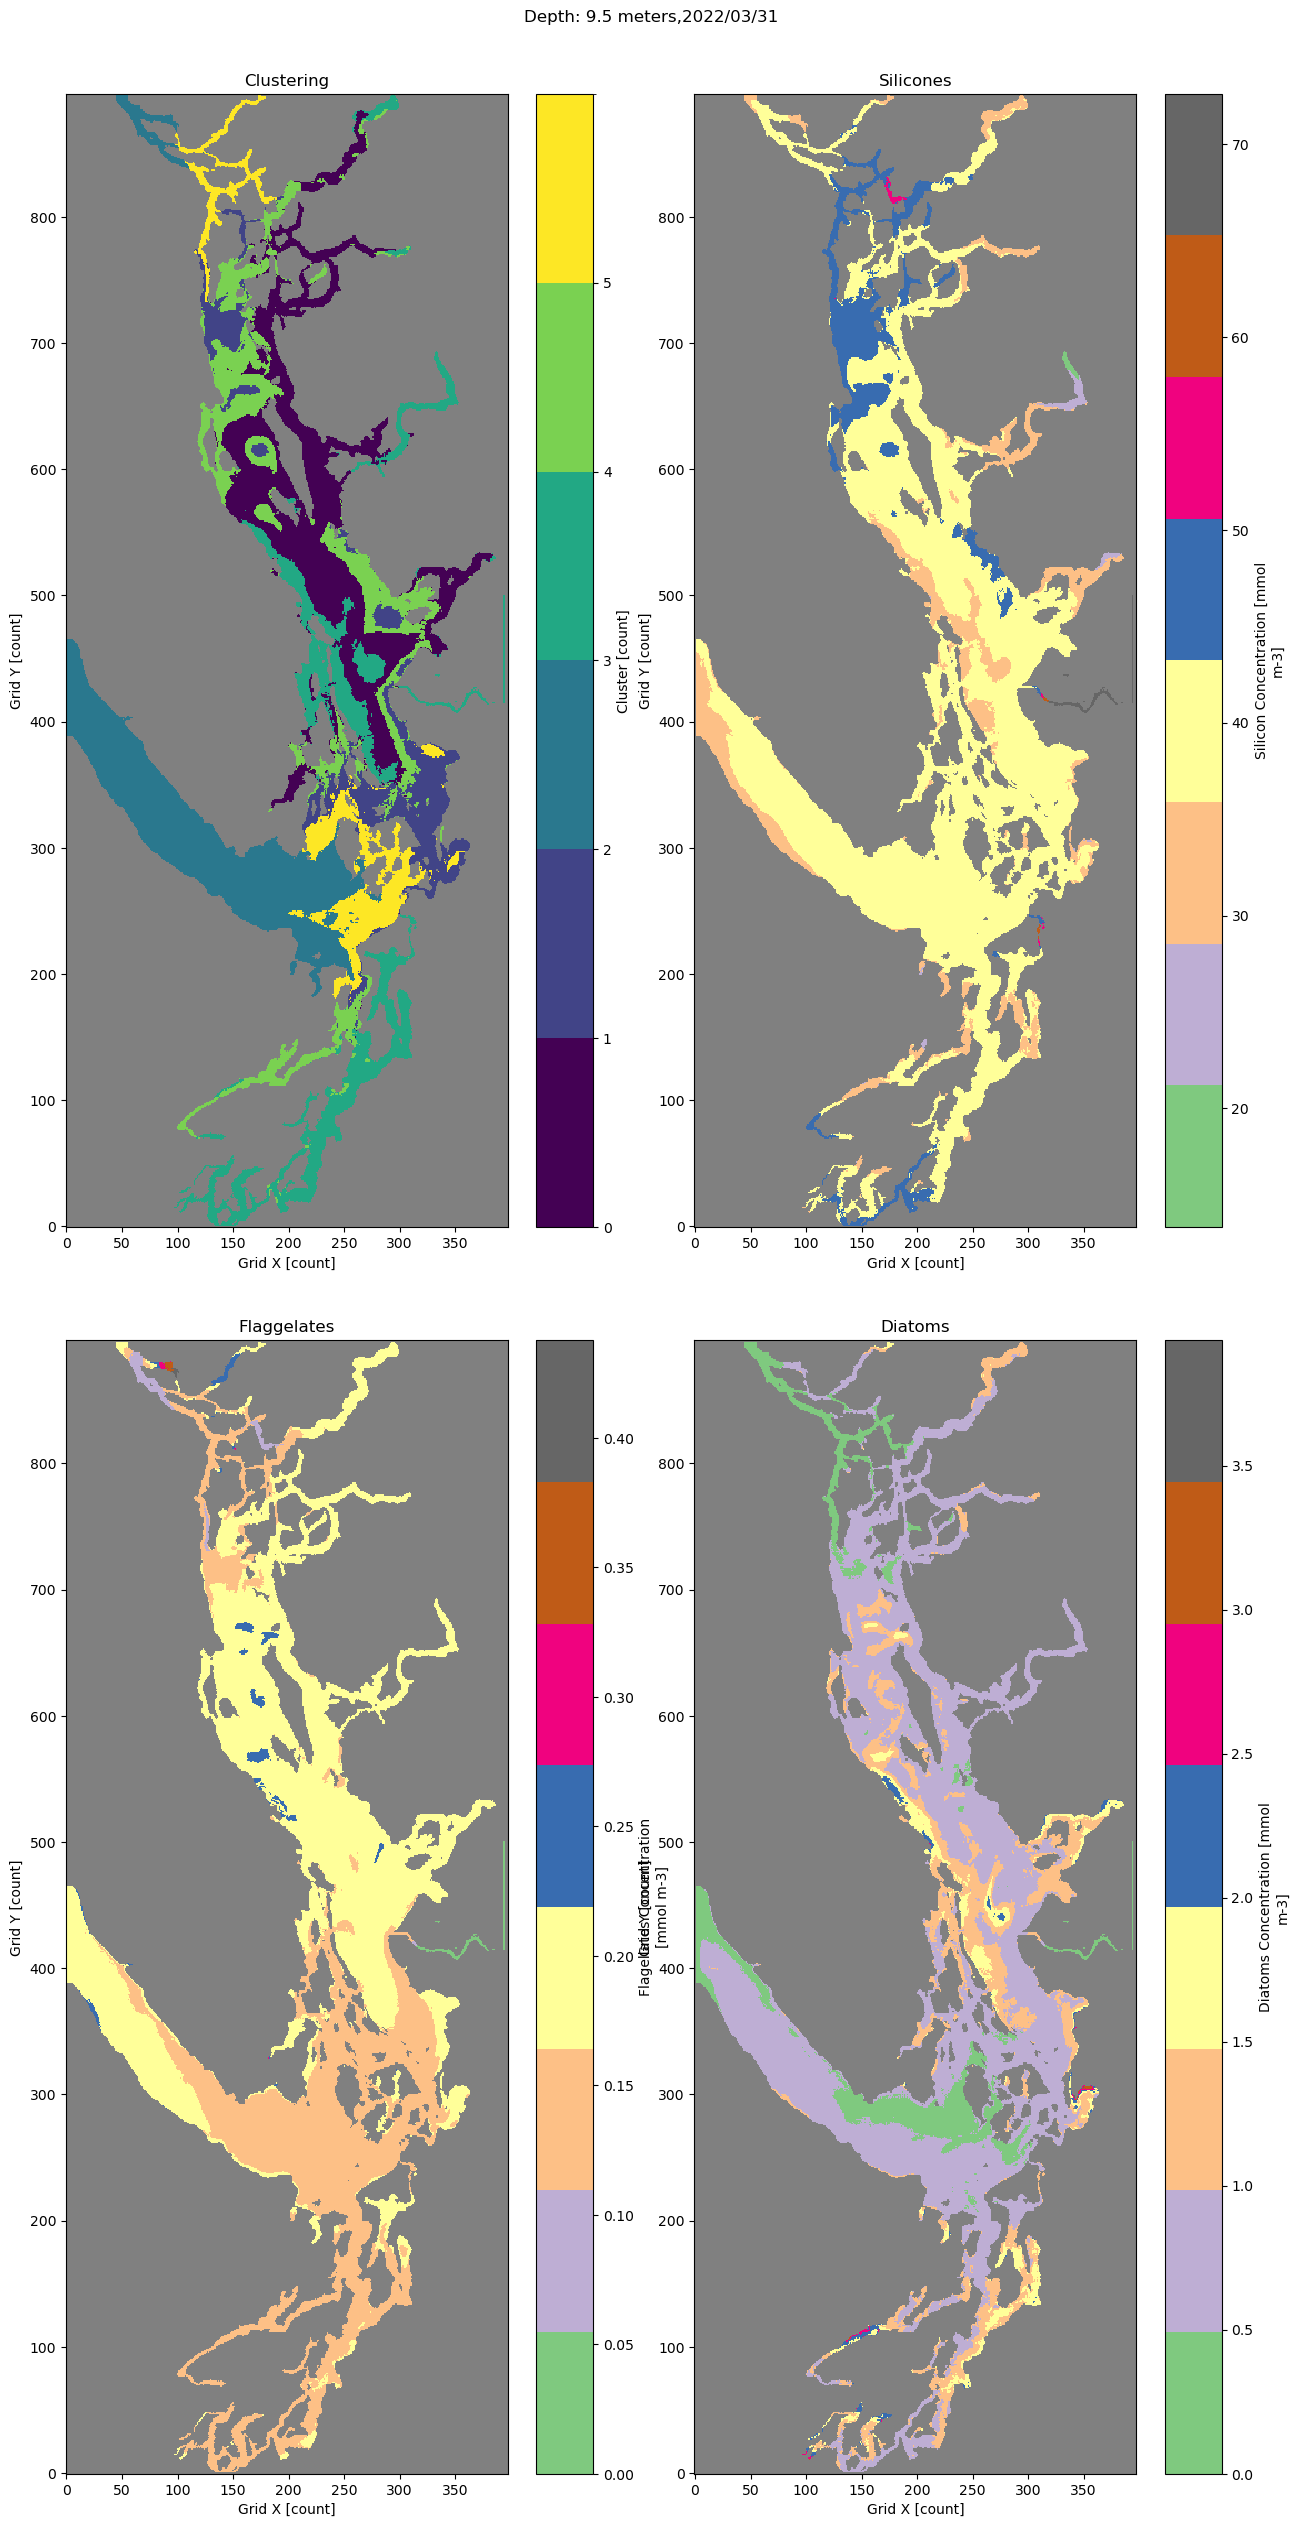

The amount of grid boxes for cluster 0 is 14391 

The minimum temperature for cluster 0 is 6.38 degrees Celsius
The maximum temperature for cluster 0 is 10.34 degrees Celsius
The mean temperature for cluster 0 is 8.57 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.25 g/kg
The mean salinity for cluster 0 is 27.75 g/kg 


The amount of grid boxes for cluster 1 is 5867 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.77 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 29.17 g/kg
The maximum salinity for cluster 1 is 29.84 g/kg
The mean salinity for cluster 1 is 29.44 g/kg 


The amount of grid boxes for cluster 2 is 17063 

The minimum temperature for cluster 2 is 7.32 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

The

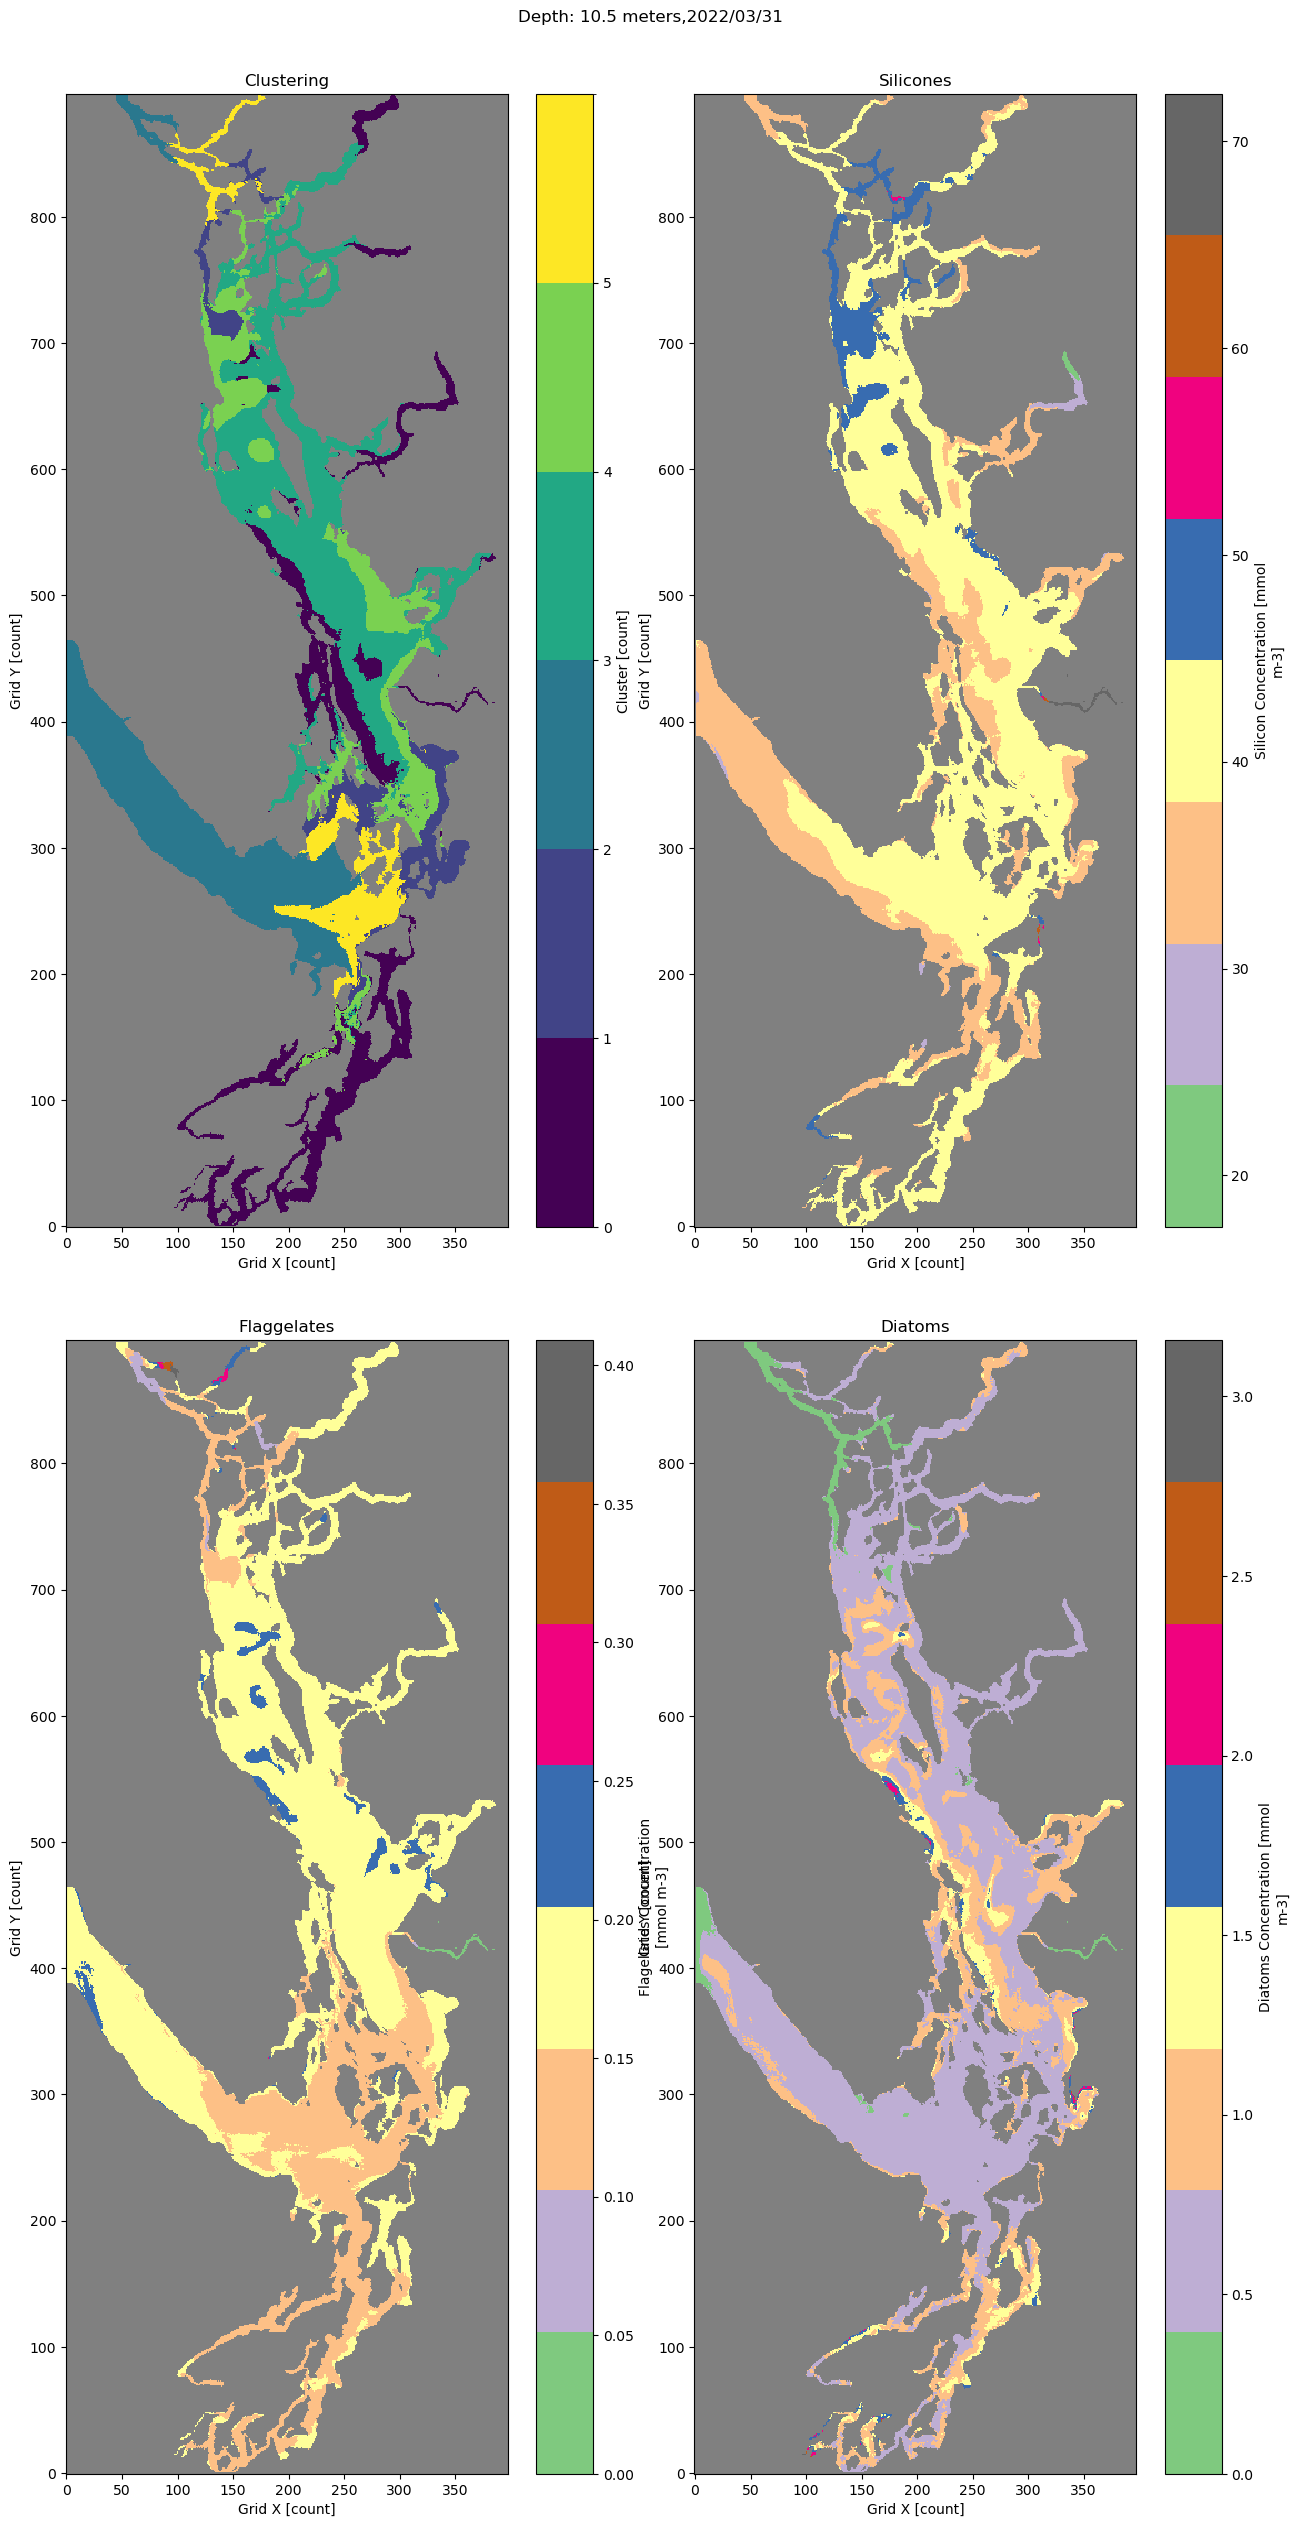

The amount of grid boxes for cluster 0 is 5851 

The minimum temperature for cluster 0 is 6.32 degrees Celsius
The maximum temperature for cluster 0 is 8.64 degrees Celsius
The mean temperature for cluster 0 is 7.89 degrees Celsius 

The minimum salinity for cluster 0 is 29.46 g/kg
The maximum salinity for cluster 0 is 30.11 g/kg
The mean salinity for cluster 0 is 29.83 g/kg 


The amount of grid boxes for cluster 1 is 13738 

The minimum temperature for cluster 1 is 7.68 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.21 degrees Celsius 

The minimum salinity for cluster 1 is 28.79 g/kg
The maximum salinity for cluster 1 is 29.25 g/kg
The mean salinity for cluster 1 is 28.98 g/kg 


The amount of grid boxes for cluster 2 is 18693 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 9.27 degrees Celsius
The mean temperature for cluster 2 is 7.95 degrees Celsius 

T

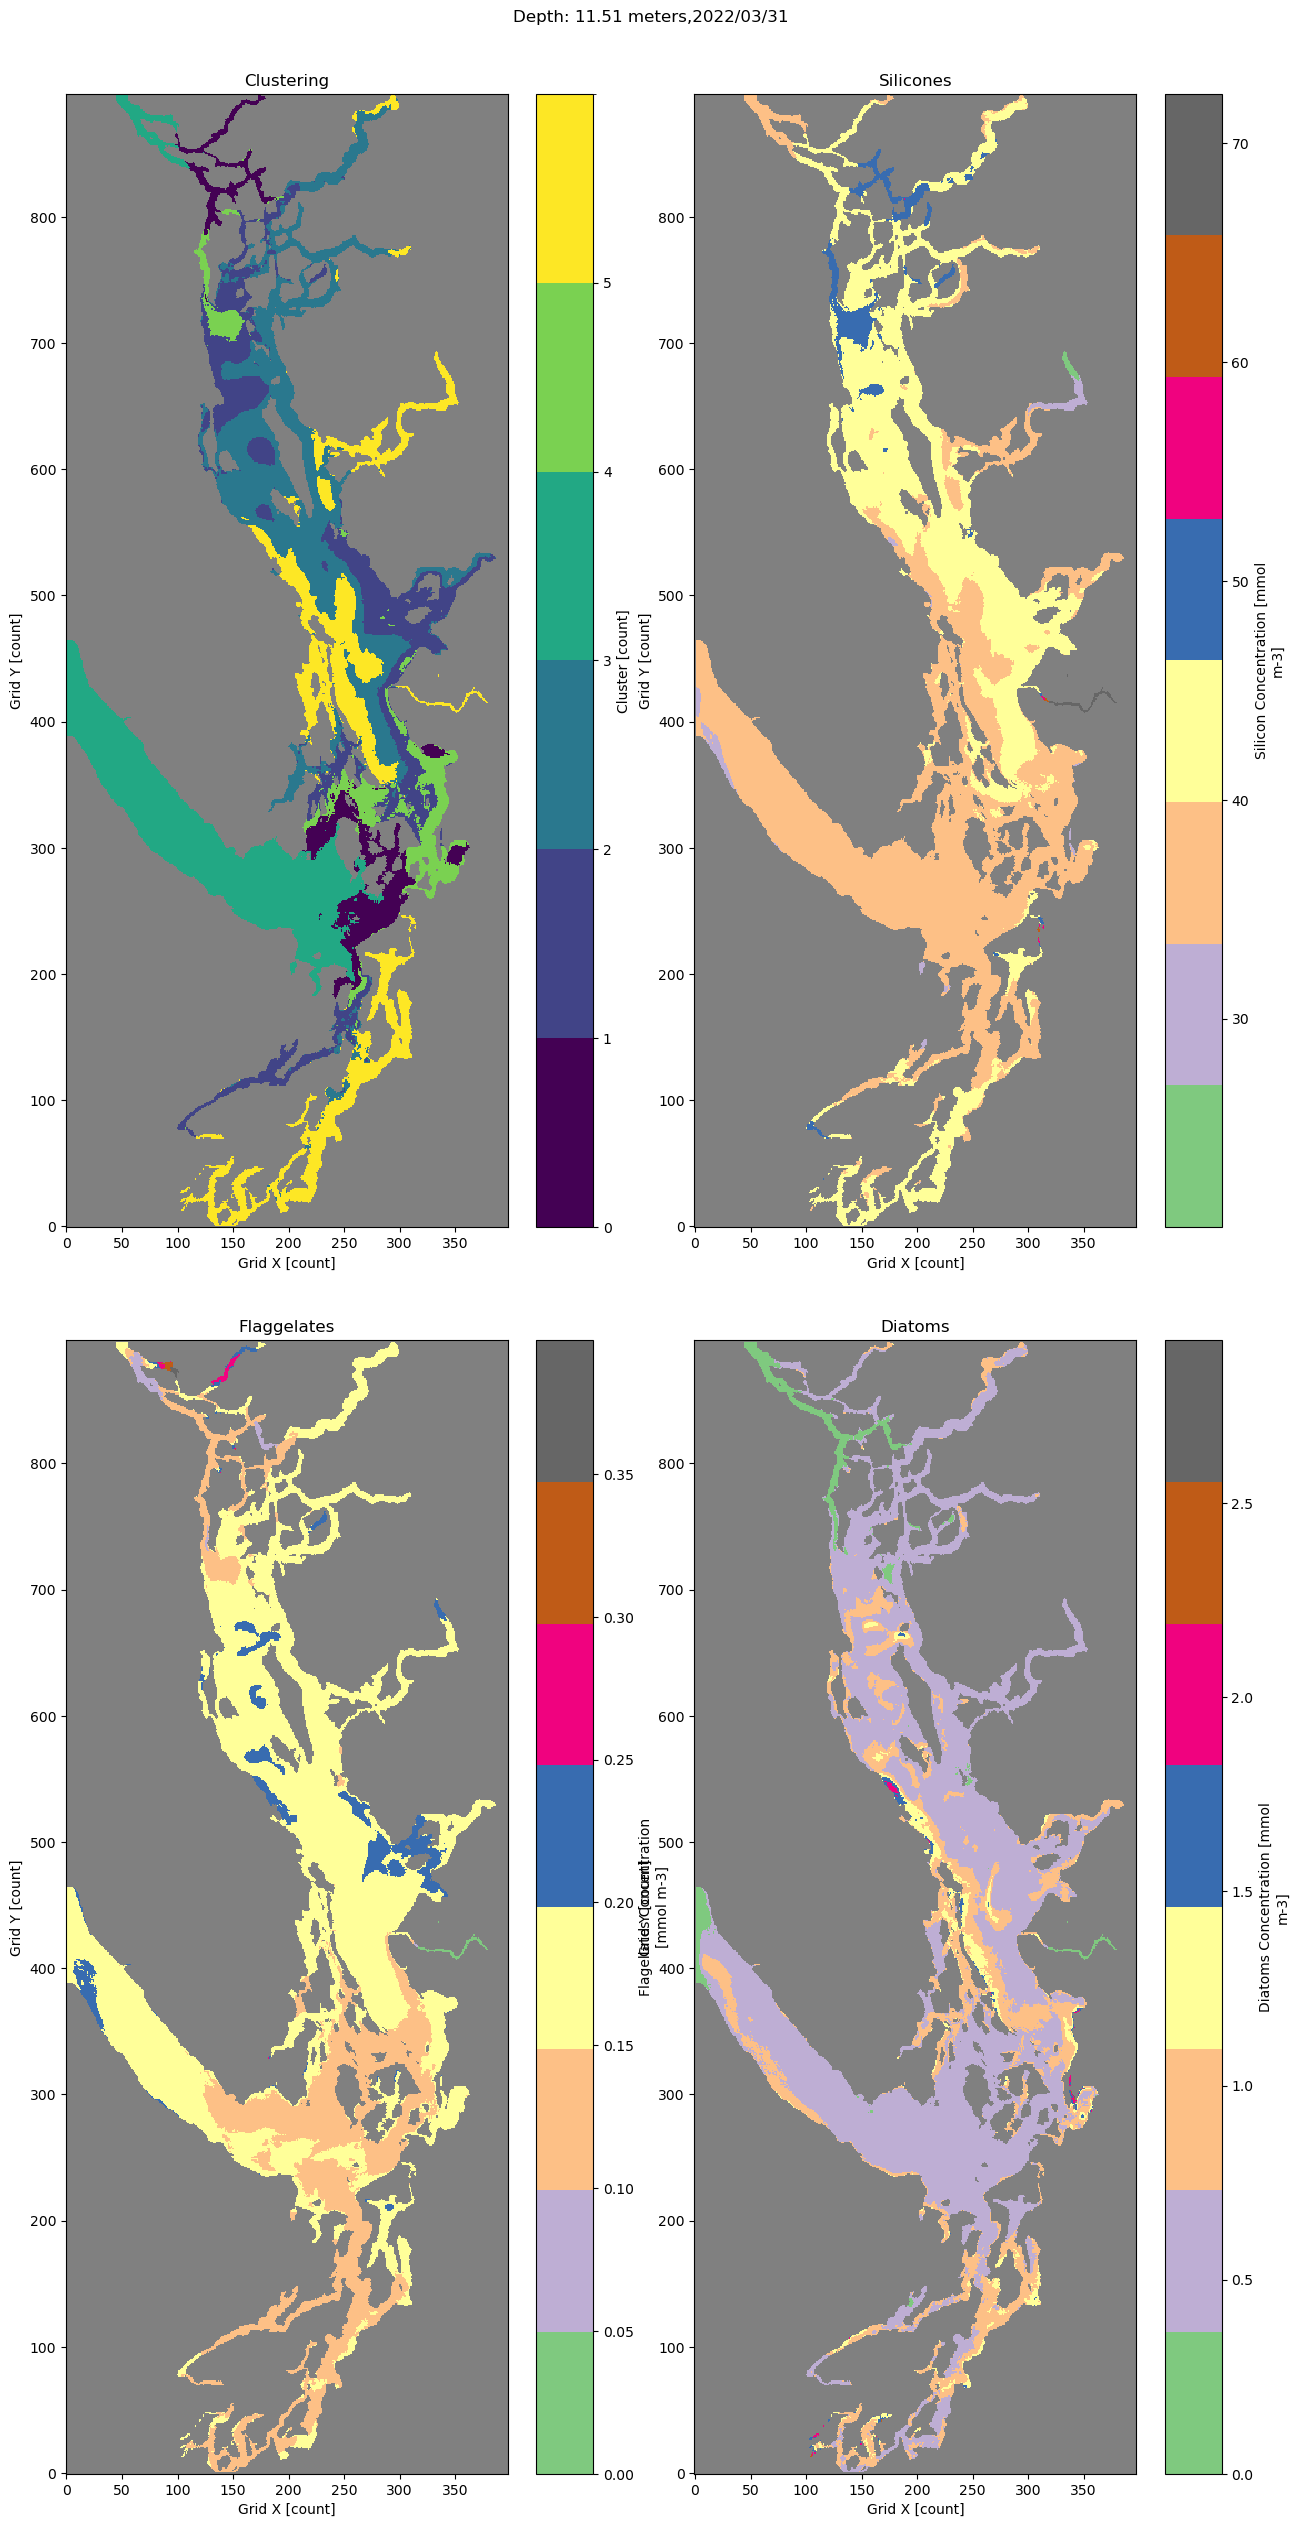

The amount of grid boxes for cluster 0 is 19390 

The minimum temperature for cluster 0 is 7.26 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 29.95 g/kg
The maximum salinity for cluster 0 is 31.64 g/kg
The mean salinity for cluster 0 is 30.77 g/kg 


The amount of grid boxes for cluster 1 is 4863 

The minimum temperature for cluster 1 is 7.54 degrees Celsius
The maximum temperature for cluster 1 is 8.62 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 29.19 g/kg
The maximum salinity for cluster 1 is 29.63 g/kg
The mean salinity for cluster 1 is 29.41 g/kg 


The amount of grid boxes for cluster 2 is 13447 

The minimum temperature for cluster 2 is 6.41 degrees Celsius
The maximum temperature for cluster 2 is 9.33 degrees Celsius
The mean temperature for cluster 2 is 8.13 degrees Celsius 

Th

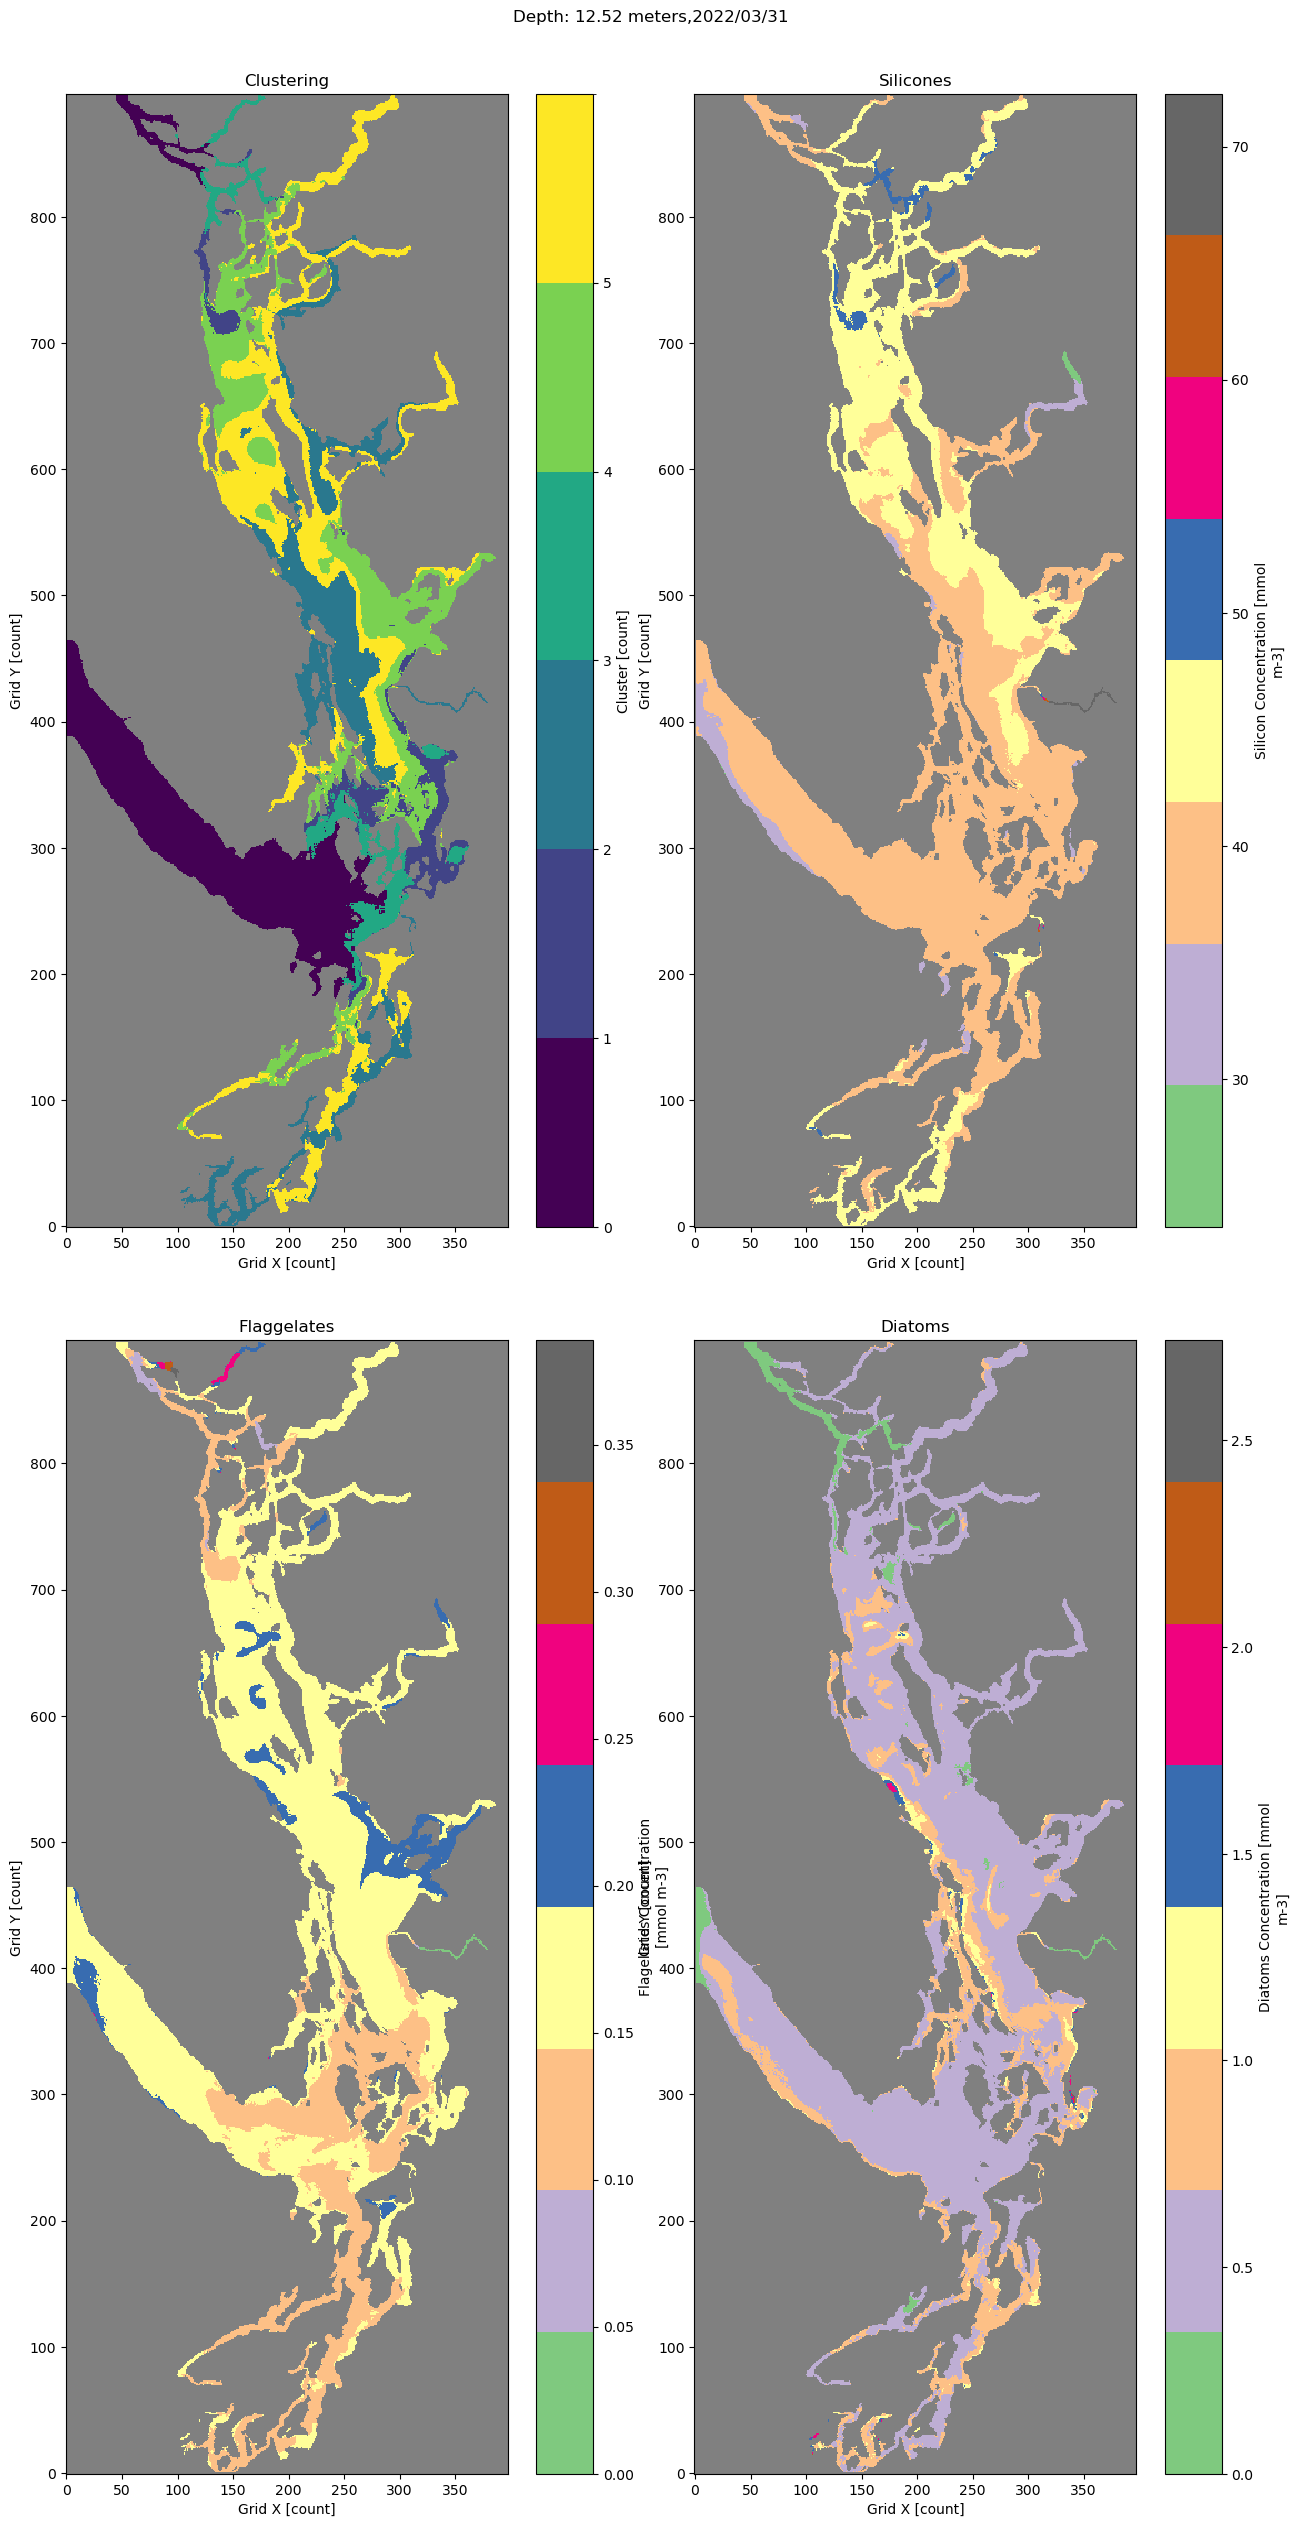

The amount of grid boxes for cluster 0 is 6633 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 10.22 degrees Celsius
The mean temperature for cluster 0 is 8.5 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.65 g/kg
The mean salinity for cluster 0 is 27.62 g/kg 


The amount of grid boxes for cluster 1 is 18604 

The minimum temperature for cluster 1 is 7.78 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 8.35 degrees Celsius 

The minimum salinity for cluster 1 is 28.6 g/kg
The maximum salinity for cluster 1 is 29.46 g/kg
The mean salinity for cluster 1 is 29.01 g/kg 


The amount of grid boxes for cluster 2 is 5147 

The minimum temperature for cluster 2 is 6.56 degrees Celsius
The maximum temperature for cluster 2 is 8.65 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The m

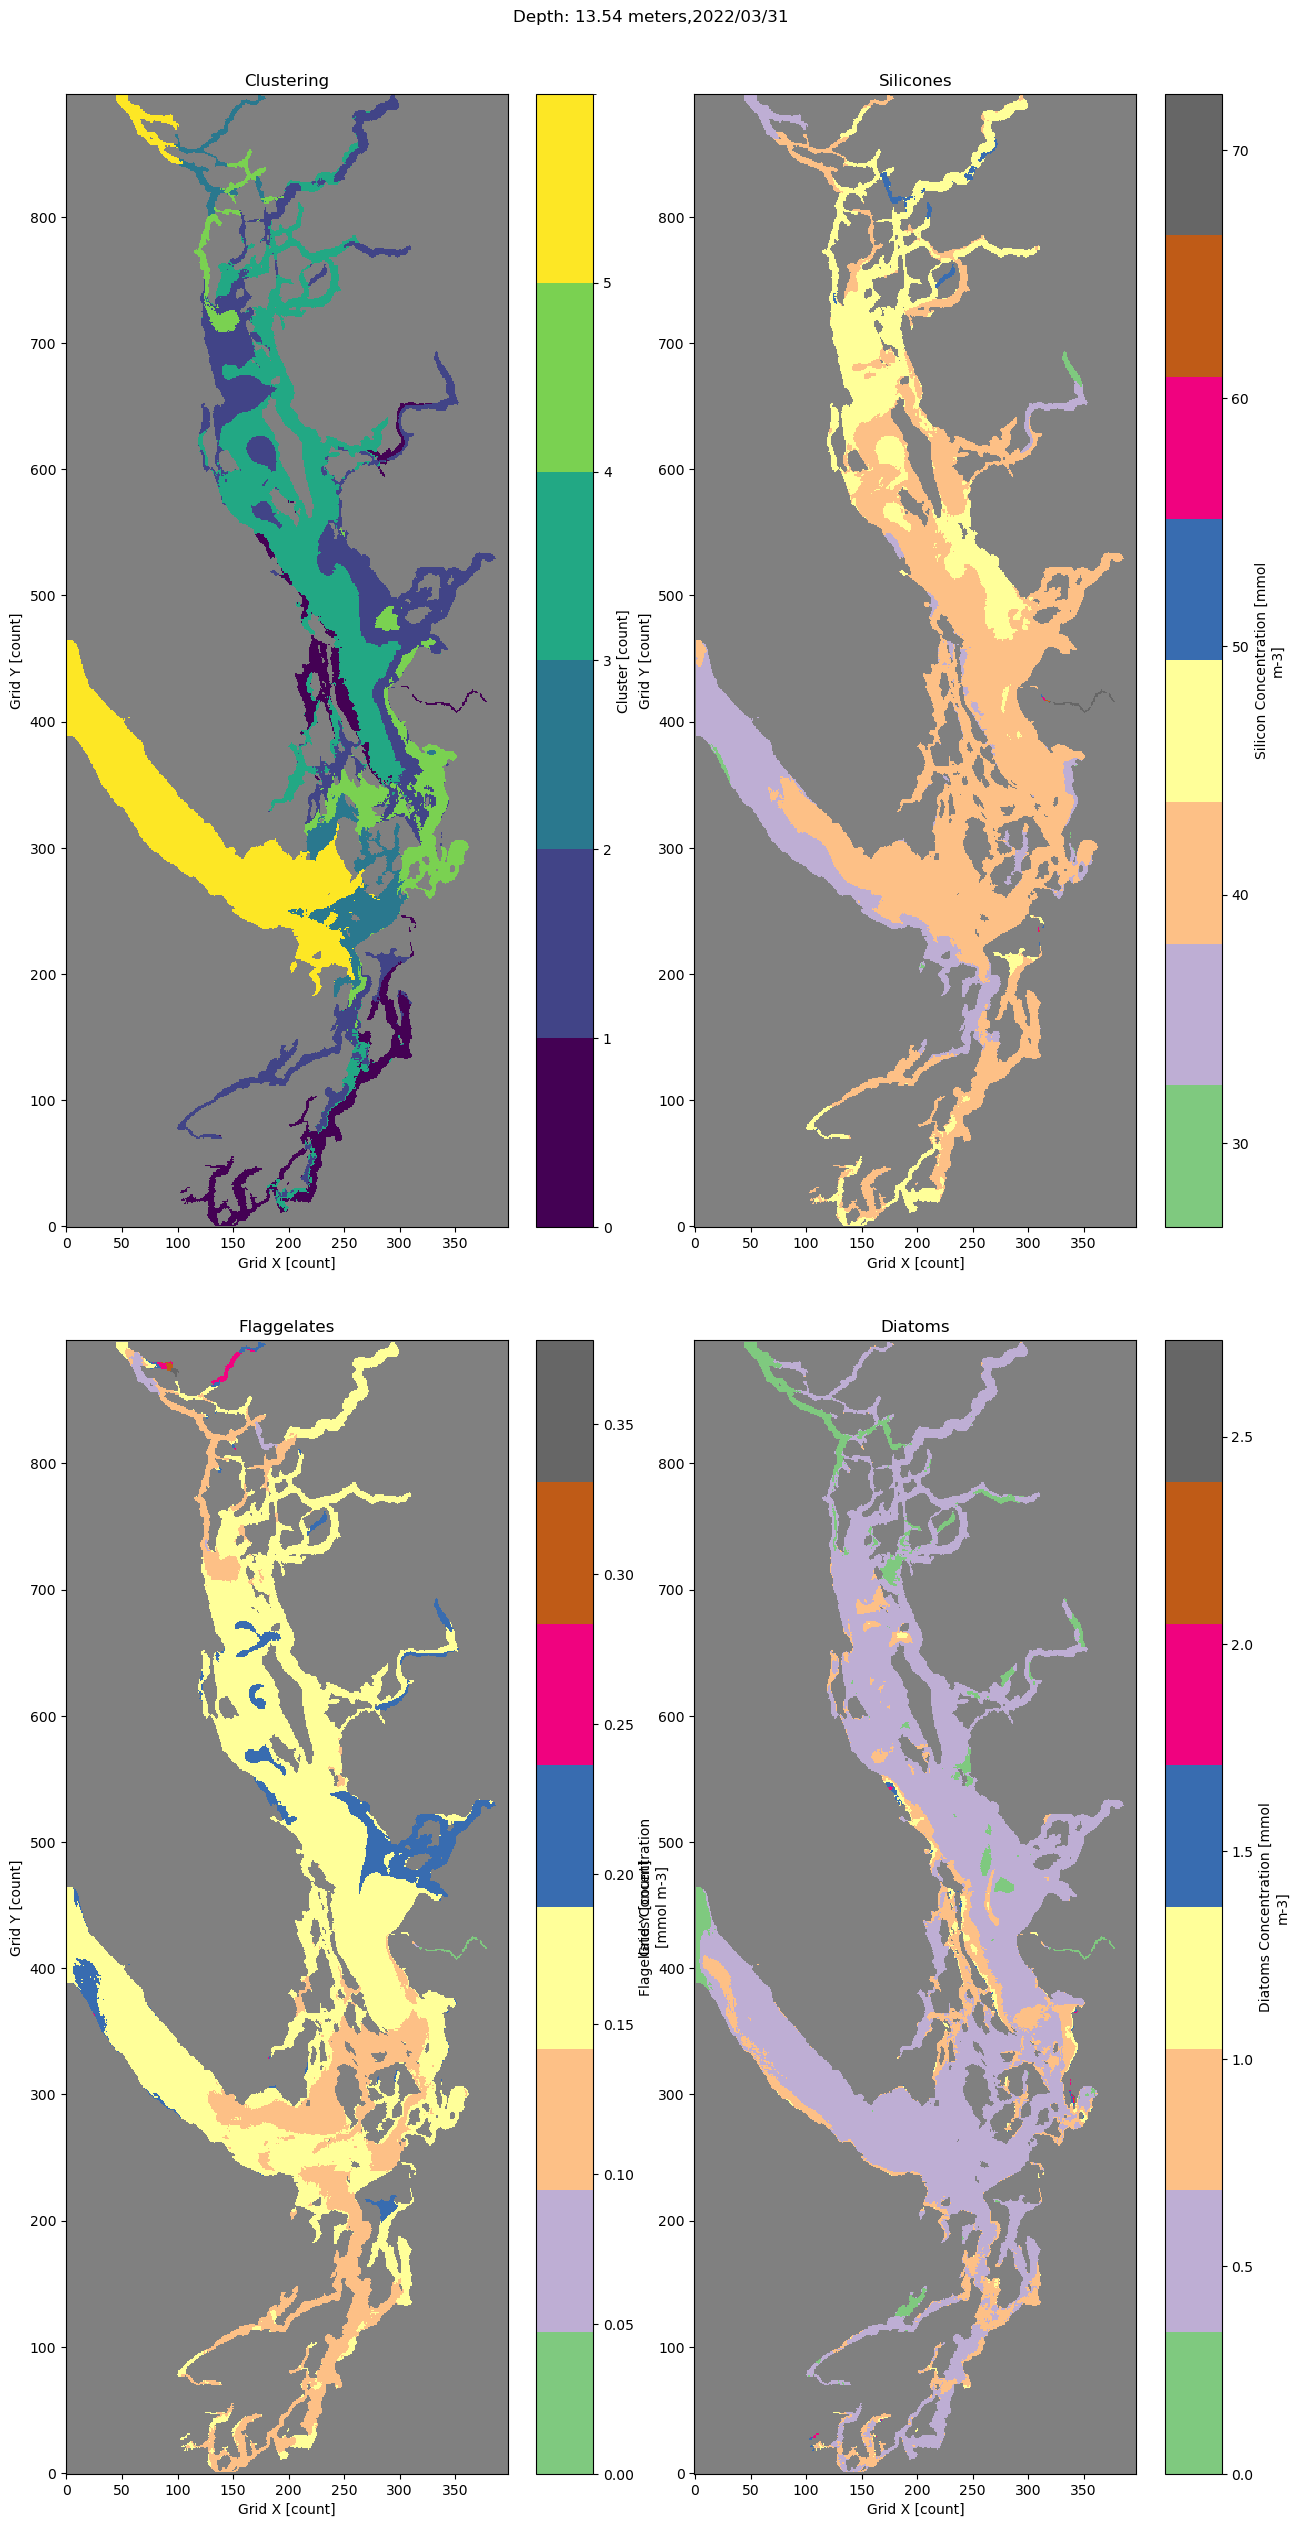

The amount of grid boxes for cluster 0 is 22948 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.26 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 28.31 g/kg
The maximum salinity for cluster 0 is 29.15 g/kg
The mean salinity for cluster 0 is 28.79 g/kg 


The amount of grid boxes for cluster 1 is 8383 

The minimum temperature for cluster 1 is 7.53 degrees Celsius
The maximum temperature for cluster 1 is 8.41 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 29.15 g/kg
The maximum salinity for cluster 1 is 29.76 g/kg
The mean salinity for cluster 1 is 29.4 g/kg 


The amount of grid boxes for cluster 2 is 18862 

The minimum temperature for cluster 2 is 6.68 degrees Celsius
The maximum temperature for cluster 2 is 8.27 degrees Celsius
The mean temperature for cluster 2 is 7.82 degrees Celsius 

The 

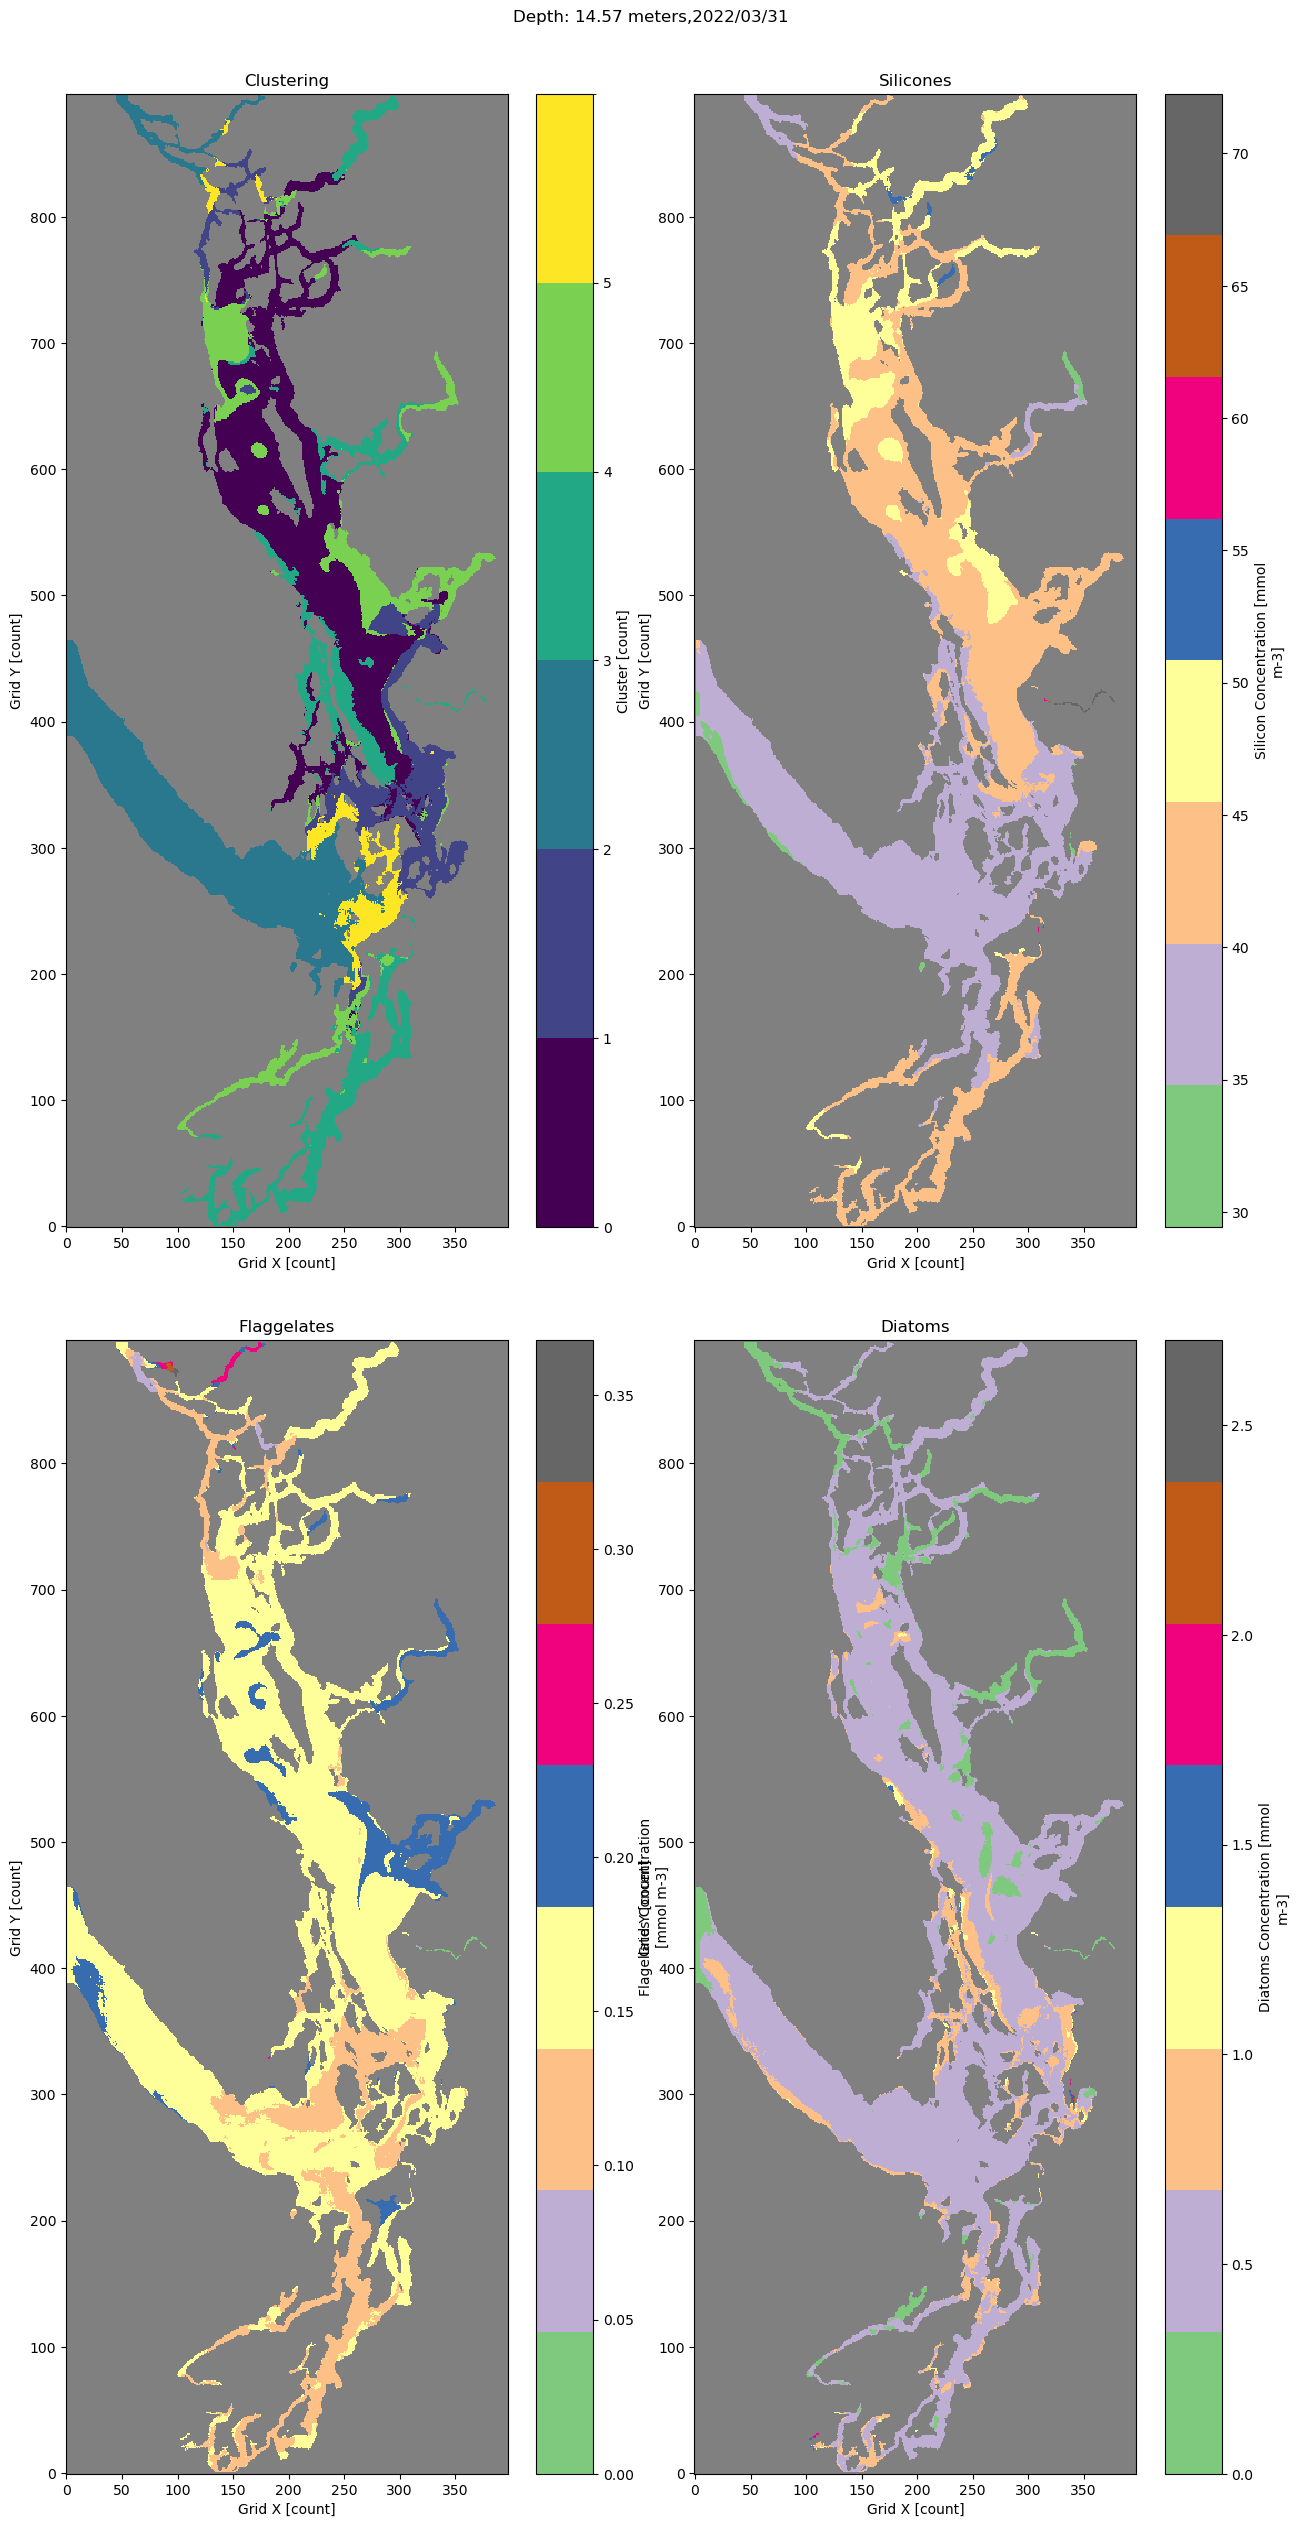

The amount of grid boxes for cluster 0 is 24291 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 9.15 degrees Celsius
The mean temperature for cluster 0 is 7.98 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.02 g/kg
The mean salinity for cluster 0 is 28.59 g/kg 


The amount of grid boxes for cluster 1 is 14229 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.48 degrees Celsius
The mean temperature for cluster 1 is 8.13 degrees Celsius 

The minimum salinity for cluster 1 is 28.98 g/kg
The maximum salinity for cluster 1 is 29.52 g/kg
The mean salinity for cluster 1 is 29.22 g/kg 


The amount of grid boxes for cluster 2 is 5149 

The minimum temperature for cluster 2 is 6.8 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

The m

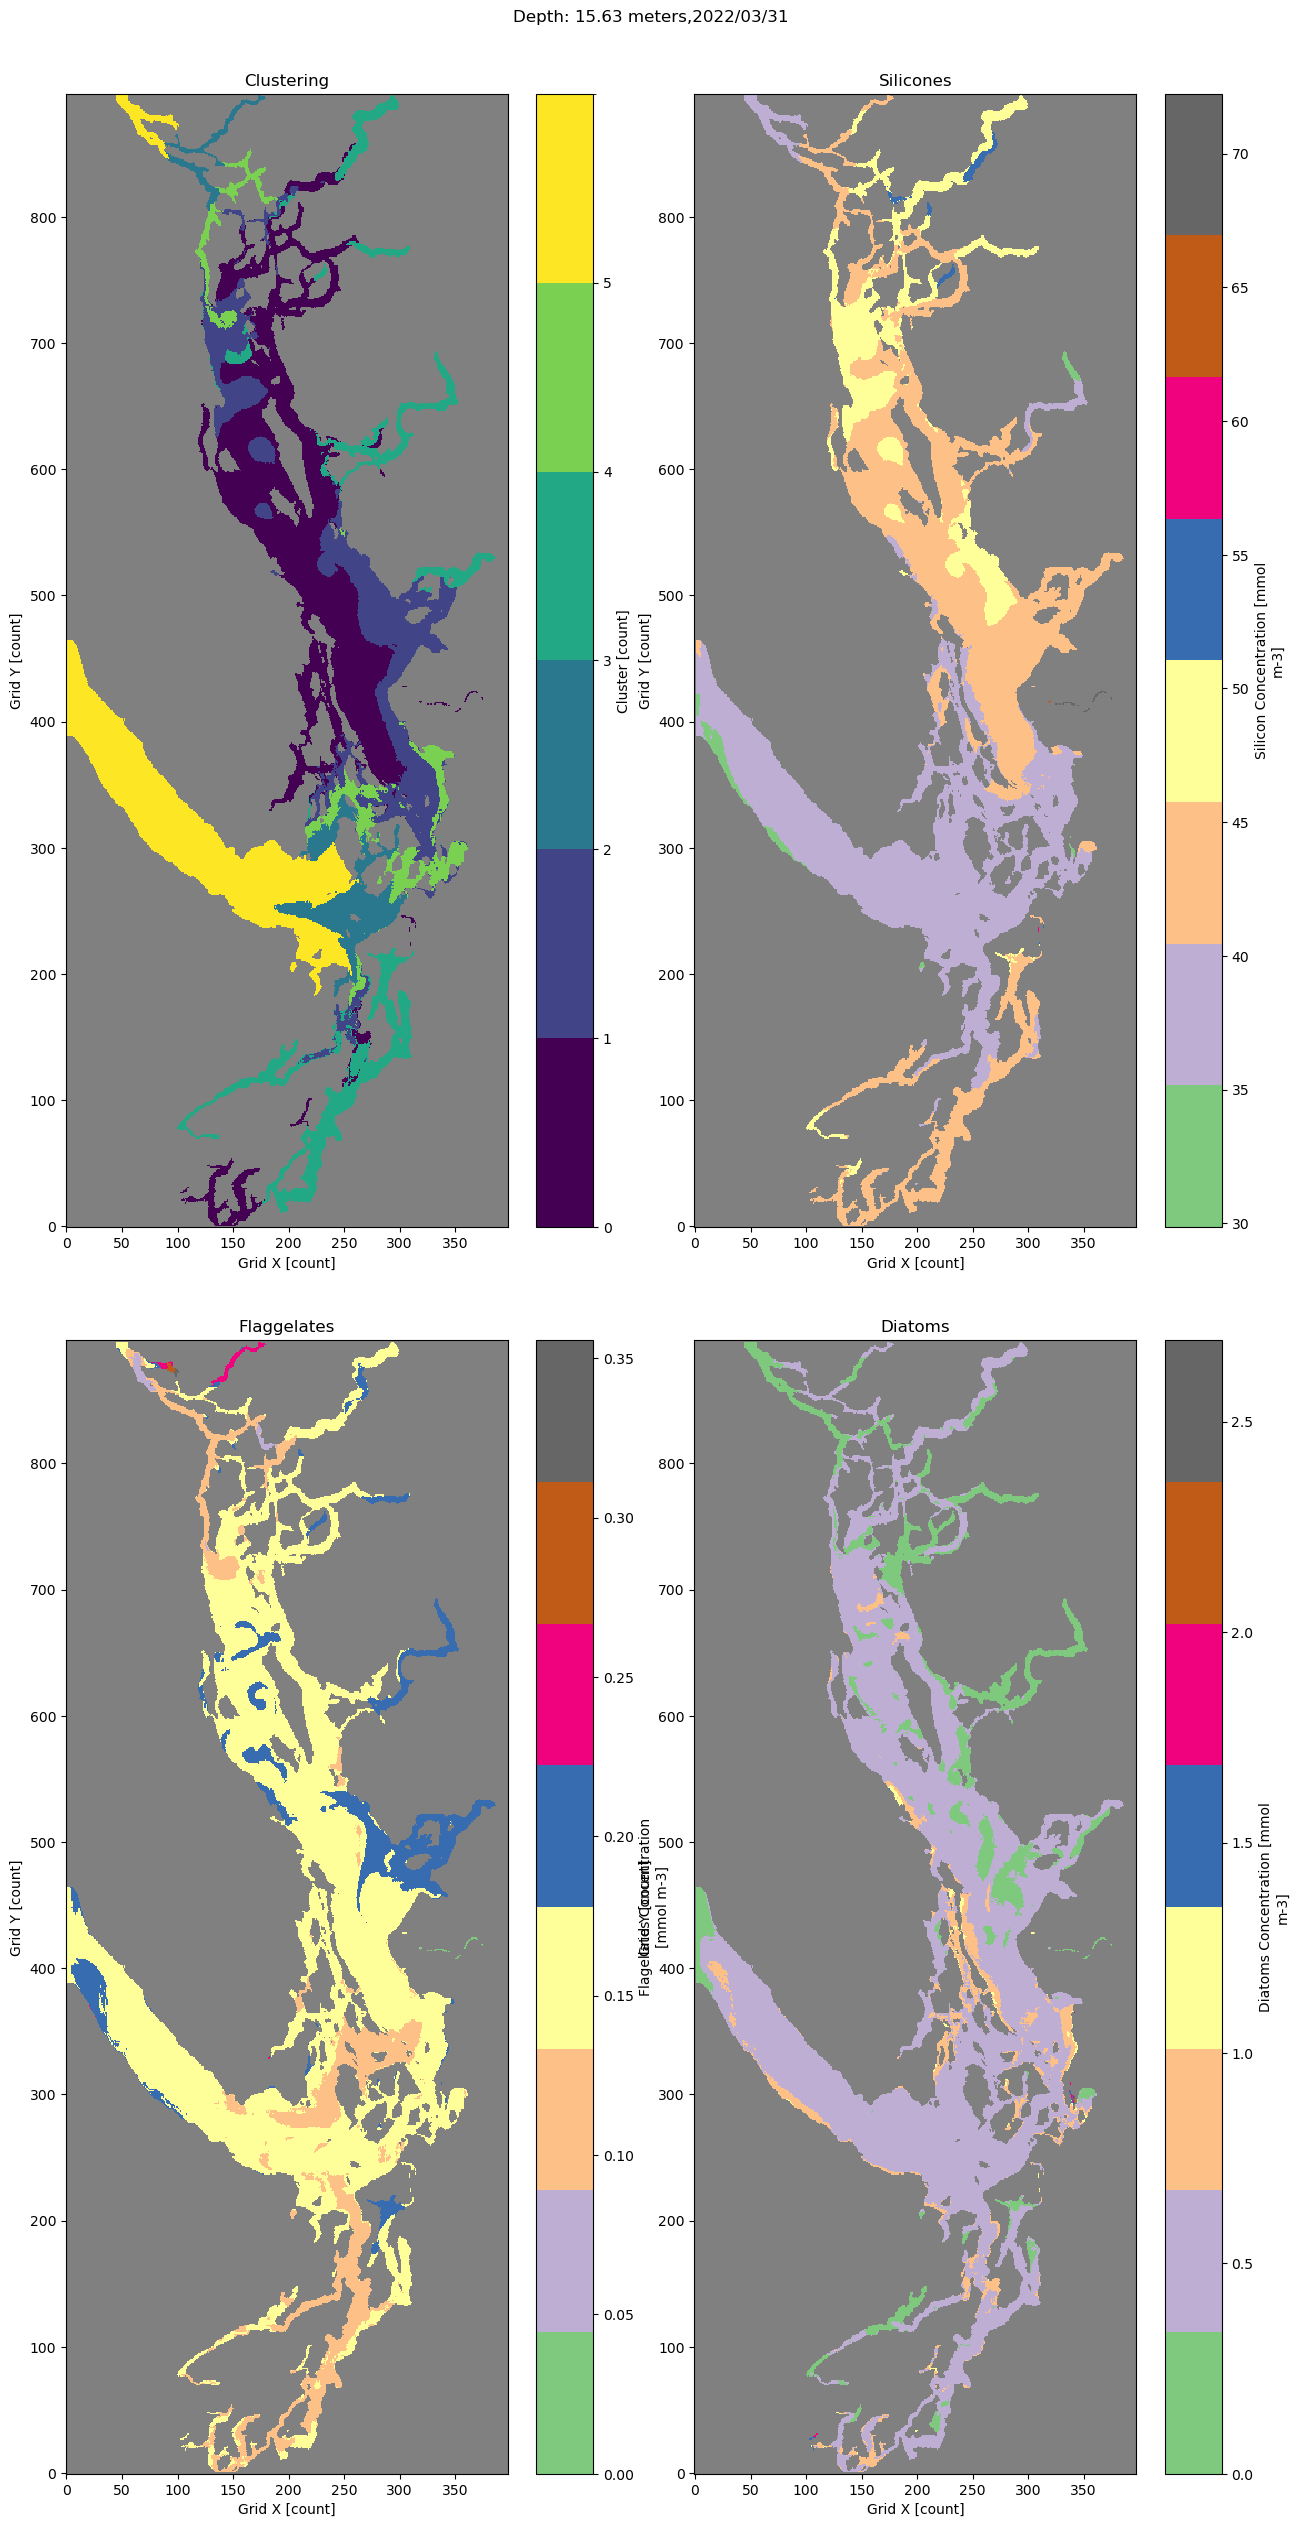

The amount of grid boxes for cluster 0 is 14385 

The minimum temperature for cluster 0 is 8.11 degrees Celsius
The maximum temperature for cluster 0 is 10.49 degrees Celsius
The mean temperature for cluster 0 is 8.66 degrees Celsius 

The minimum salinity for cluster 0 is 28.06 g/kg
The maximum salinity for cluster 0 is 29.64 g/kg
The mean salinity for cluster 0 is 29.04 g/kg 


The amount of grid boxes for cluster 1 is 5842 

The minimum temperature for cluster 1 is 7.23 degrees Celsius
The maximum temperature for cluster 1 is 8.66 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.45 g/kg
The maximum salinity for cluster 1 is 30.06 g/kg
The mean salinity for cluster 1 is 29.74 g/kg 


The amount of grid boxes for cluster 2 is 13599 

The minimum temperature for cluster 2 is 7.17 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.79 degrees Celsius 

T

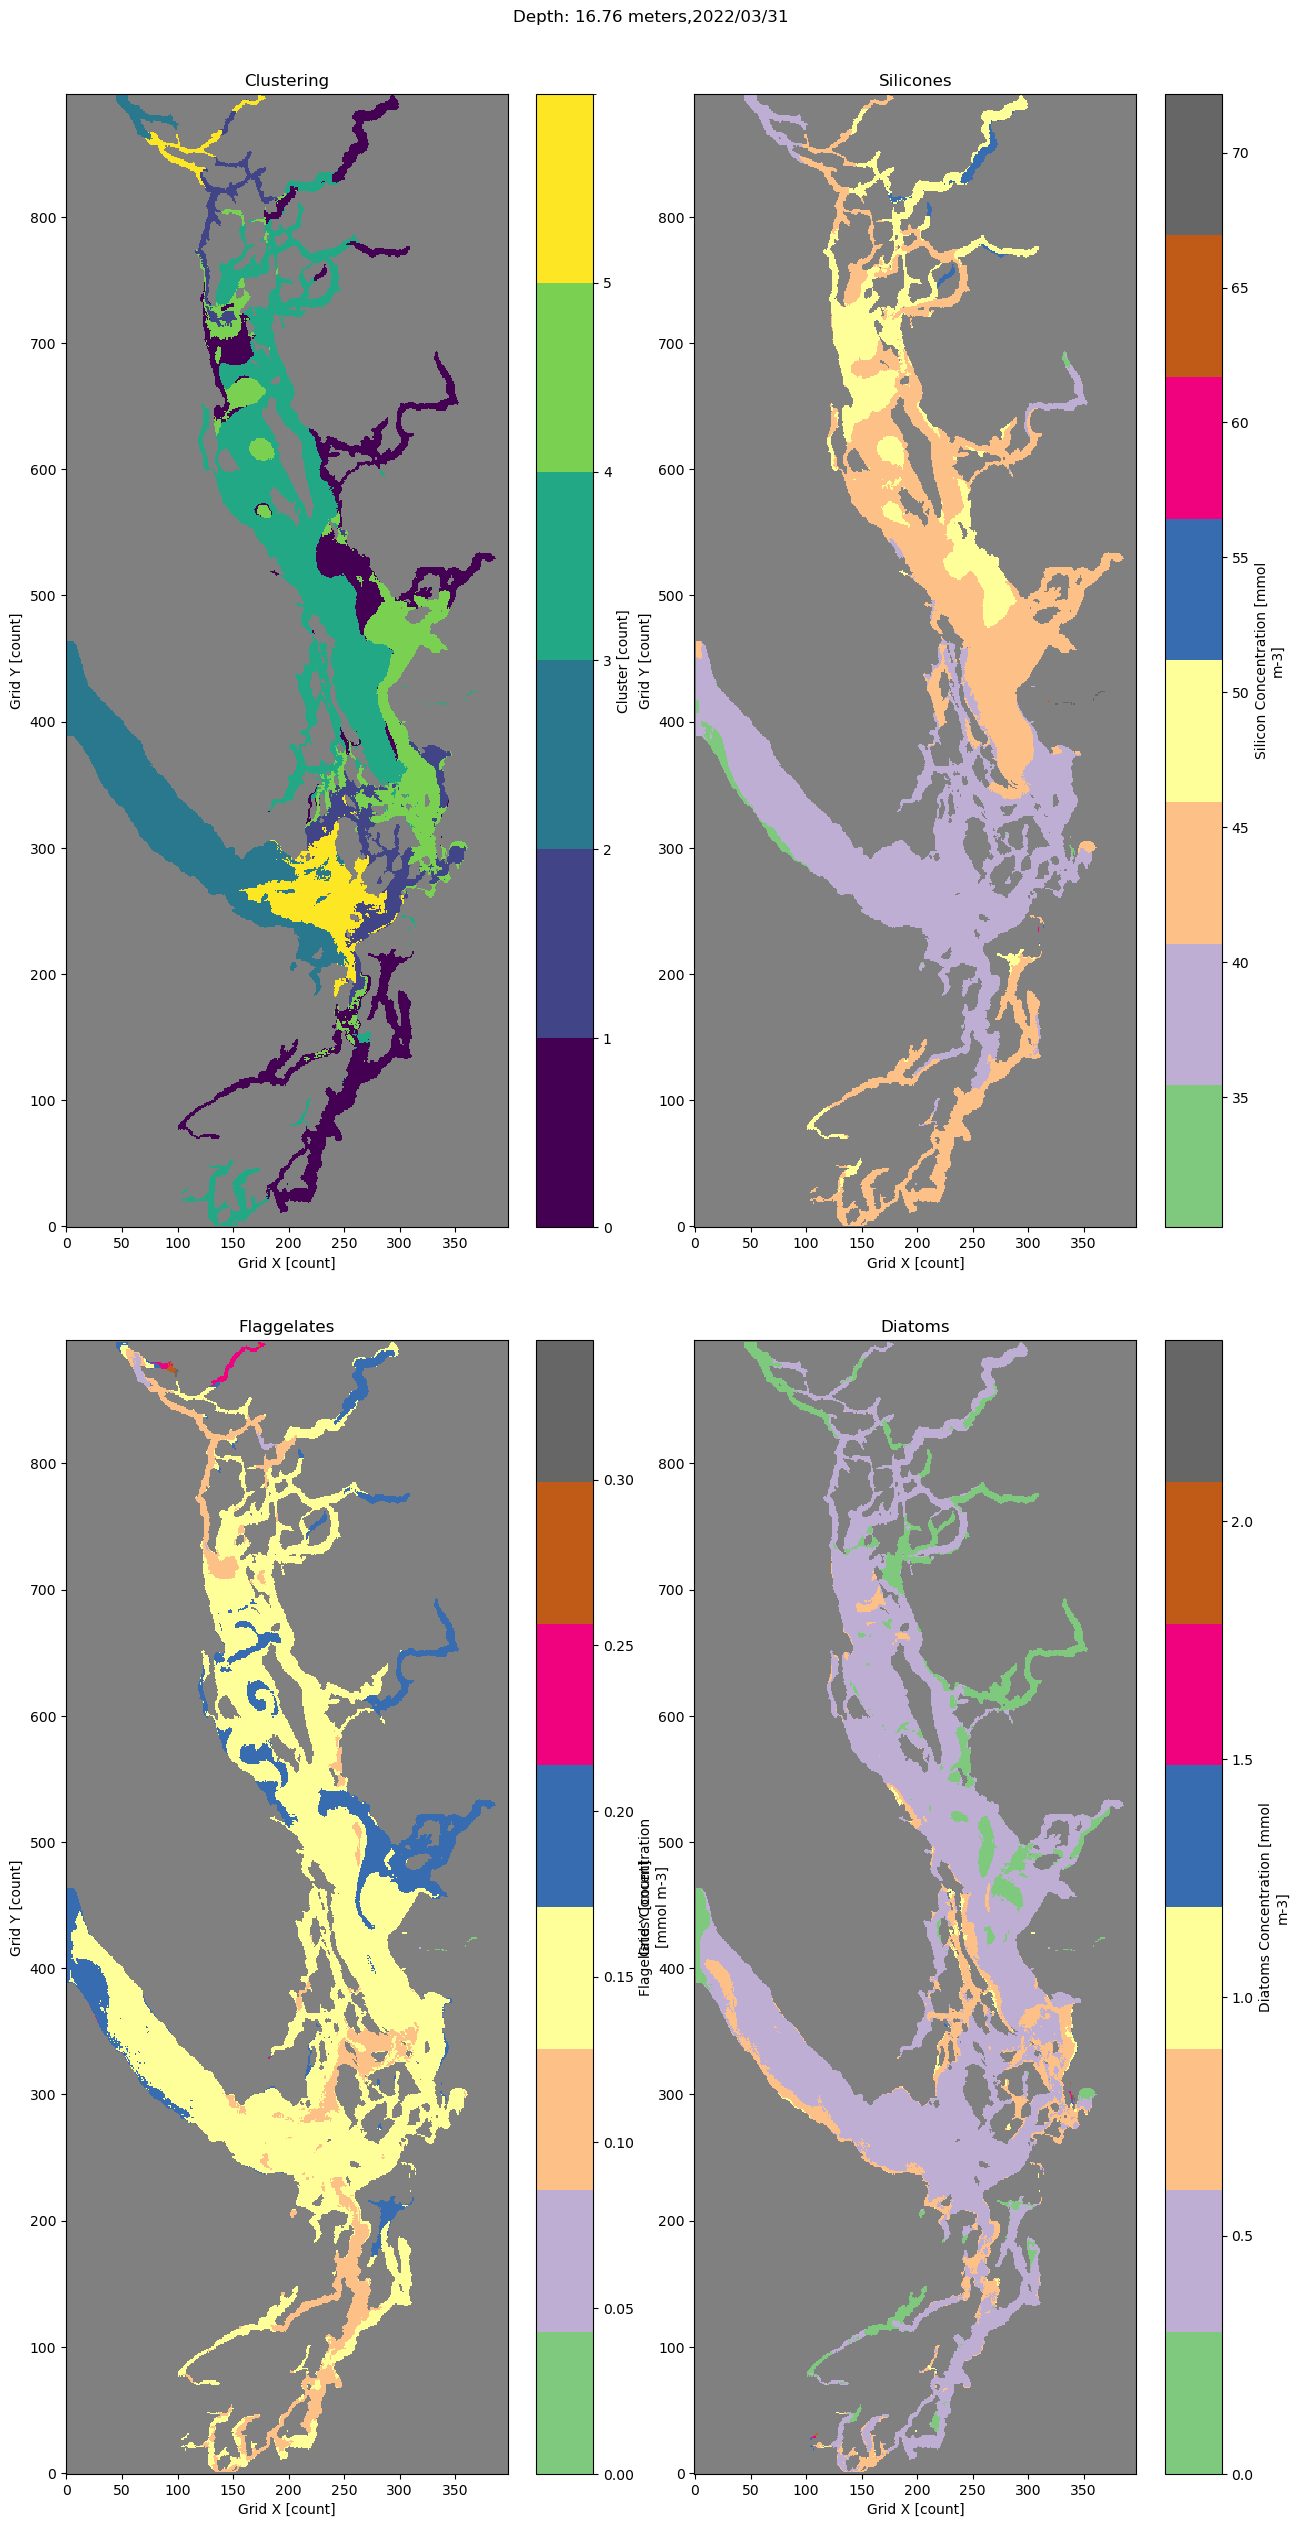

The amount of grid boxes for cluster 0 is 16215 

The minimum temperature for cluster 0 is 7.16 degrees Celsius
The maximum temperature for cluster 0 is 8.22 degrees Celsius
The mean temperature for cluster 0 is 7.79 degrees Celsius 

The minimum salinity for cluster 0 is 30.32 g/kg
The maximum salinity for cluster 0 is 31.89 g/kg
The mean salinity for cluster 0 is 30.97 g/kg 


The amount of grid boxes for cluster 1 is 6984 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.32 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.2 g/kg
The maximum salinity for cluster 1 is 29.9 g/kg
The mean salinity for cluster 1 is 29.53 g/kg 


The amount of grid boxes for cluster 2 is 24991 

The minimum temperature for cluster 2 is 6.48 degrees Celsius
The maximum temperature for cluster 2 is 9.13 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

The 

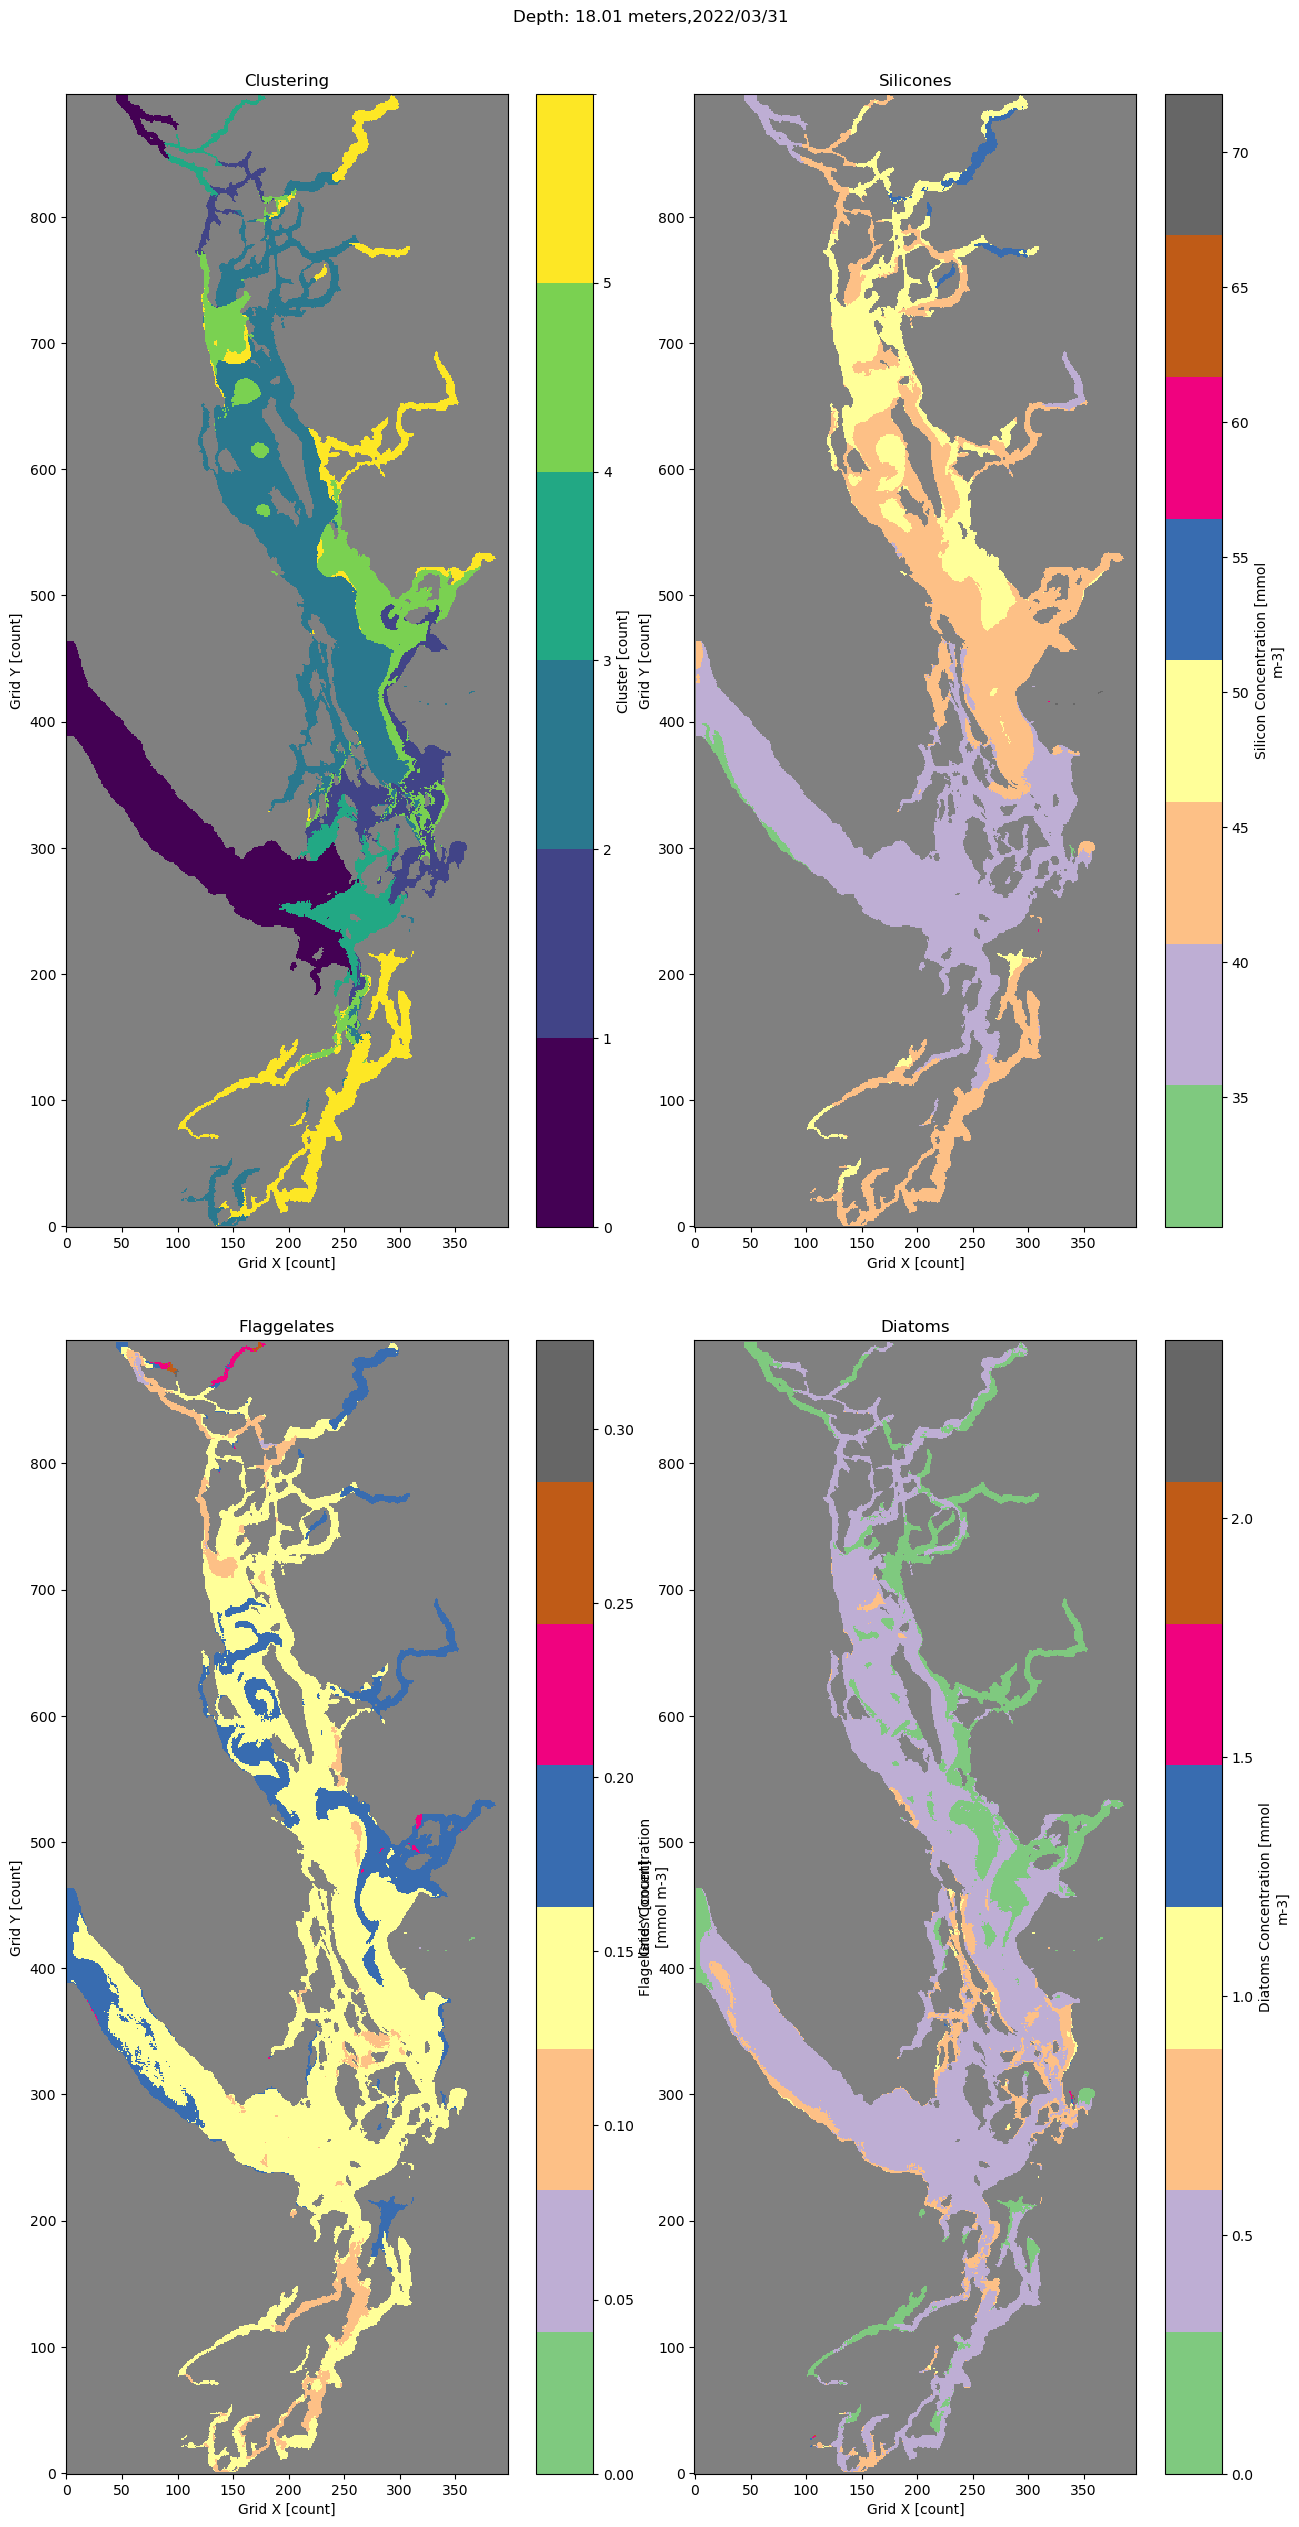

The amount of grid boxes for cluster 0 is 23461 

The minimum temperature for cluster 0 is 6.49 degrees Celsius
The maximum temperature for cluster 0 is 9.13 degrees Celsius
The mean temperature for cluster 0 is 8.01 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.18 g/kg
The mean salinity for cluster 0 is 28.82 g/kg 


The amount of grid boxes for cluster 1 is 12038 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.42 degrees Celsius
The mean temperature for cluster 1 is 8.1 degrees Celsius 

The minimum salinity for cluster 1 is 29.14 g/kg
The maximum salinity for cluster 1 is 29.63 g/kg
The mean salinity for cluster 1 is 29.35 g/kg 


The amount of grid boxes for cluster 2 is 4828 

The minimum temperature for cluster 2 is 7.24 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.85 degrees Celsius 

The m

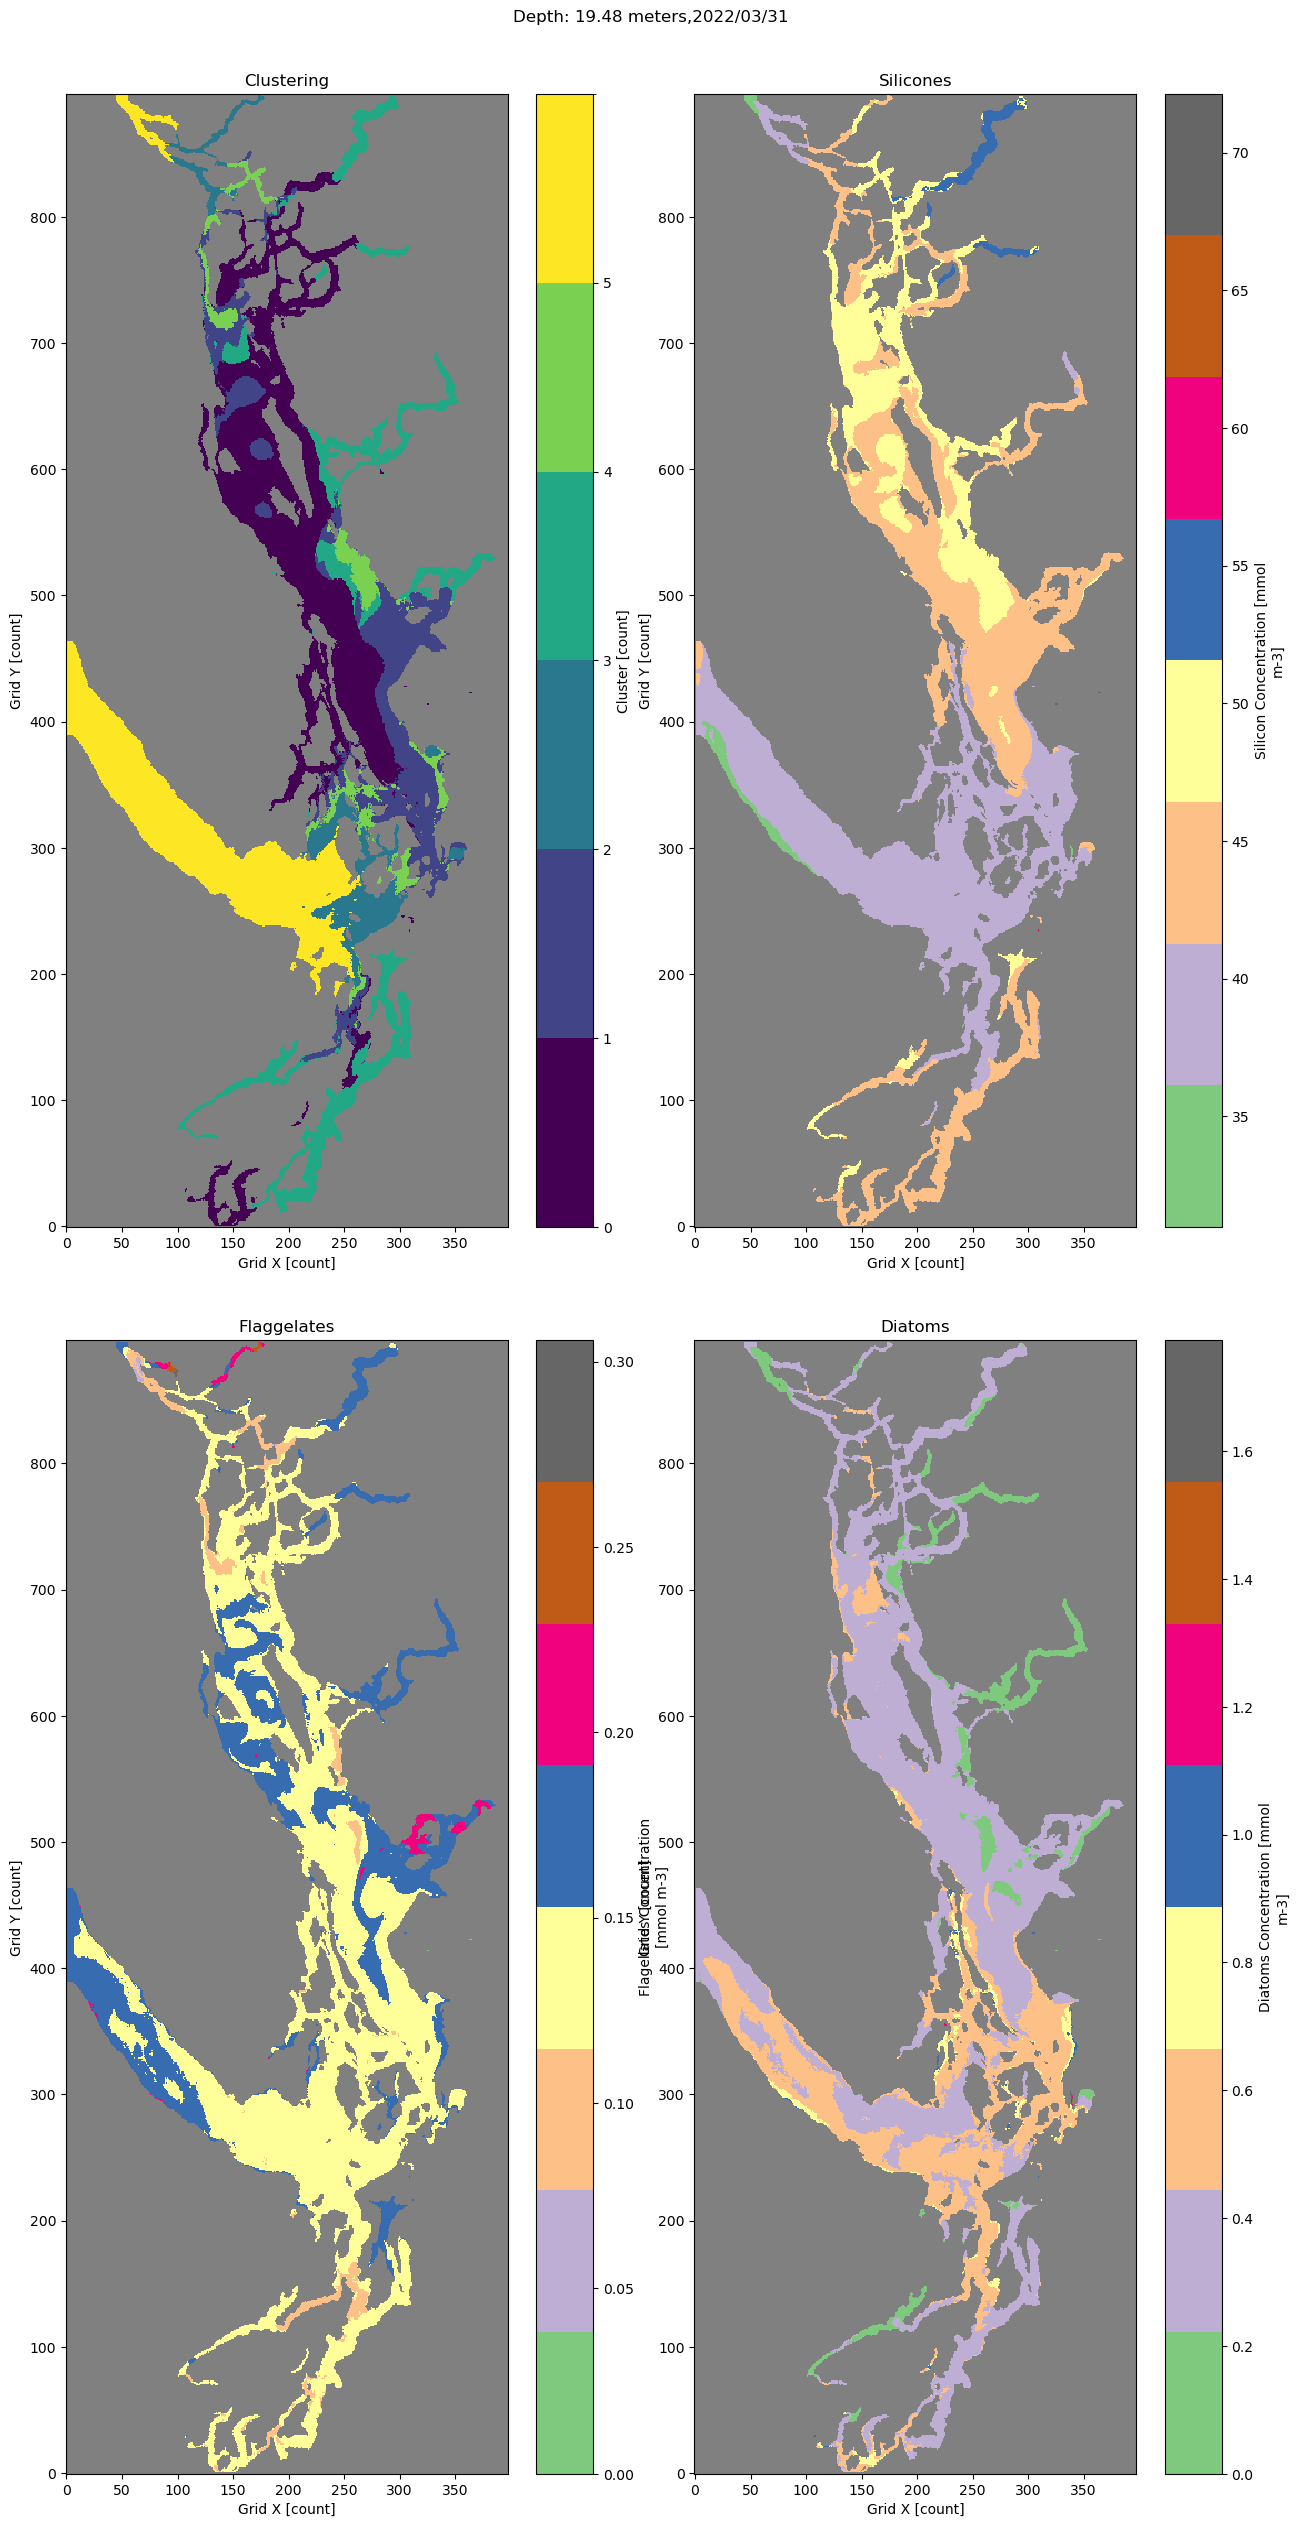

The amount of grid boxes for cluster 0 is 4979 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.14 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 29.8 g/kg
The maximum salinity for cluster 0 is 30.51 g/kg
The mean salinity for cluster 0 is 30.19 g/kg 


The amount of grid boxes for cluster 1 is 11749 

The minimum temperature for cluster 1 is 7.59 degrees Celsius
The maximum temperature for cluster 1 is 8.37 degrees Celsius
The mean temperature for cluster 1 is 8.07 degrees Celsius 

The minimum salinity for cluster 1 is 29.11 g/kg
The maximum salinity for cluster 1 is 29.64 g/kg
The mean salinity for cluster 1 is 29.39 g/kg 


The amount of grid boxes for cluster 2 is 22653 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

The

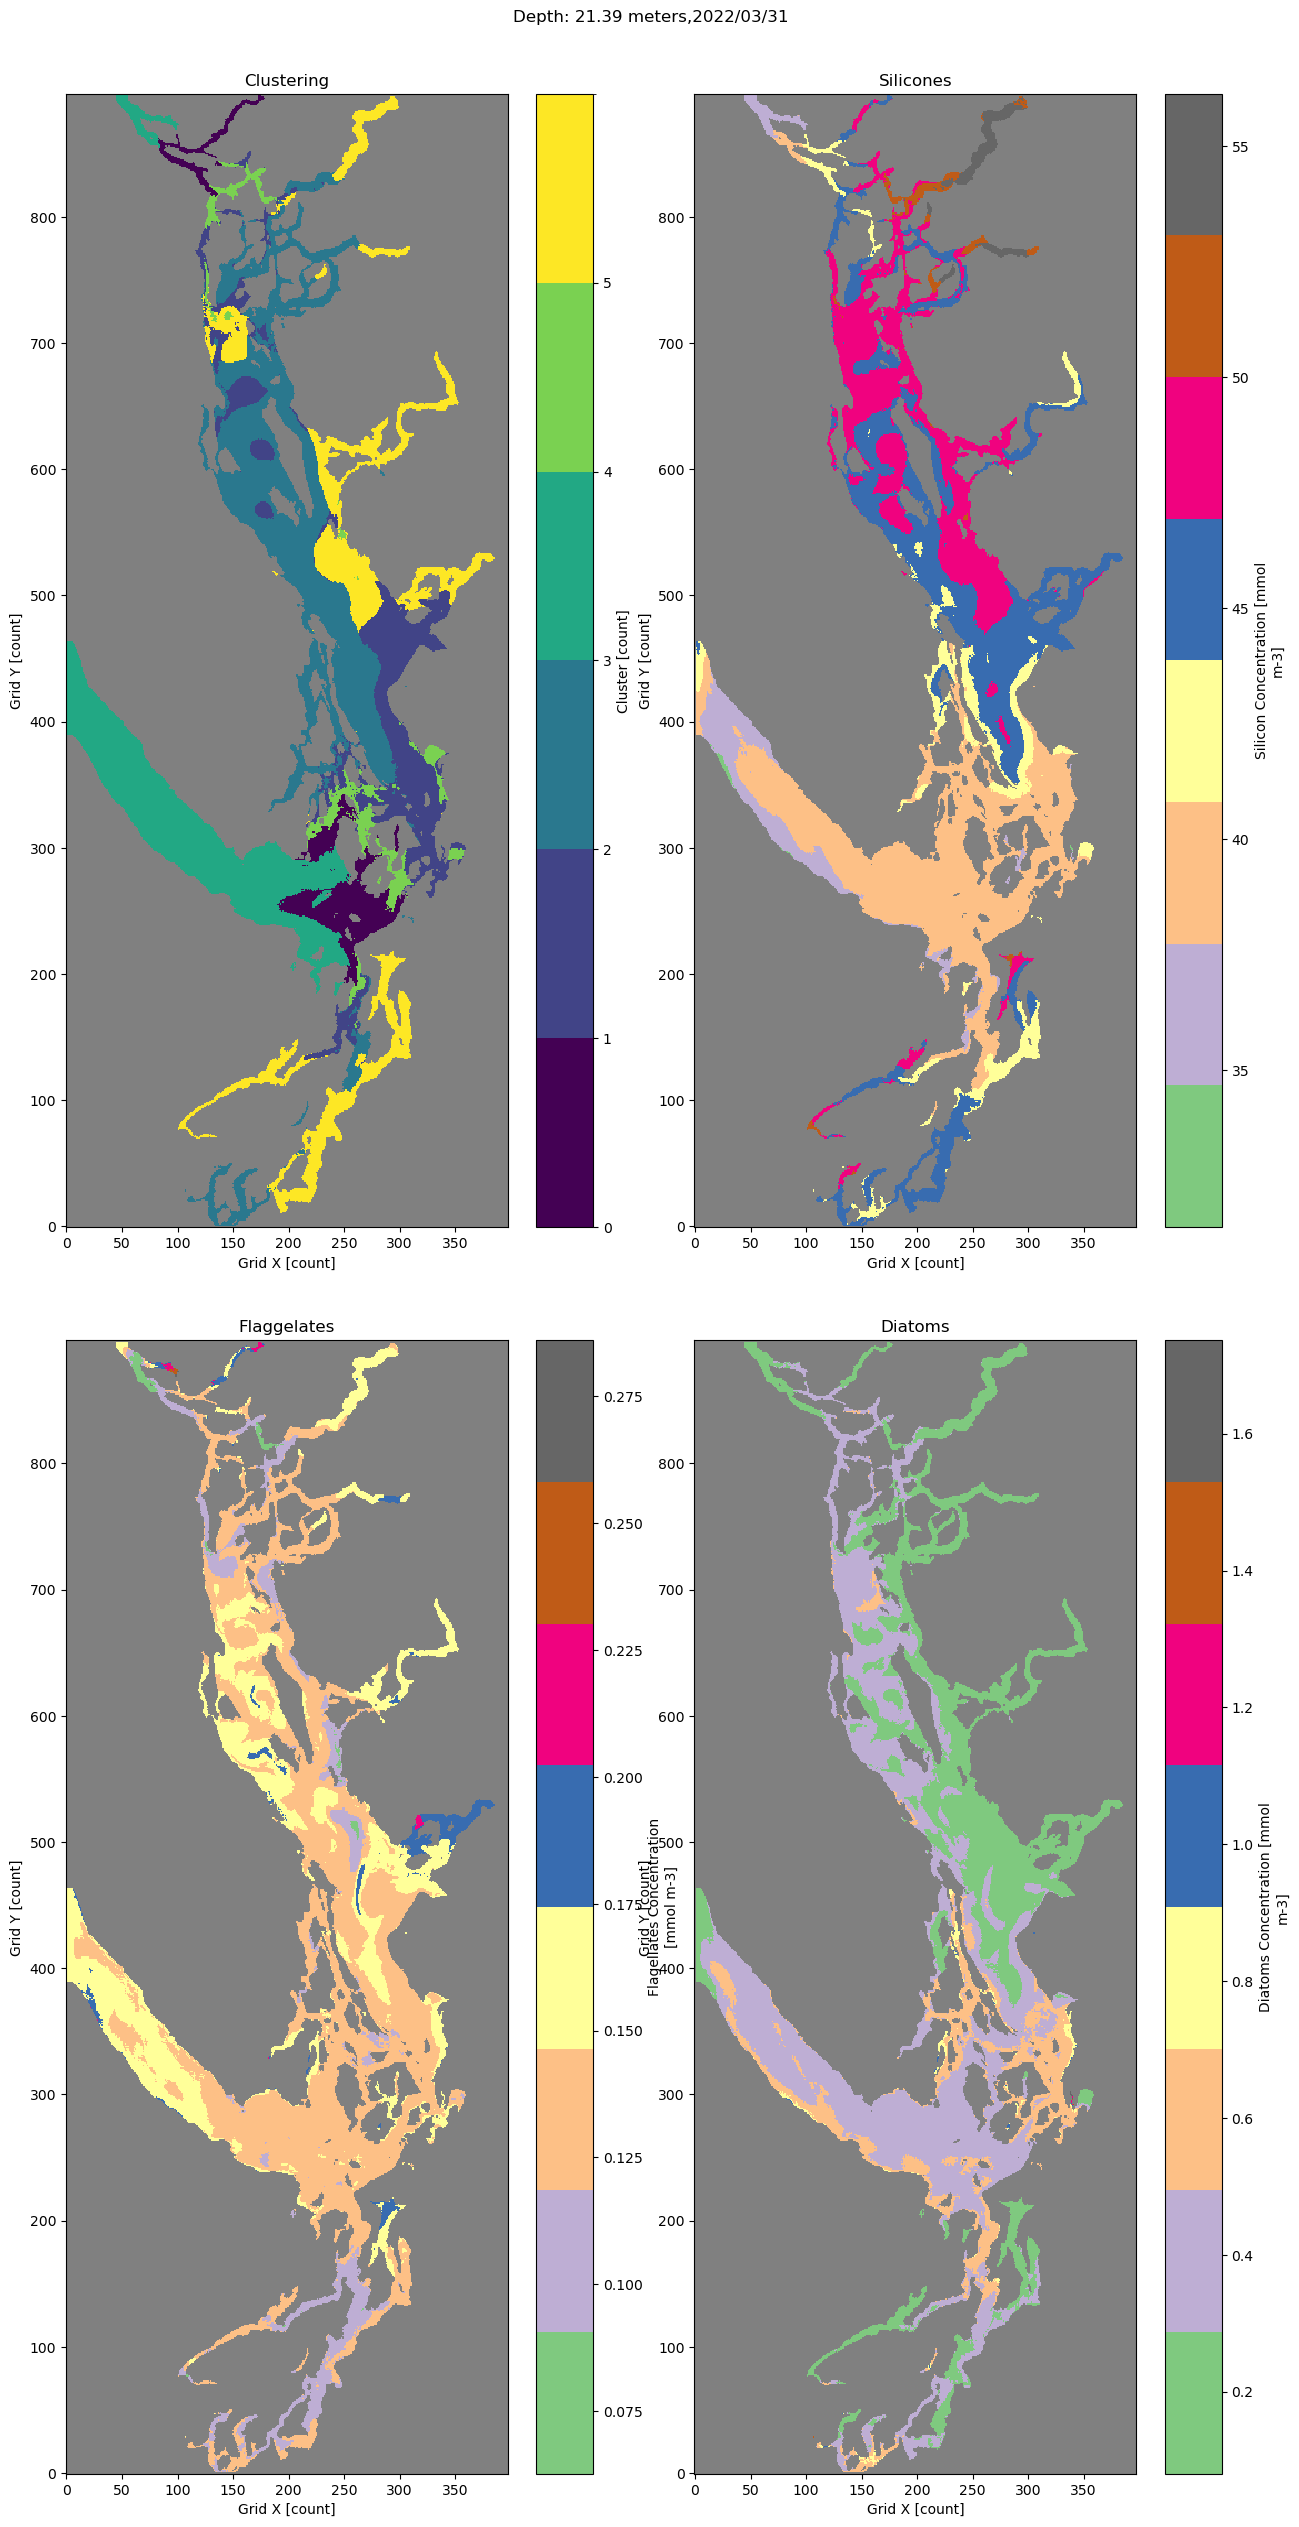

The amount of grid boxes for cluster 0 is 14893 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 8.13 degrees Celsius
The mean temperature for cluster 0 is 7.73 degrees Celsius 

The minimum salinity for cluster 0 is 30.52 g/kg
The maximum salinity for cluster 0 is 32.22 g/kg
The mean salinity for cluster 0 is 31.11 g/kg 


The amount of grid boxes for cluster 1 is 2016 

The minimum temperature for cluster 1 is 7.68 degrees Celsius
The maximum temperature for cluster 1 is 8.68 degrees Celsius
The mean temperature for cluster 1 is 7.95 degrees Celsius 

The minimum salinity for cluster 1 is 29.65 g/kg
The maximum salinity for cluster 1 is 30.14 g/kg
The mean salinity for cluster 1 is 29.85 g/kg 


The amount of grid boxes for cluster 2 is 12502 

The minimum temperature for cluster 2 is 8.28 degrees Celsius
The maximum temperature for cluster 2 is 10.2 degrees Celsius
The mean temperature for cluster 2 is 8.81 degrees Celsius 

Th

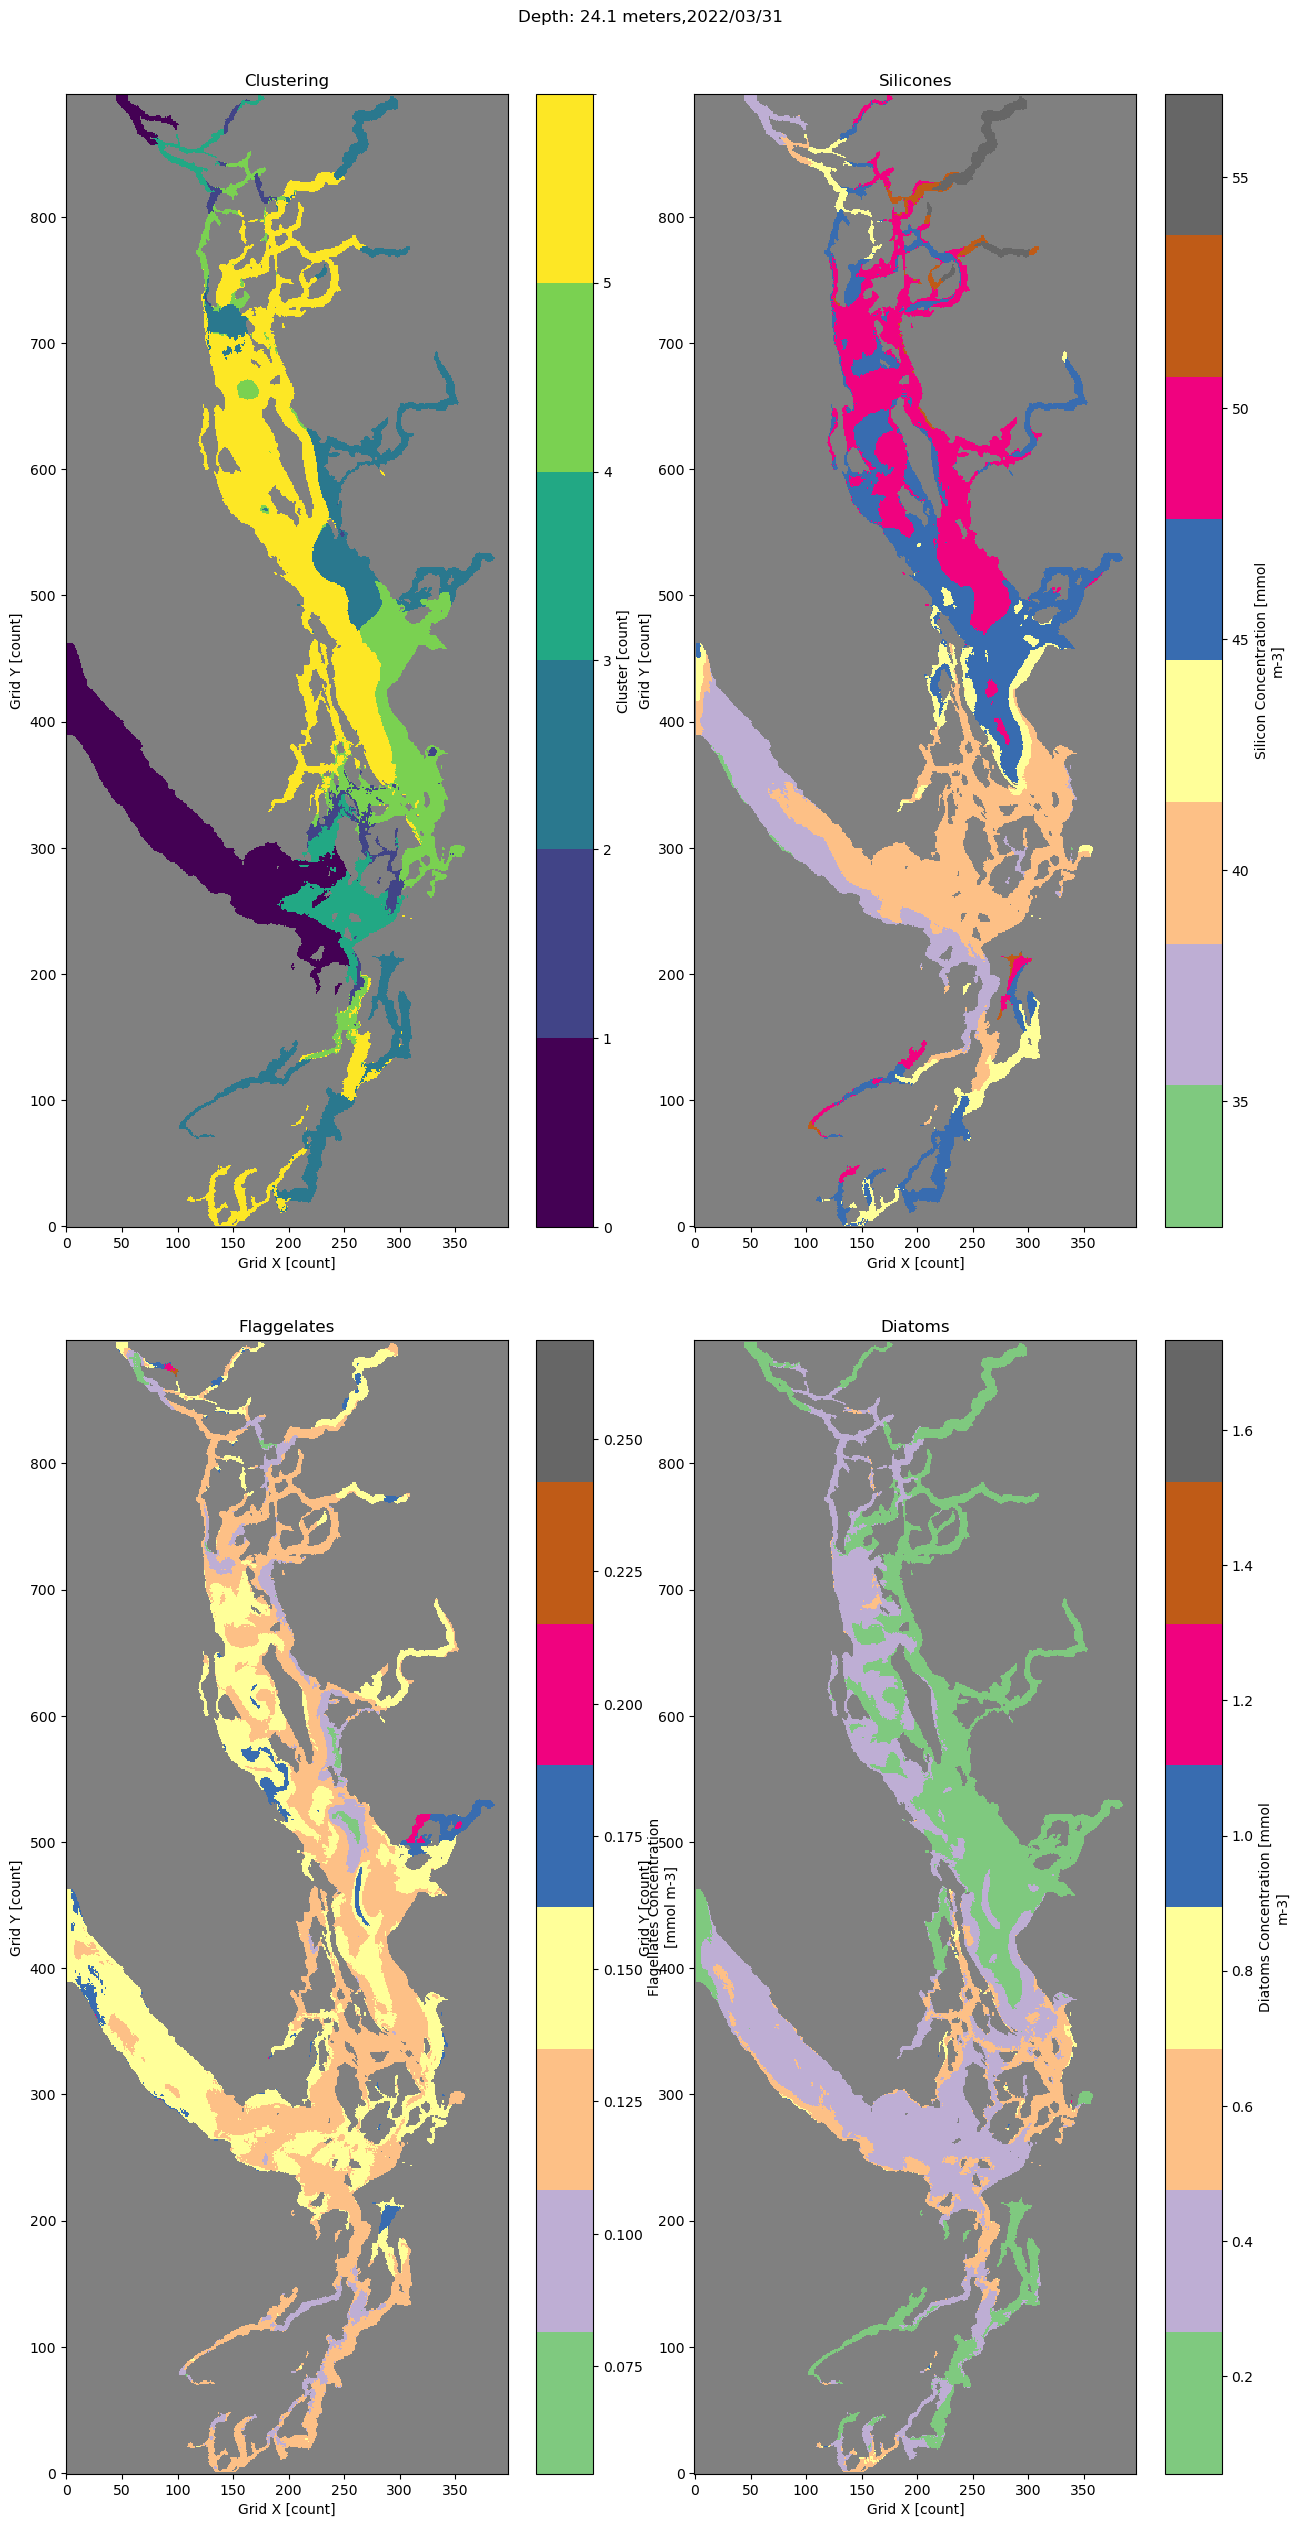

The amount of grid boxes for cluster 0 is 12405 

The minimum temperature for cluster 0 is 8.25 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.83 degrees Celsius 

The minimum salinity for cluster 0 is 28.78 g/kg
The maximum salinity for cluster 0 is 29.97 g/kg
The mean salinity for cluster 0 is 29.54 g/kg 


The amount of grid boxes for cluster 1 is 2708 

The minimum temperature for cluster 1 is 7.51 degrees Celsius
The maximum temperature for cluster 1 is 8.69 degrees Celsius
The mean temperature for cluster 1 is 7.89 degrees Celsius 

The minimum salinity for cluster 1 is 29.86 g/kg
The maximum salinity for cluster 1 is 30.33 g/kg
The mean salinity for cluster 1 is 30.1 g/kg 


The amount of grid boxes for cluster 2 is 12763 

The minimum temperature for cluster 2 is 7.13 degrees Celsius
The maximum temperature for cluster 2 is 8.05 degrees Celsius
The mean temperature for cluster 2 is 7.69 degrees Celsius 

Th

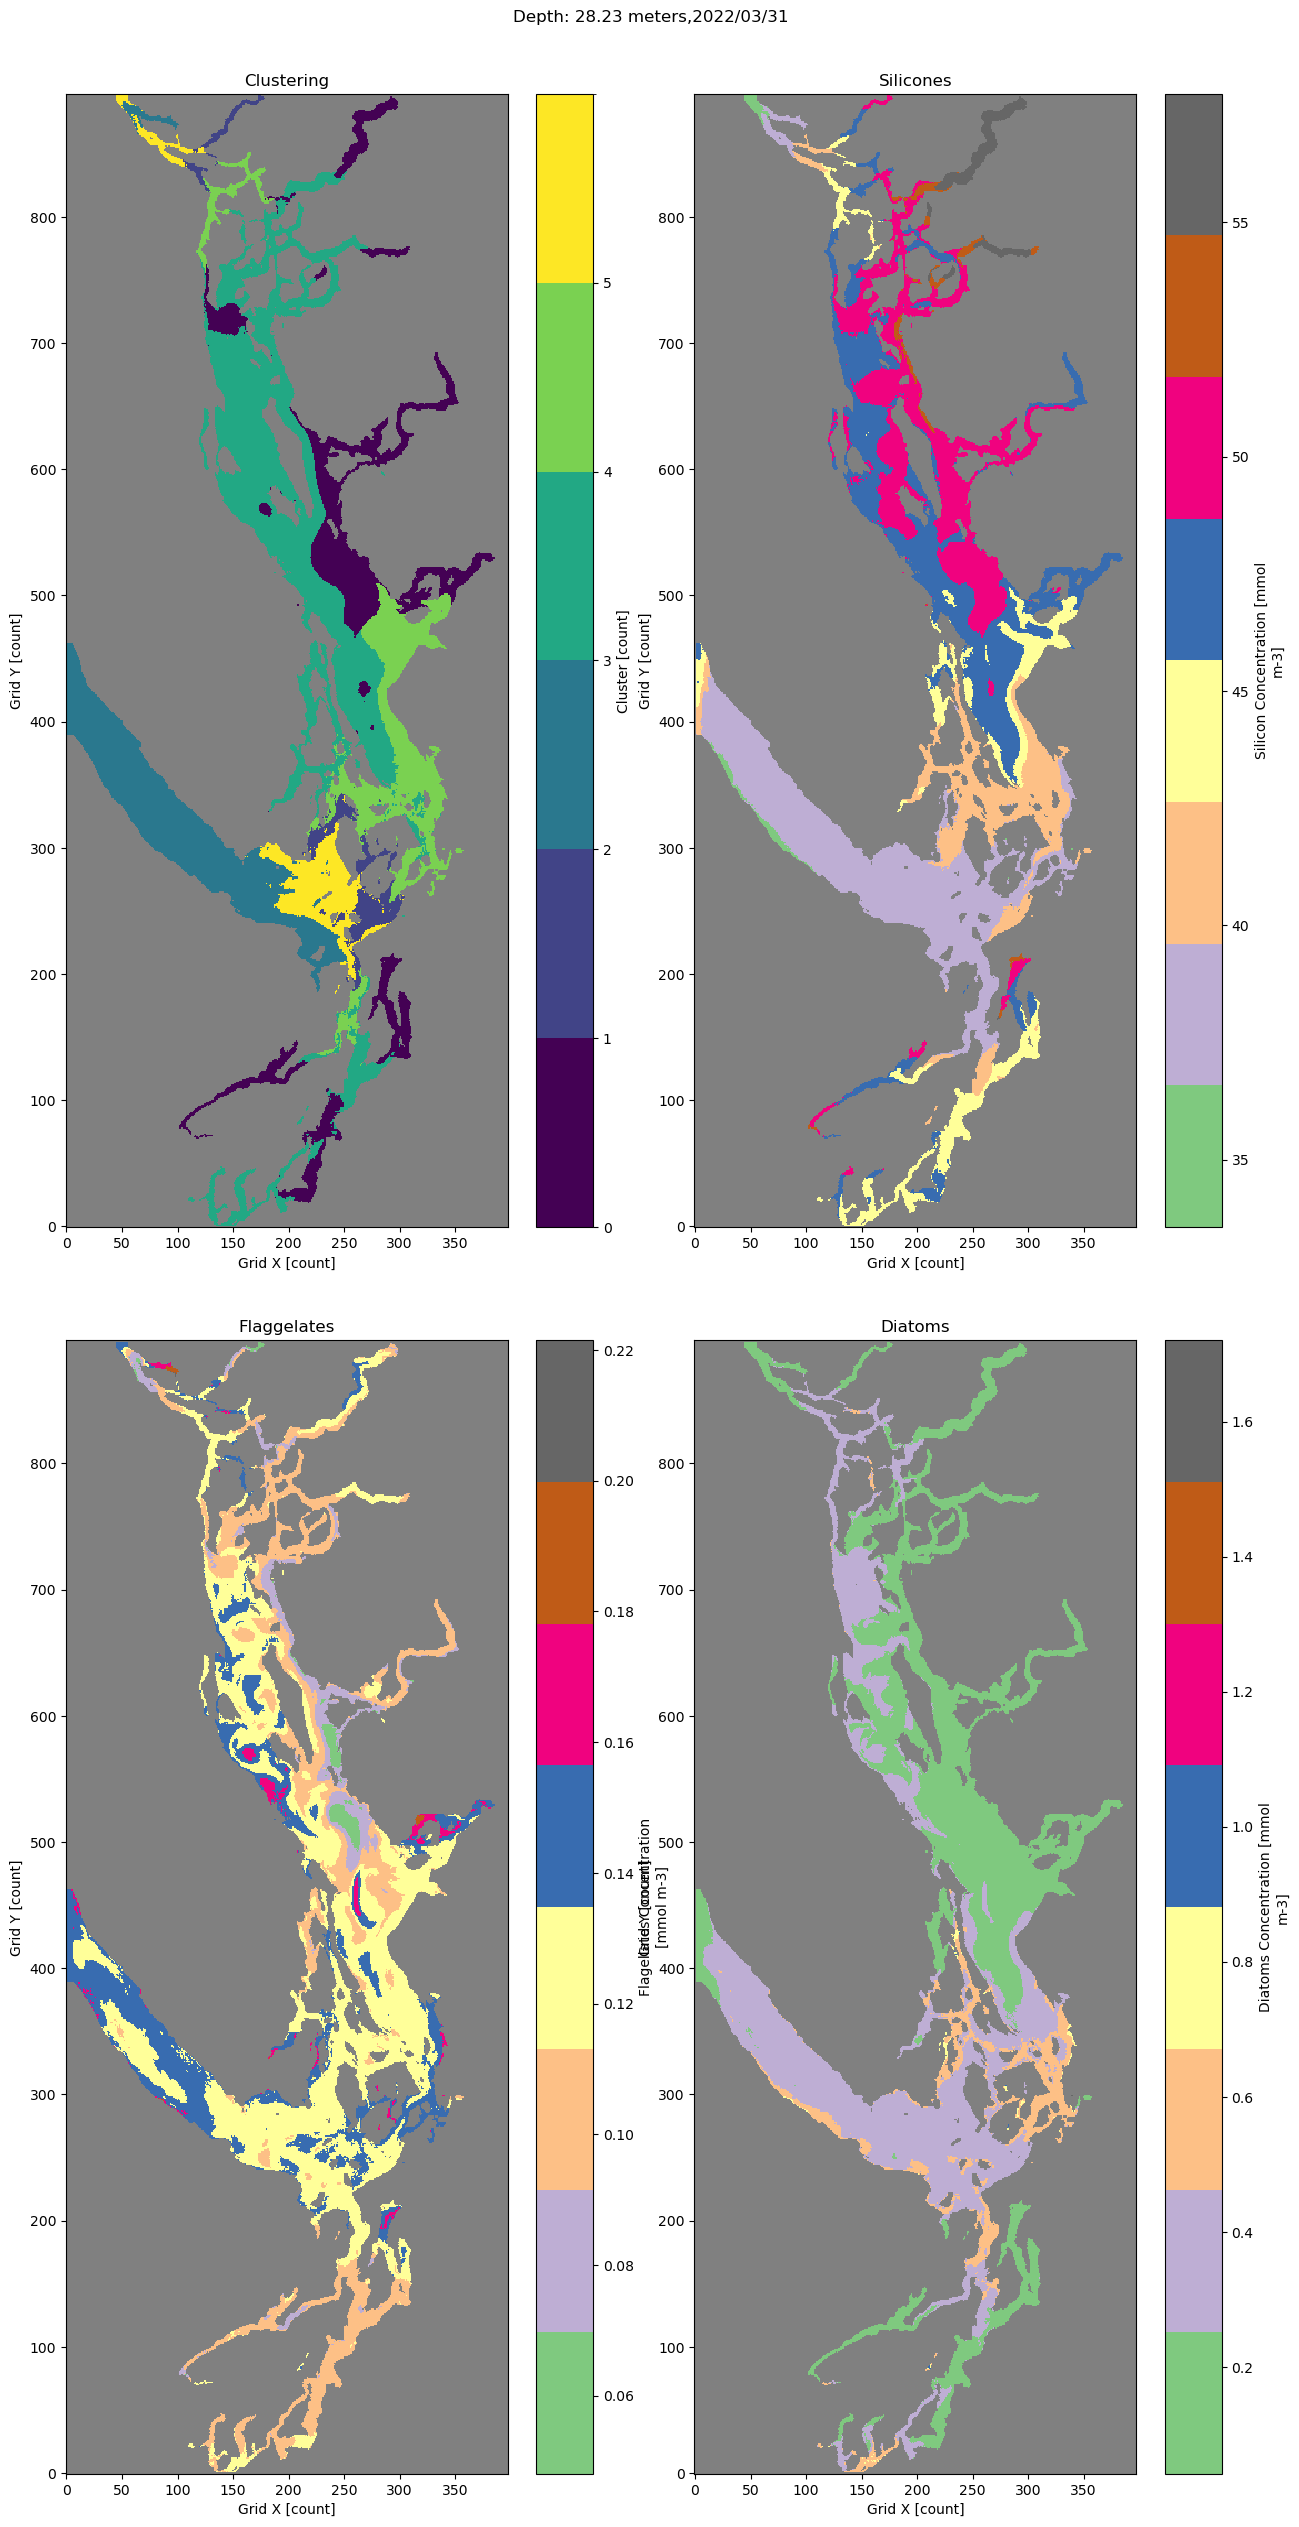

The amount of grid boxes for cluster 0 is 20977 

The minimum temperature for cluster 0 is 7.63 degrees Celsius
The maximum temperature for cluster 0 is 8.78 degrees Celsius
The mean temperature for cluster 0 is 8.19 degrees Celsius 

The minimum salinity for cluster 0 is 26.82 g/kg
The maximum salinity for cluster 0 is 29.56 g/kg
The mean salinity for cluster 0 is 29.25 g/kg 


The amount of grid boxes for cluster 1 is 10514 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.38 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 29.37 g/kg
The maximum salinity for cluster 1 is 29.92 g/kg
The mean salinity for cluster 1 is 29.67 g/kg 


The amount of grid boxes for cluster 2 is 4487 

The minimum temperature for cluster 2 is 7.42 degrees Celsius
The maximum temperature for cluster 2 is 7.99 degrees Celsius
The mean temperature for cluster 2 is 7.76 degrees Celsius 

The

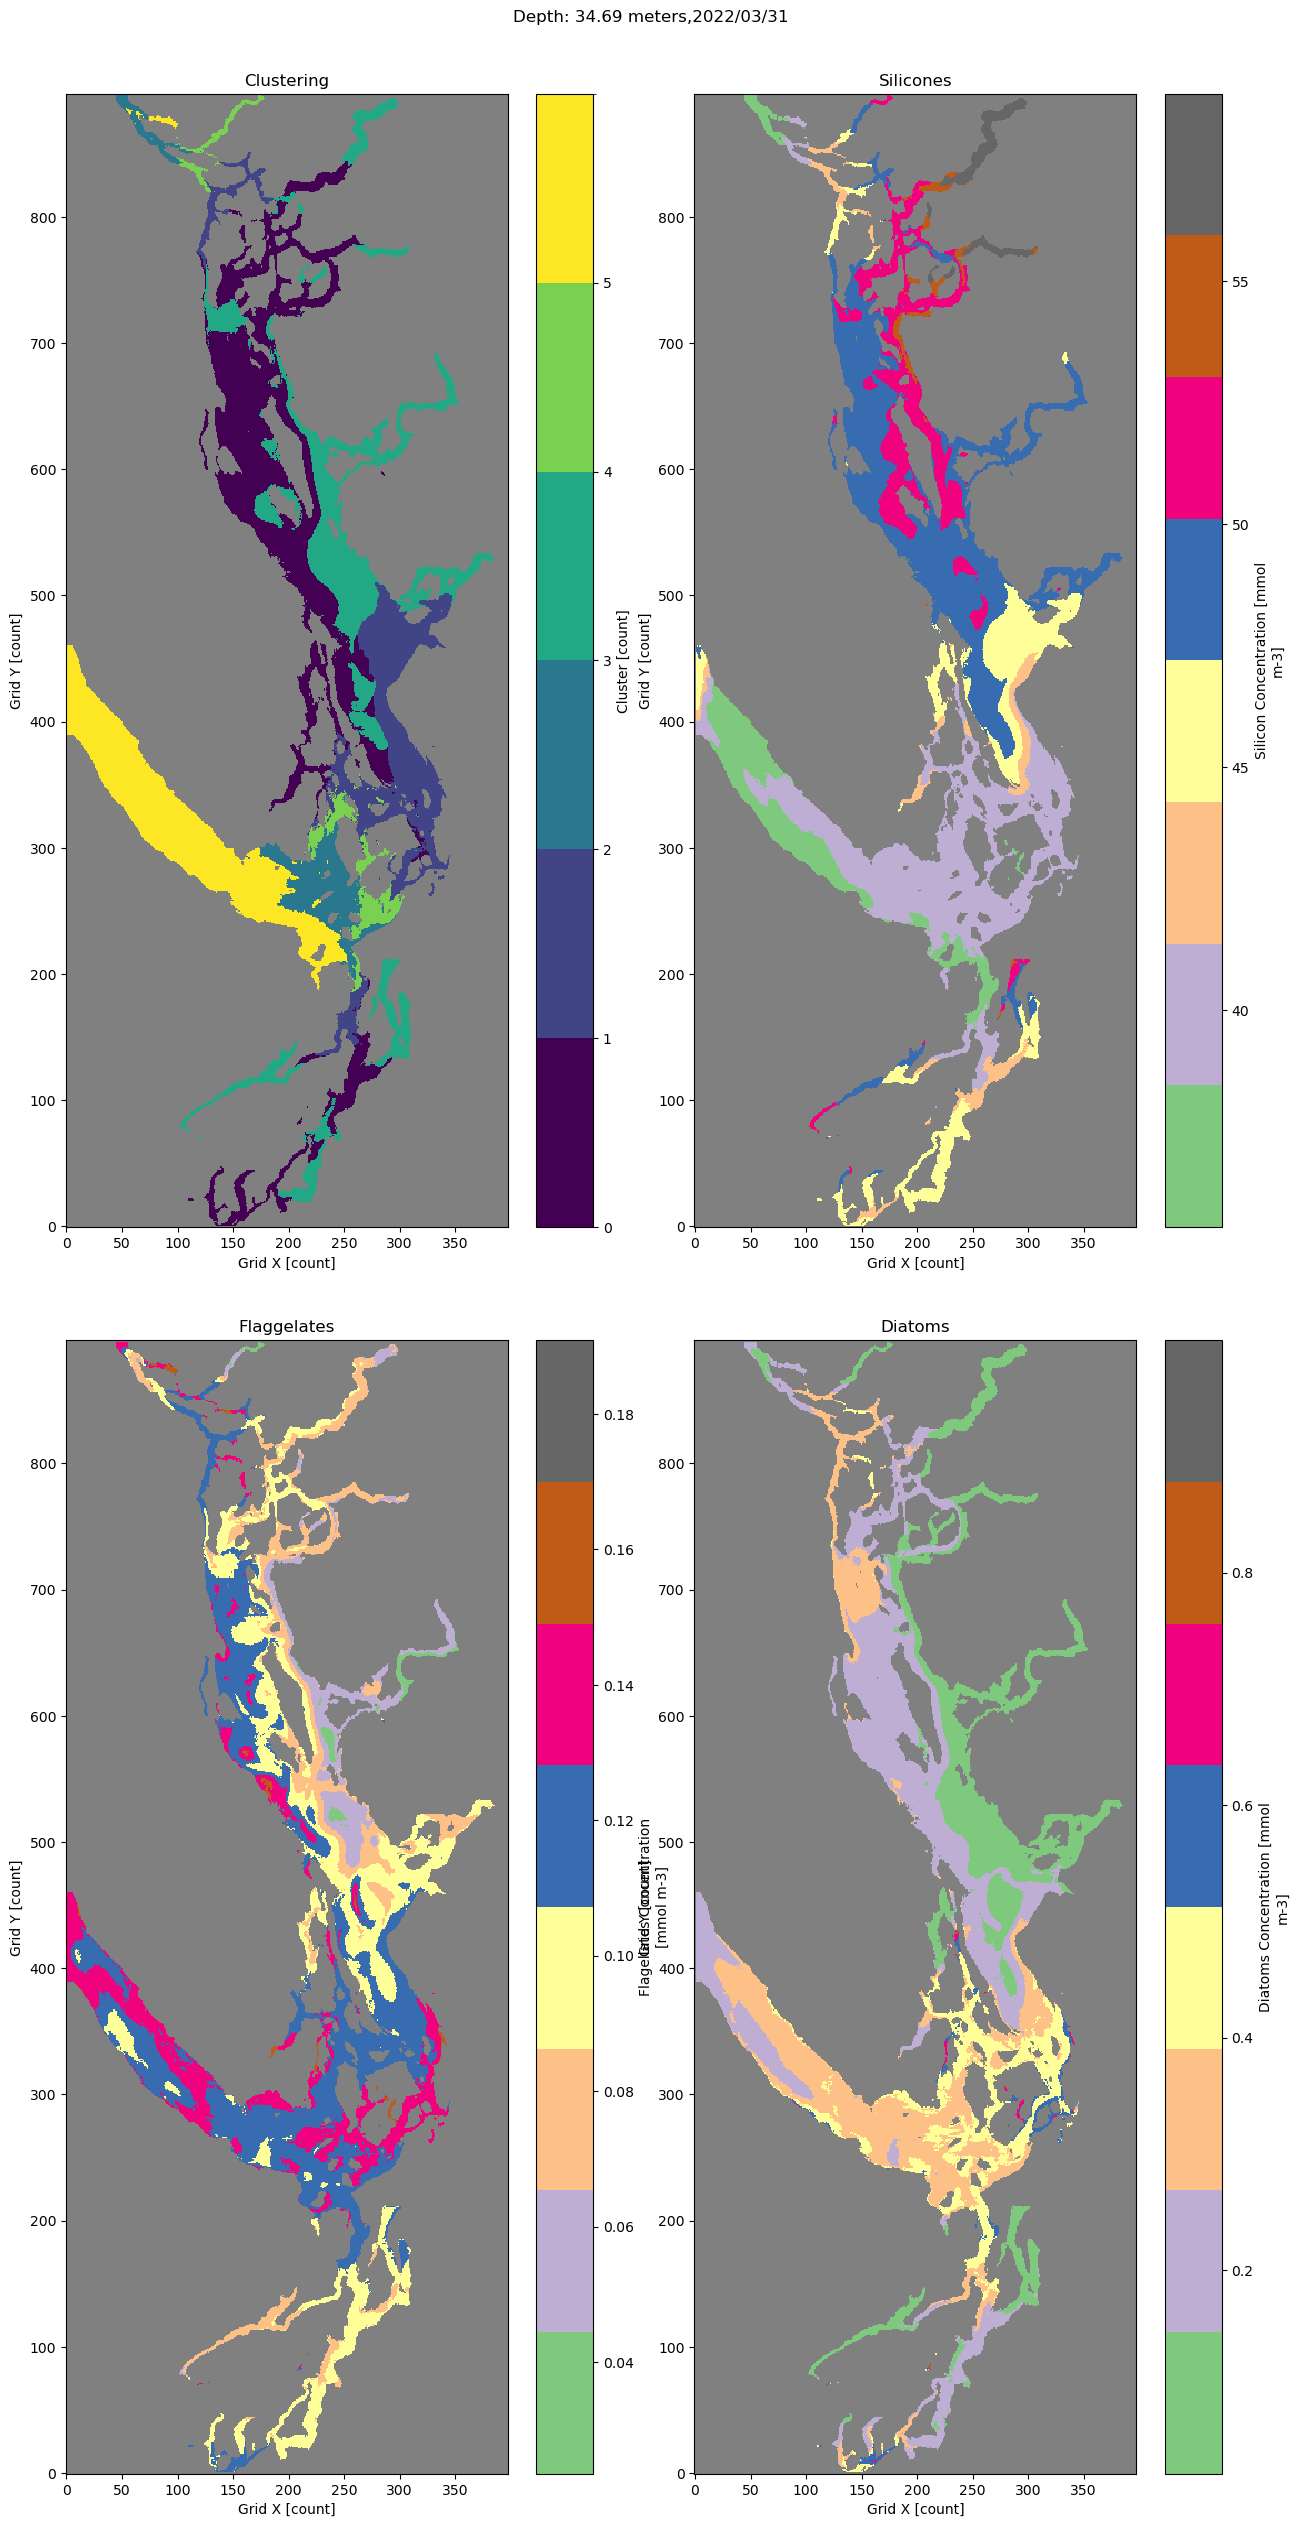

The amount of grid boxes for cluster 0 is 12913 

The minimum temperature for cluster 0 is 8.37 degrees Celsius
The maximum temperature for cluster 0 is 10.31 degrees Celsius
The mean temperature for cluster 0 is 8.84 degrees Celsius 

The minimum salinity for cluster 0 is 29.37 g/kg
The maximum salinity for cluster 0 is 30.38 g/kg
The mean salinity for cluster 0 is 29.84 g/kg 


The amount of grid boxes for cluster 1 is 1078 

The minimum temperature for cluster 1 is 7.61 degrees Celsius
The maximum temperature for cluster 1 is 8.74 degrees Celsius
The mean temperature for cluster 1 is 7.89 degrees Celsius 

The minimum salinity for cluster 1 is 30.14 g/kg
The maximum salinity for cluster 1 is 30.51 g/kg
The mean salinity for cluster 1 is 30.26 g/kg 


The amount of grid boxes for cluster 2 is 12167 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 7.78 degrees Celsius
The mean temperature for cluster 2 is 7.57 degrees Celsius 

T

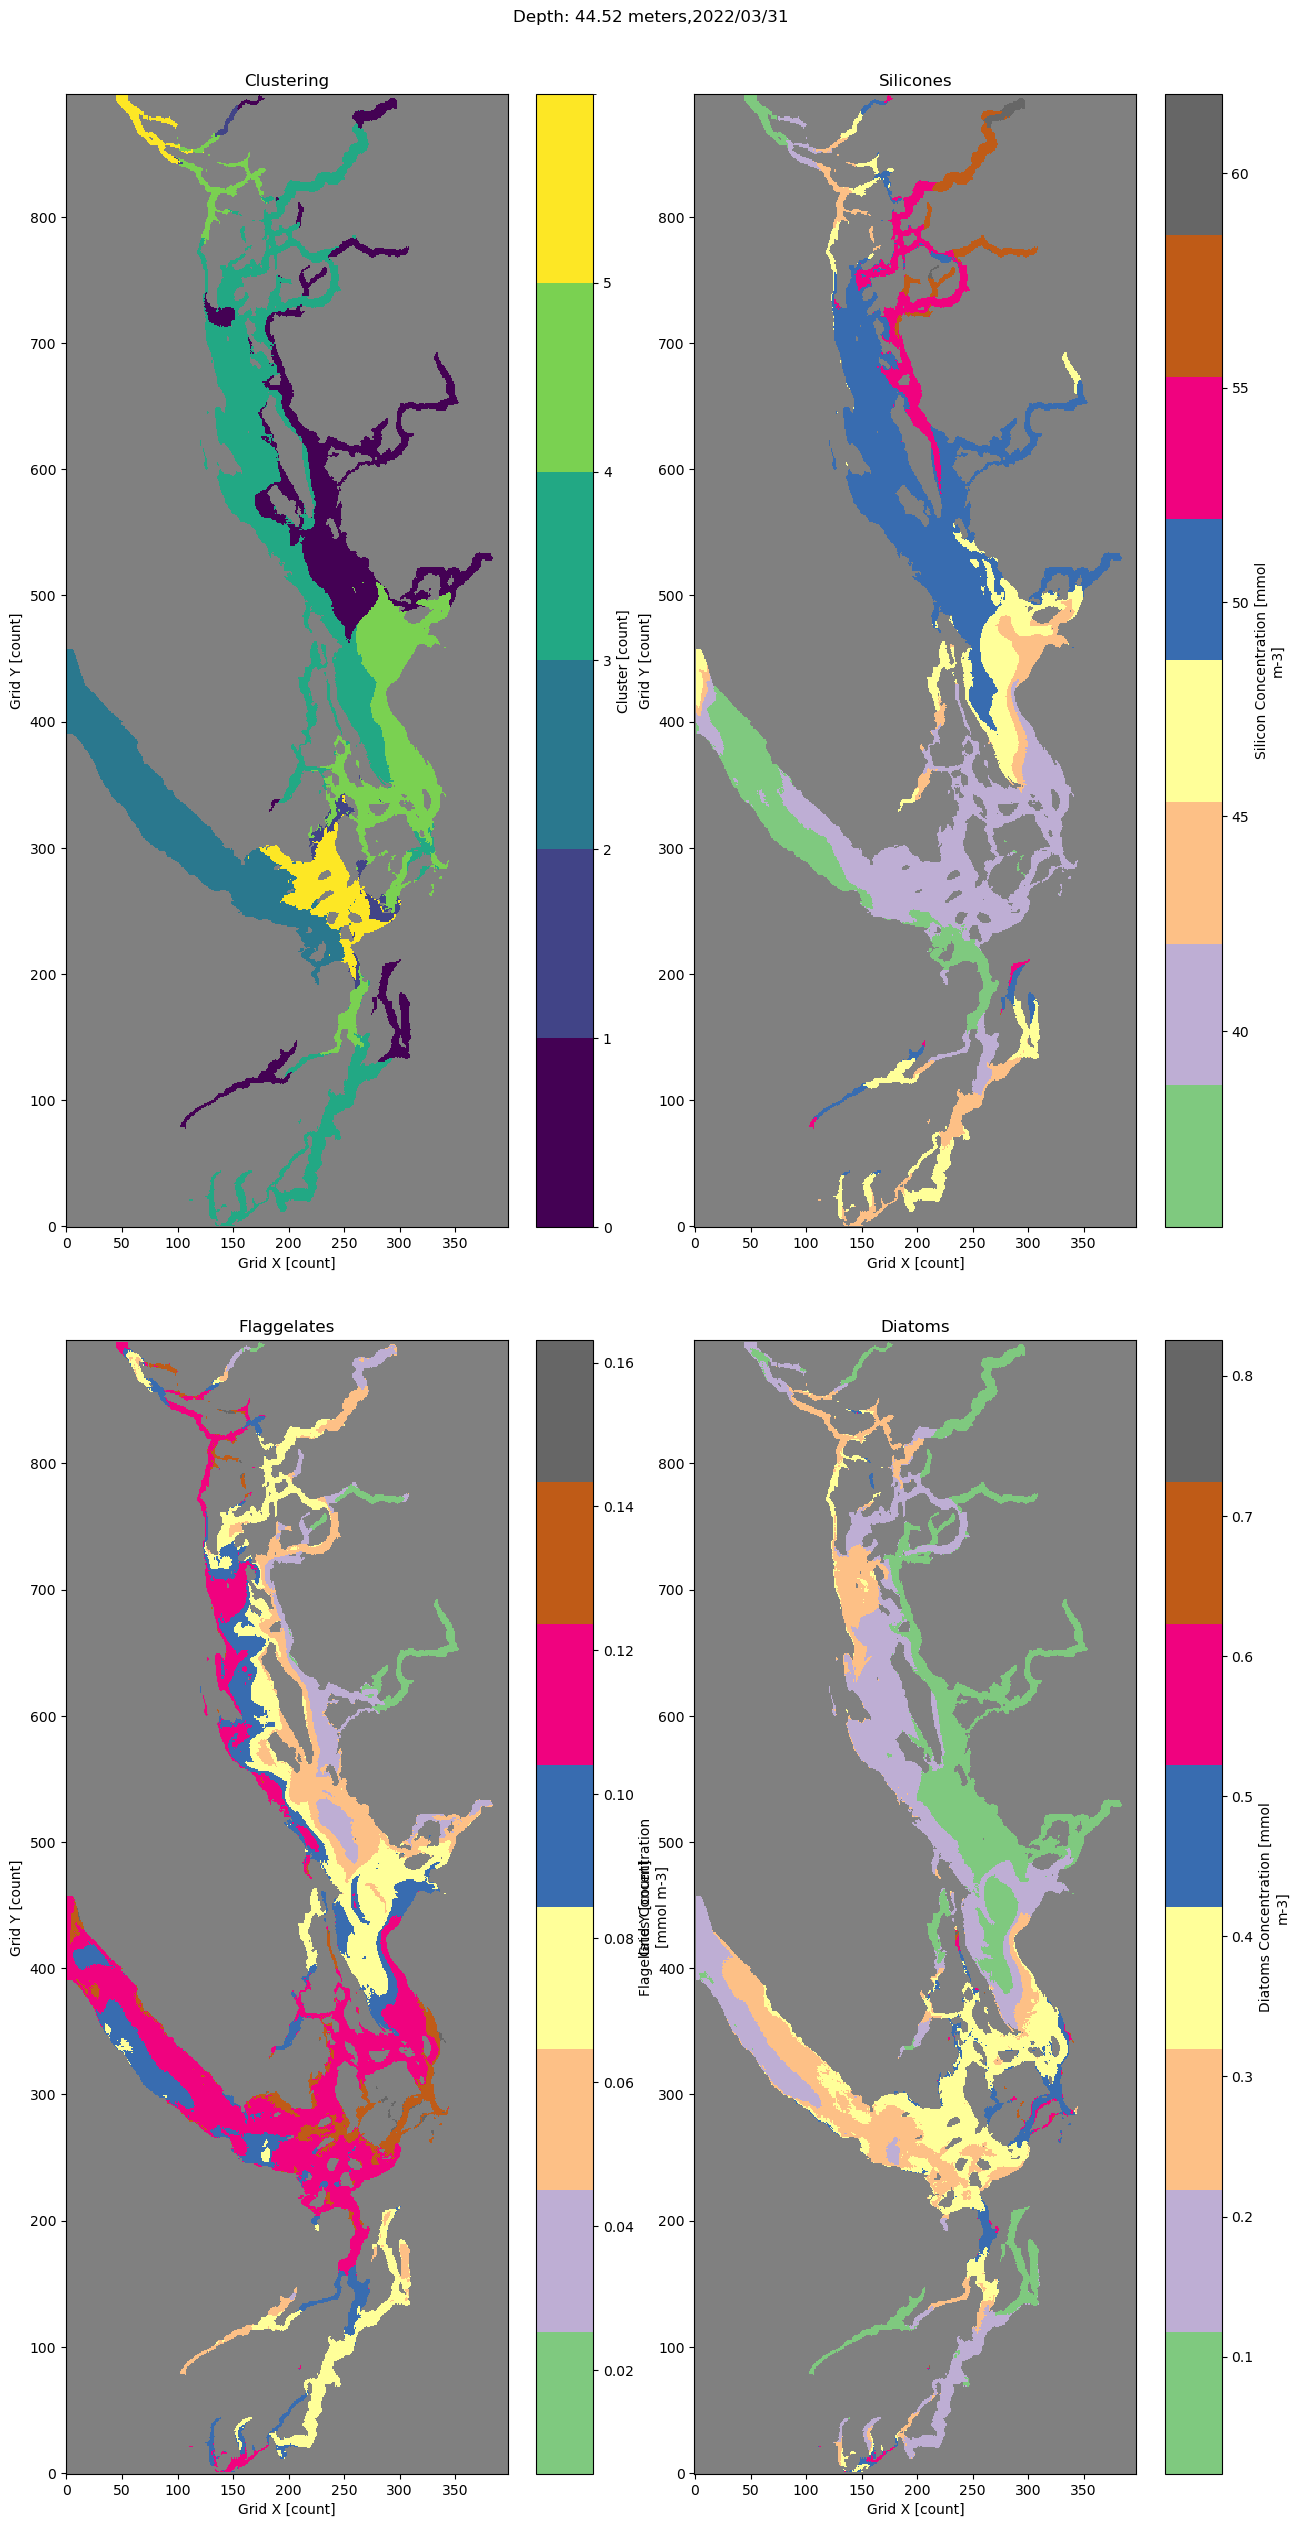

The amount of grid boxes for cluster 0 is 17808 

The minimum temperature for cluster 0 is 8.32 degrees Celsius
The maximum temperature for cluster 0 is 10.39 degrees Celsius
The mean temperature for cluster 0 is 8.78 degrees Celsius 

The minimum salinity for cluster 0 is 29.53 g/kg
The maximum salinity for cluster 0 is 30.47 g/kg
The mean salinity for cluster 0 is 29.94 g/kg 


The amount of grid boxes for cluster 1 is 1073 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.45 degrees Celsius
The mean temperature for cluster 1 is 7.77 degrees Celsius 

The minimum salinity for cluster 1 is 30.28 g/kg
The maximum salinity for cluster 1 is 30.69 g/kg
The mean salinity for cluster 1 is 30.46 g/kg 


The amount of grid boxes for cluster 2 is 11417 

The minimum temperature for cluster 2 is 7.29 degrees Celsius
The maximum temperature for cluster 2 is 7.68 degrees Celsius
The mean temperature for cluster 2 is 7.47 degrees Celsius 

T

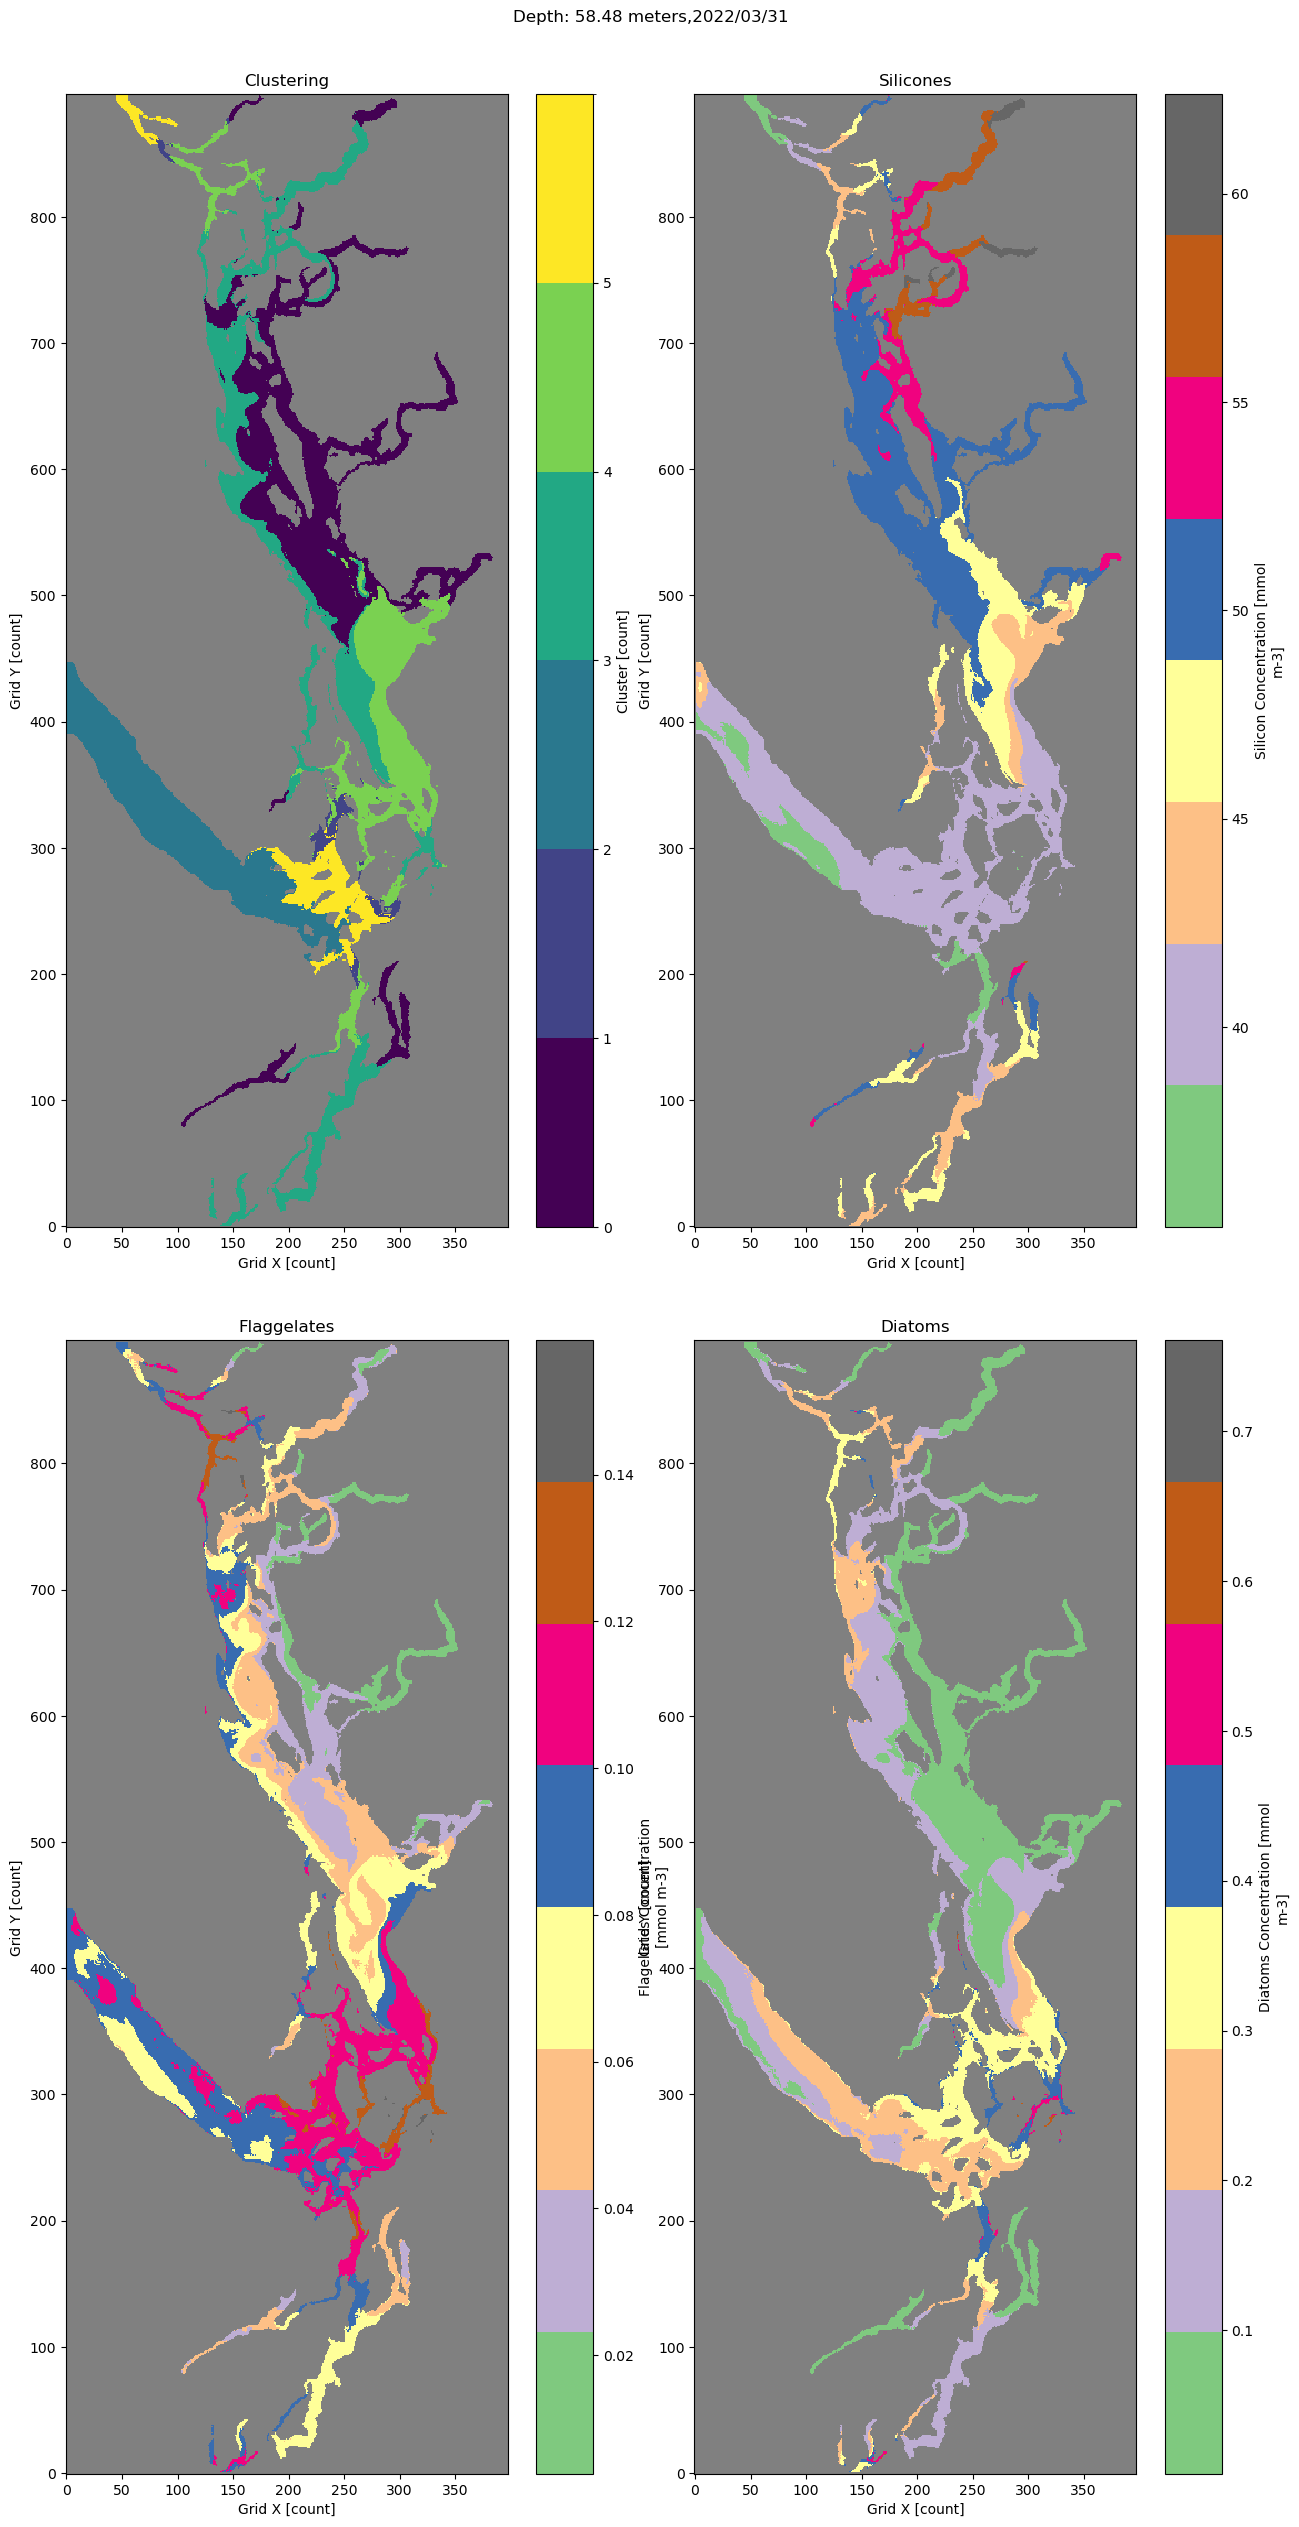

The amount of grid boxes for cluster 0 is 16801 

The minimum temperature for cluster 0 is 8.44 degrees Celsius
The maximum temperature for cluster 0 is 10.45 degrees Celsius
The mean temperature for cluster 0 is 8.86 degrees Celsius 

The minimum salinity for cluster 0 is 29.55 g/kg
The maximum salinity for cluster 0 is 30.53 g/kg
The mean salinity for cluster 0 is 30.05 g/kg 


The amount of grid boxes for cluster 1 is 645 

The minimum temperature for cluster 1 is 7.6 degrees Celsius
The maximum temperature for cluster 1 is 7.87 degrees Celsius
The mean temperature for cluster 1 is 7.71 degrees Celsius 

The minimum salinity for cluster 1 is 30.5 g/kg
The maximum salinity for cluster 1 is 30.85 g/kg
The mean salinity for cluster 1 is 30.66 g/kg 


The amount of grid boxes for cluster 2 is 10735 

The minimum temperature for cluster 2 is 7.2 degrees Celsius
The maximum temperature for cluster 2 is 7.58 degrees Celsius
The mean temperature for cluster 2 is 7.35 degrees Celsius 

The m

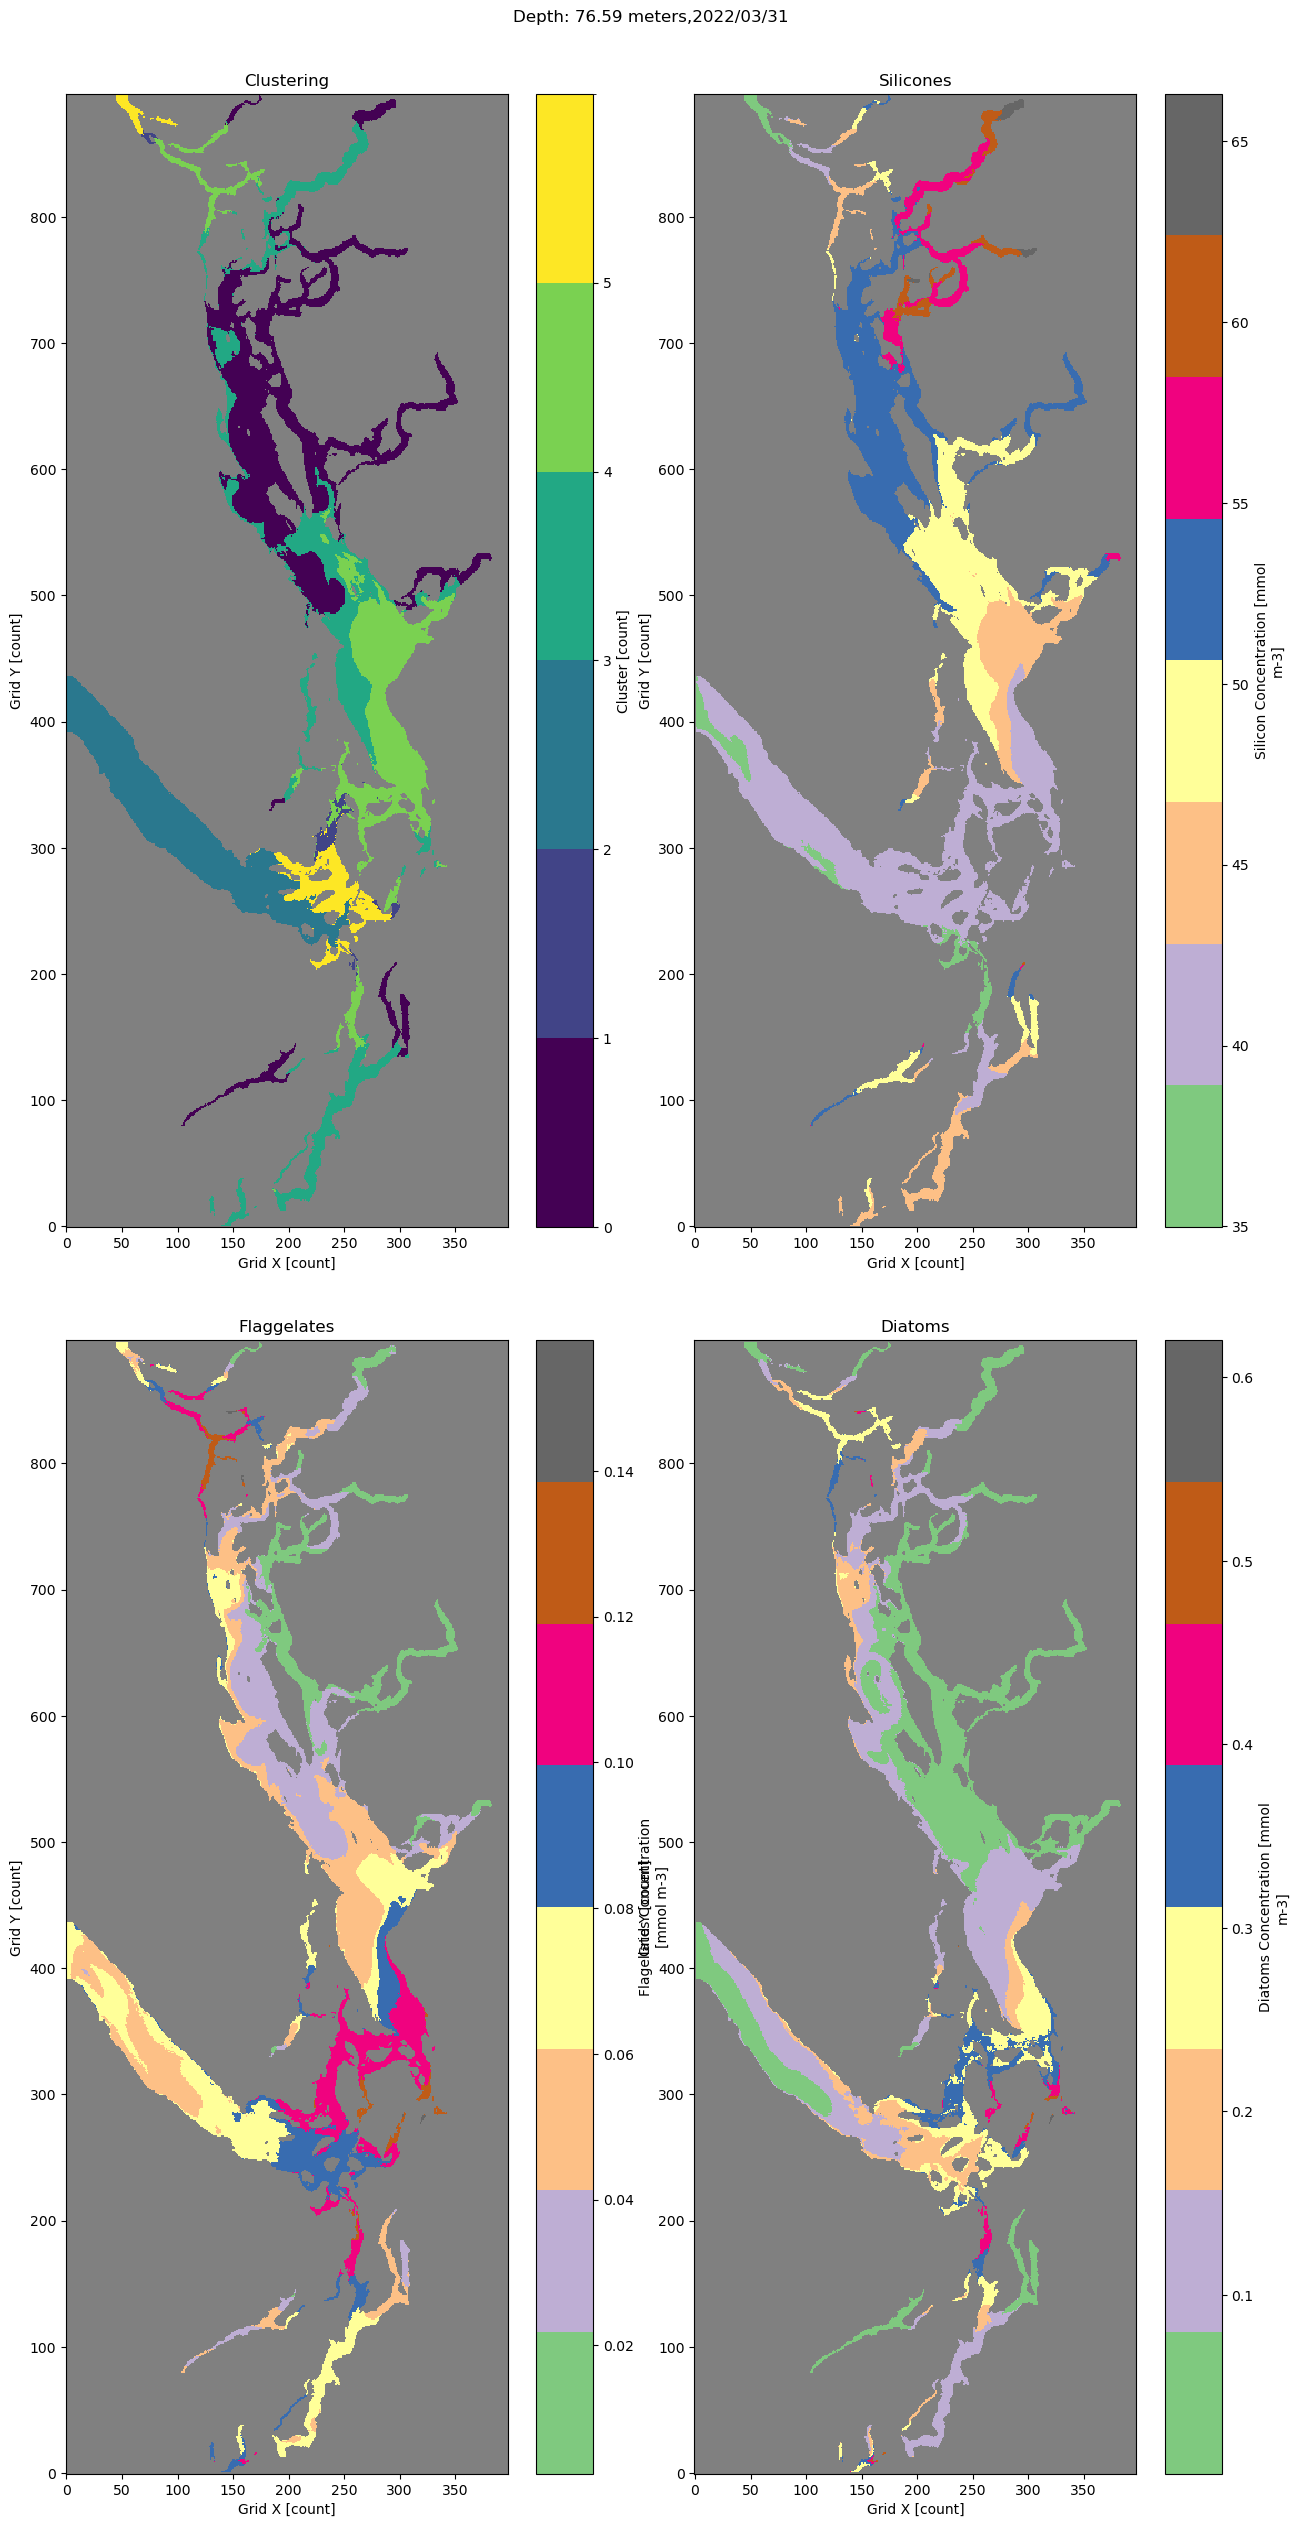

The amount of grid boxes for cluster 0 is 8220 

The minimum temperature for cluster 0 is 7.07 degrees Celsius
The maximum temperature for cluster 0 is 7.5 degrees Celsius
The mean temperature for cluster 0 is 7.21 degrees Celsius 

The minimum salinity for cluster 0 is 32.54 g/kg
The maximum salinity for cluster 0 is 33.55 g/kg
The mean salinity for cluster 0 is 33.18 g/kg 


The amount of grid boxes for cluster 1 is 603 

The minimum temperature for cluster 1 is 7.56 degrees Celsius
The maximum temperature for cluster 1 is 7.7 degrees Celsius
The mean temperature for cluster 1 is 7.62 degrees Celsius 

The minimum salinity for cluster 1 is 30.99 g/kg
The maximum salinity for cluster 1 is 31.5 g/kg
The mean salinity for cluster 1 is 31.21 g/kg 


The amount of grid boxes for cluster 2 is 17342 

The minimum temperature for cluster 2 is 8.42 degrees Celsius
The maximum temperature for cluster 2 is 10.48 degrees Celsius
The mean temperature for cluster 2 is 8.9 degrees Celsius 

The min

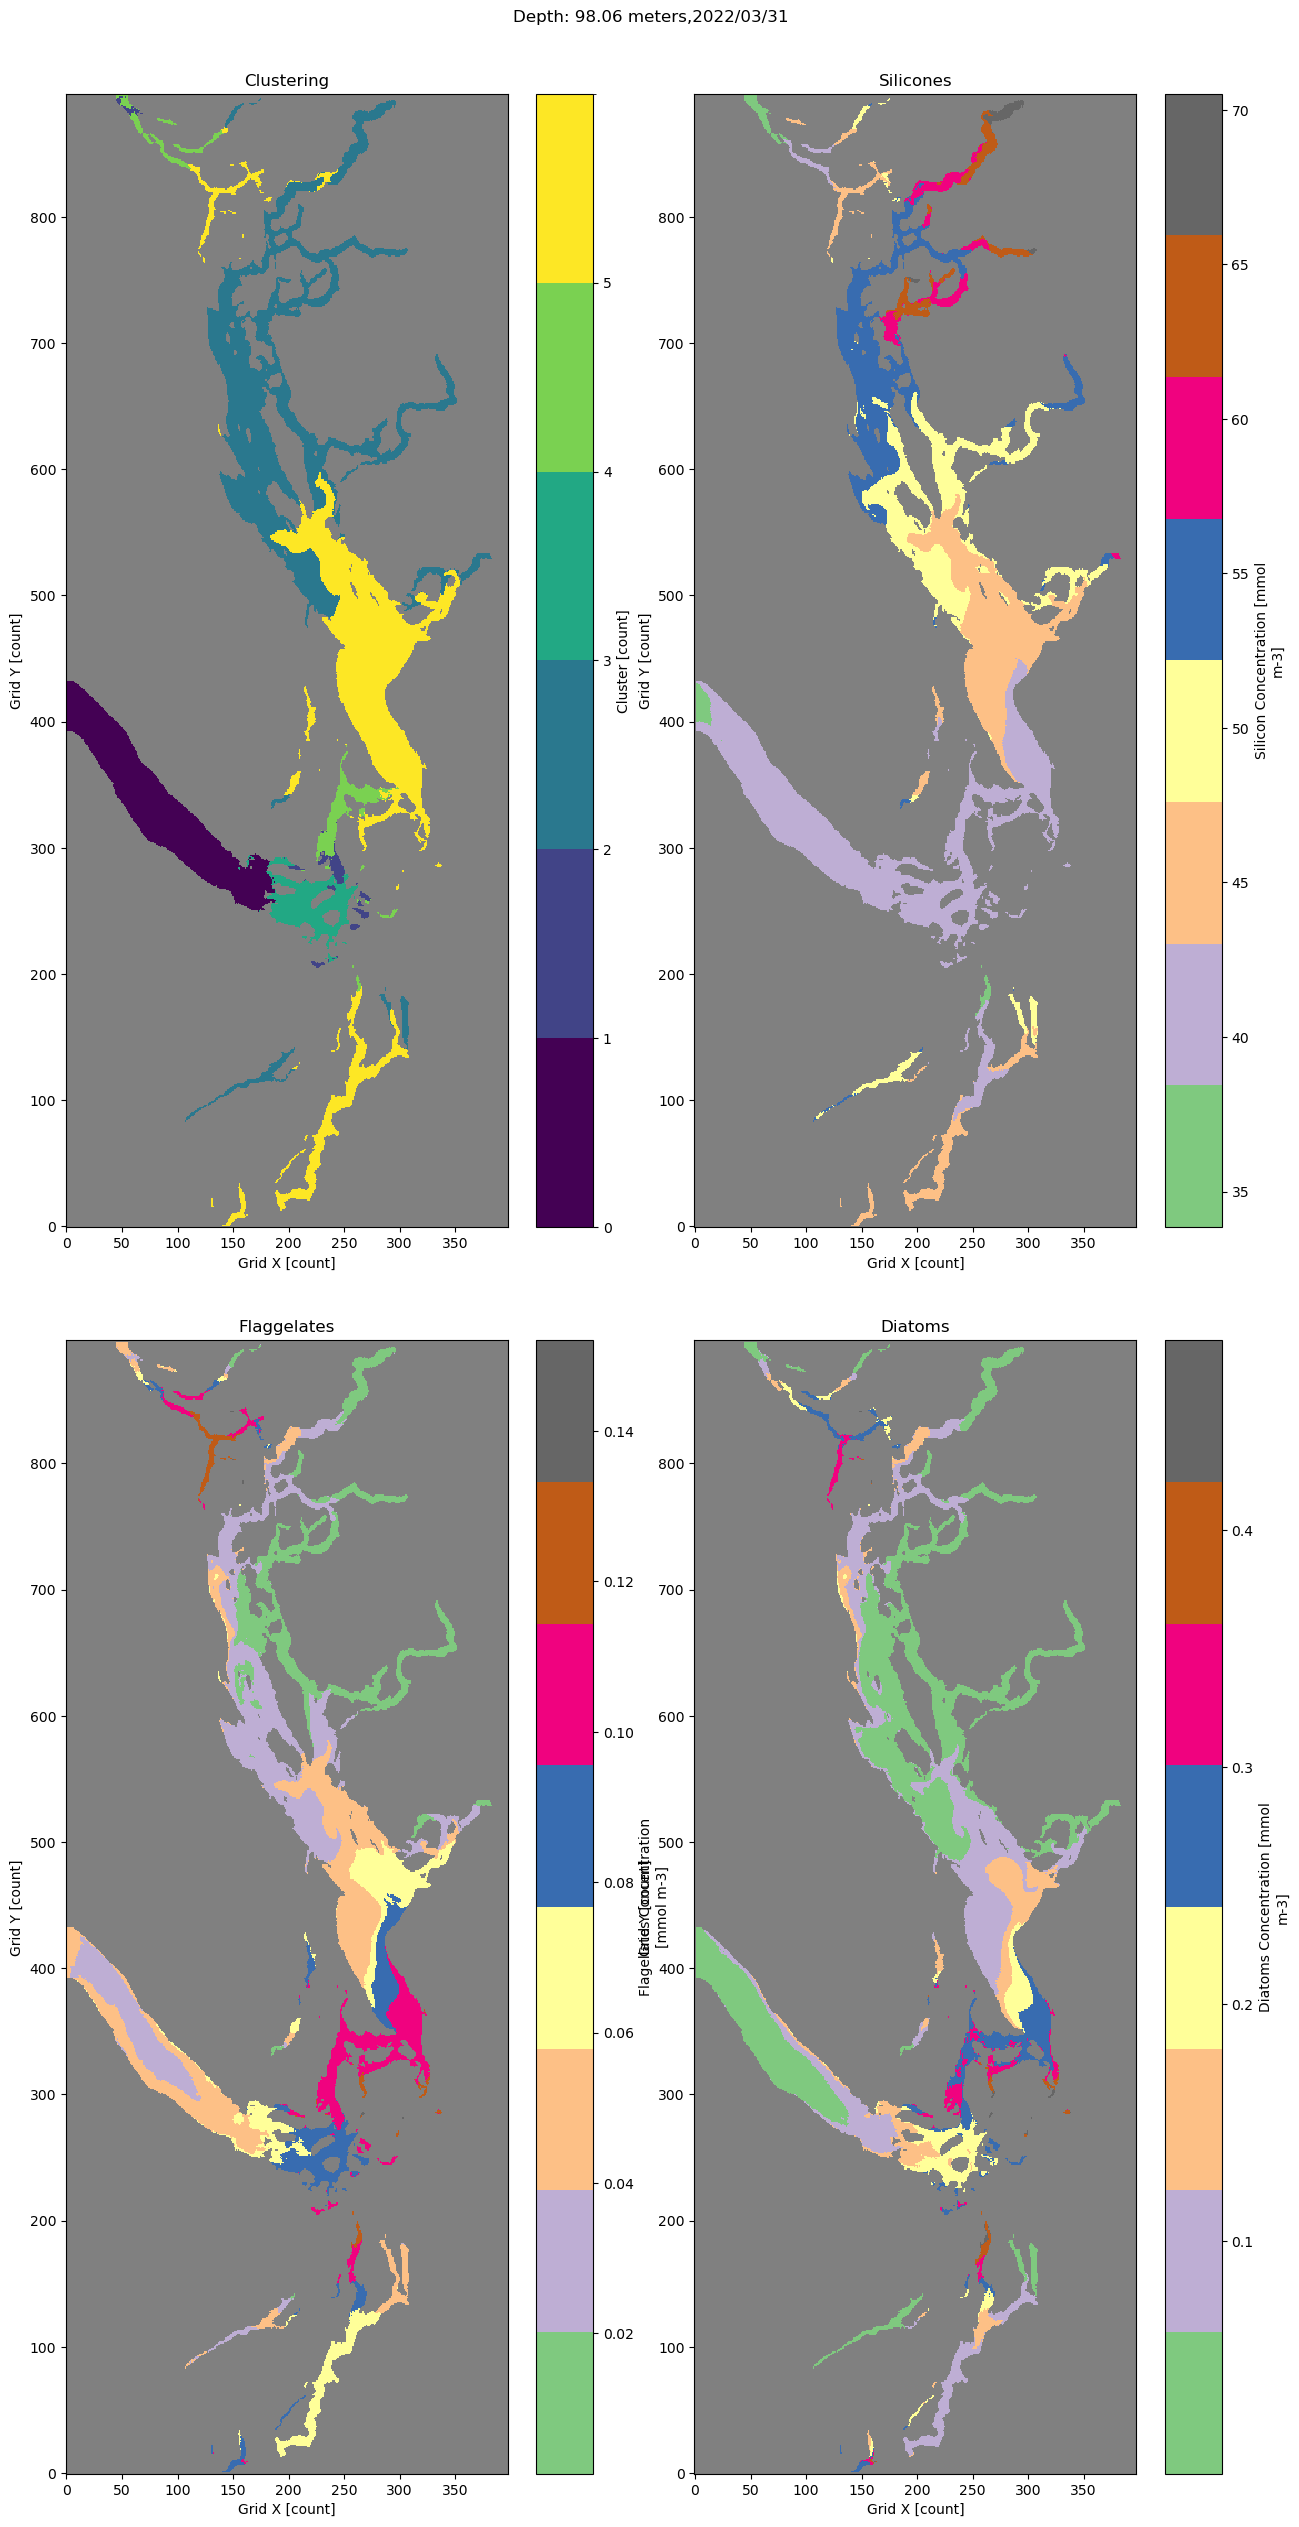

The amount of grid boxes for cluster 0 is 13020 

The minimum temperature for cluster 0 is 8.65 degrees Celsius
The maximum temperature for cluster 0 is 10.64 degrees Celsius
The mean temperature for cluster 0 is 9.04 degrees Celsius 

The minimum salinity for cluster 0 is 29.72 g/kg
The maximum salinity for cluster 0 is 30.59 g/kg
The mean salinity for cluster 0 is 30.38 g/kg 


The amount of grid boxes for cluster 1 is 219 

The minimum temperature for cluster 1 is 7.63 degrees Celsius
The maximum temperature for cluster 1 is 7.69 degrees Celsius
The mean temperature for cluster 1 is 7.66 degrees Celsius 

The minimum salinity for cluster 1 is 30.85 g/kg
The maximum salinity for cluster 1 is 30.97 g/kg
The mean salinity for cluster 1 is 30.91 g/kg 


The amount of grid boxes for cluster 2 is 8339 

The minimum temperature for cluster 2 is 6.94 degrees Celsius
The maximum temperature for cluster 2 is 7.46 degrees Celsius
The mean temperature for cluster 2 is 7.17 degrees Celsius 

The

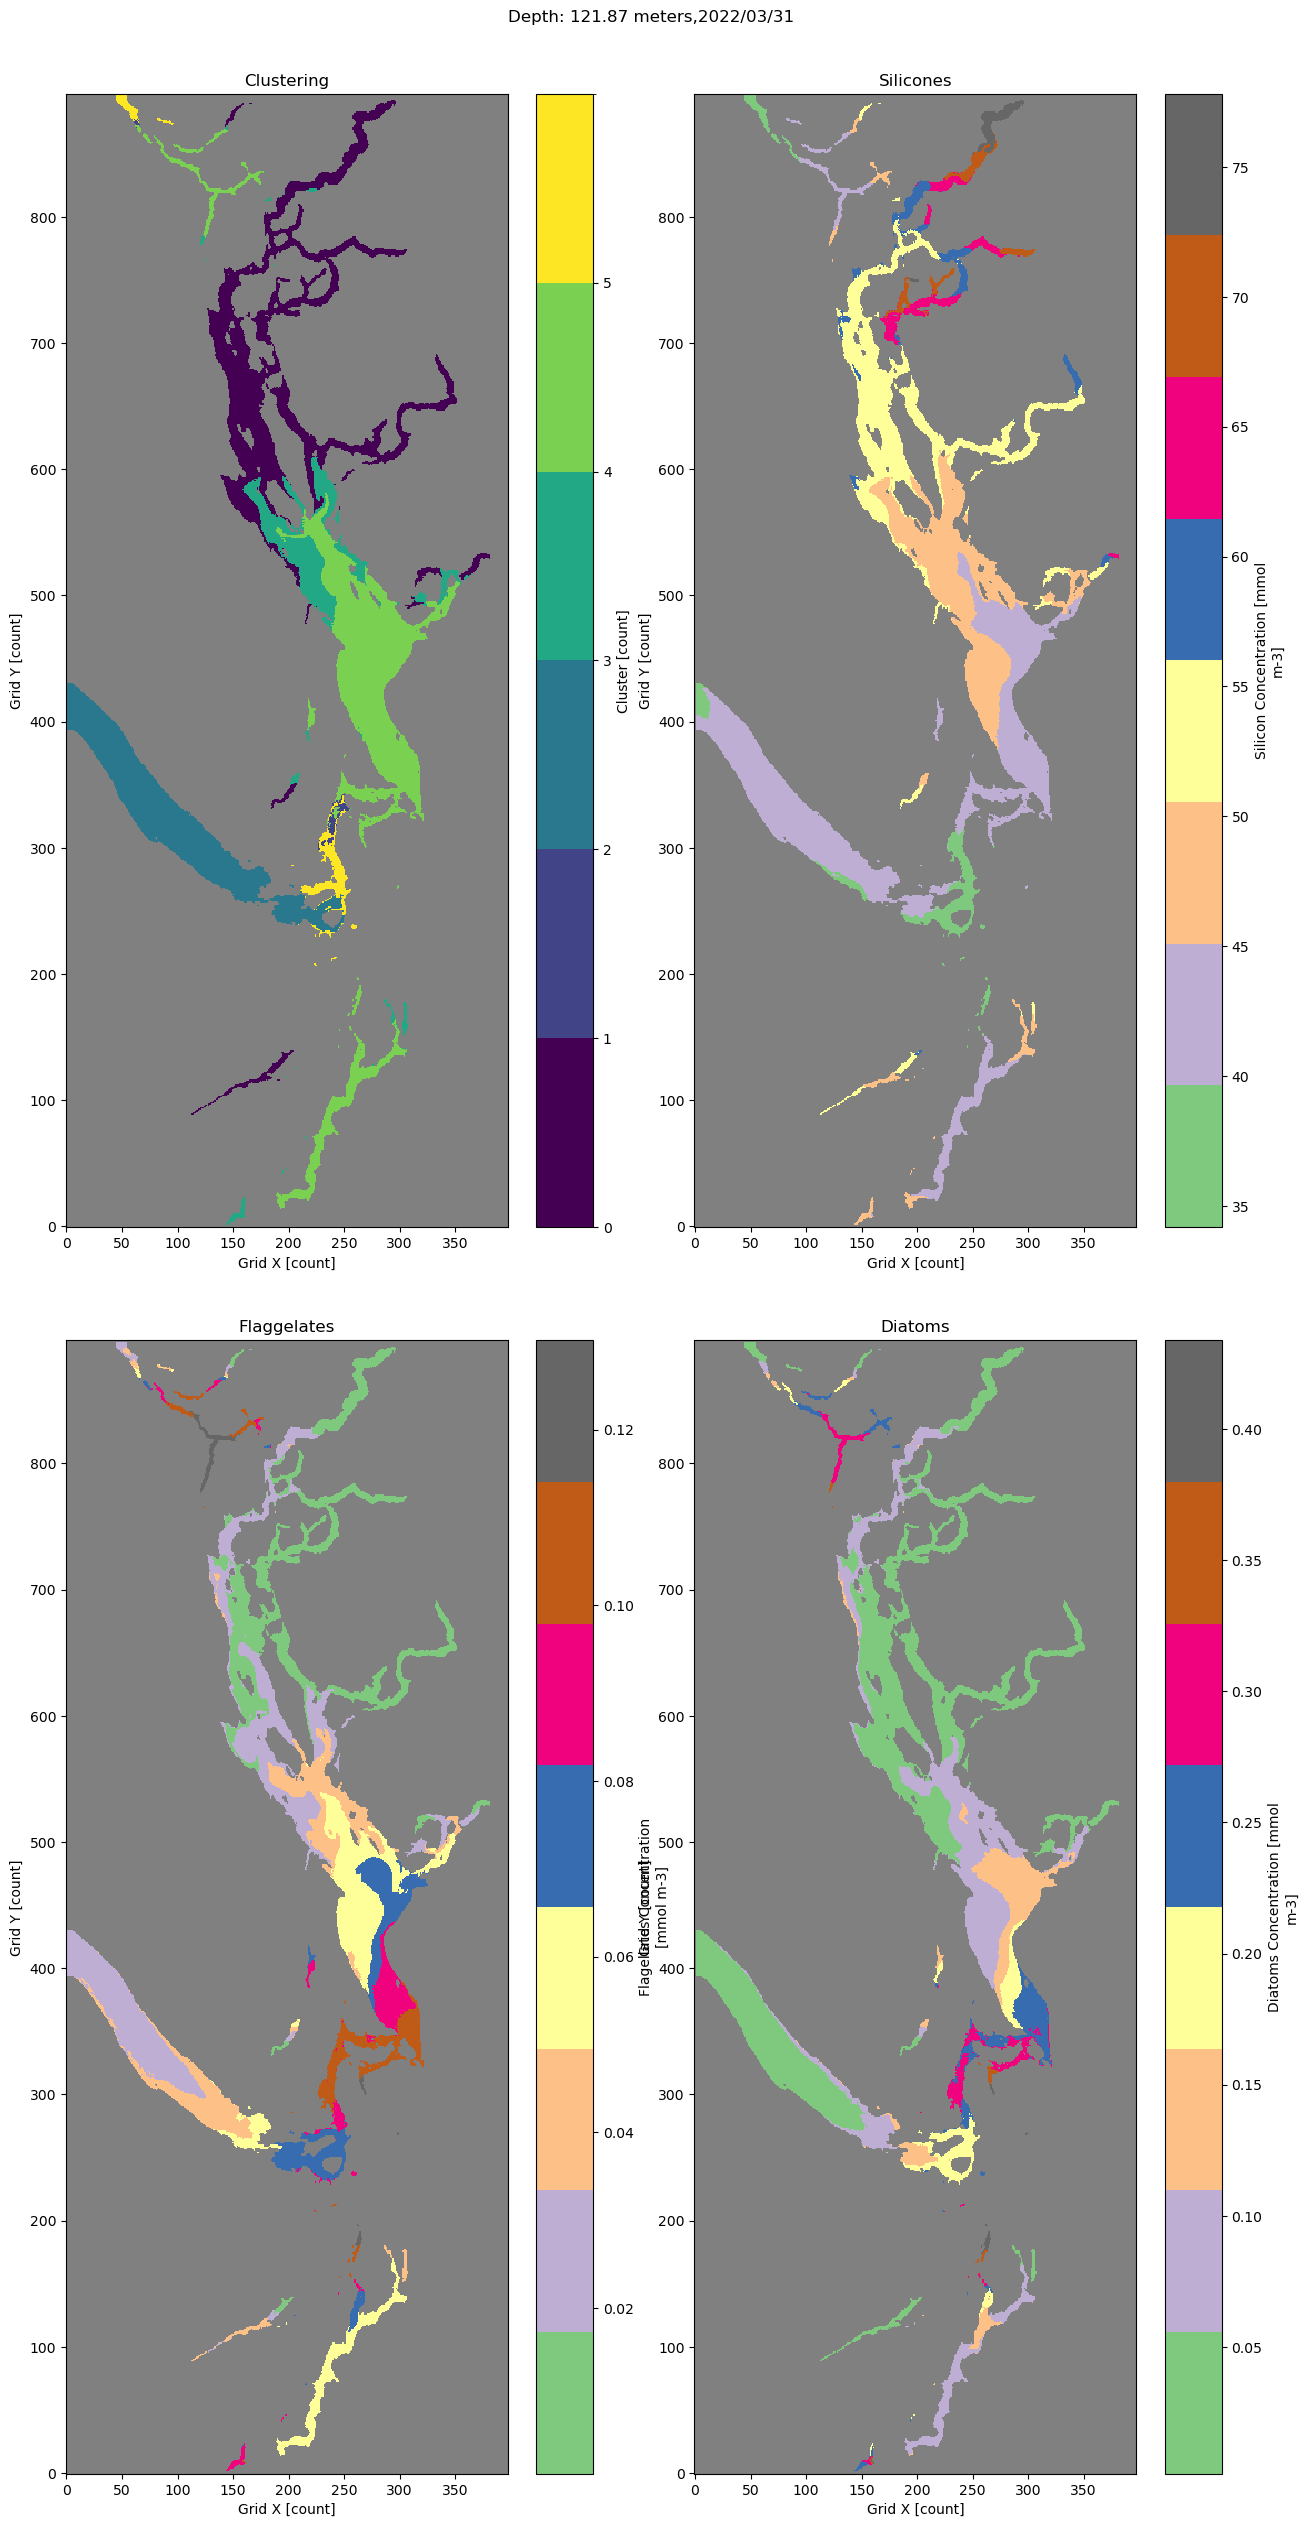

The amount of grid boxes for cluster 0 is 3202 

The minimum temperature for cluster 0 is 7.71 degrees Celsius
The maximum temperature for cluster 0 is 8.66 degrees Celsius
The mean temperature for cluster 0 is 8.4 degrees Celsius 

The minimum salinity for cluster 0 is 28.18 g/kg
The maximum salinity for cluster 0 is 30.6 g/kg
The mean salinity for cluster 0 is 30.39 g/kg 


The amount of grid boxes for cluster 1 is 10474 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 8.23 degrees Celsius
The mean temperature for cluster 1 is 7.92 degrees Celsius 

The minimum salinity for cluster 1 is 29.65 g/kg
The maximum salinity for cluster 1 is 30.98 g/kg
The mean salinity for cluster 1 is 30.33 g/kg 


The amount of grid boxes for cluster 2 is 798 

The minimum temperature for cluster 2 is 7.3 degrees Celsius
The maximum temperature for cluster 2 is 7.64 degrees Celsius
The mean temperature for cluster 2 is 7.47 degrees Celsius 

The mini

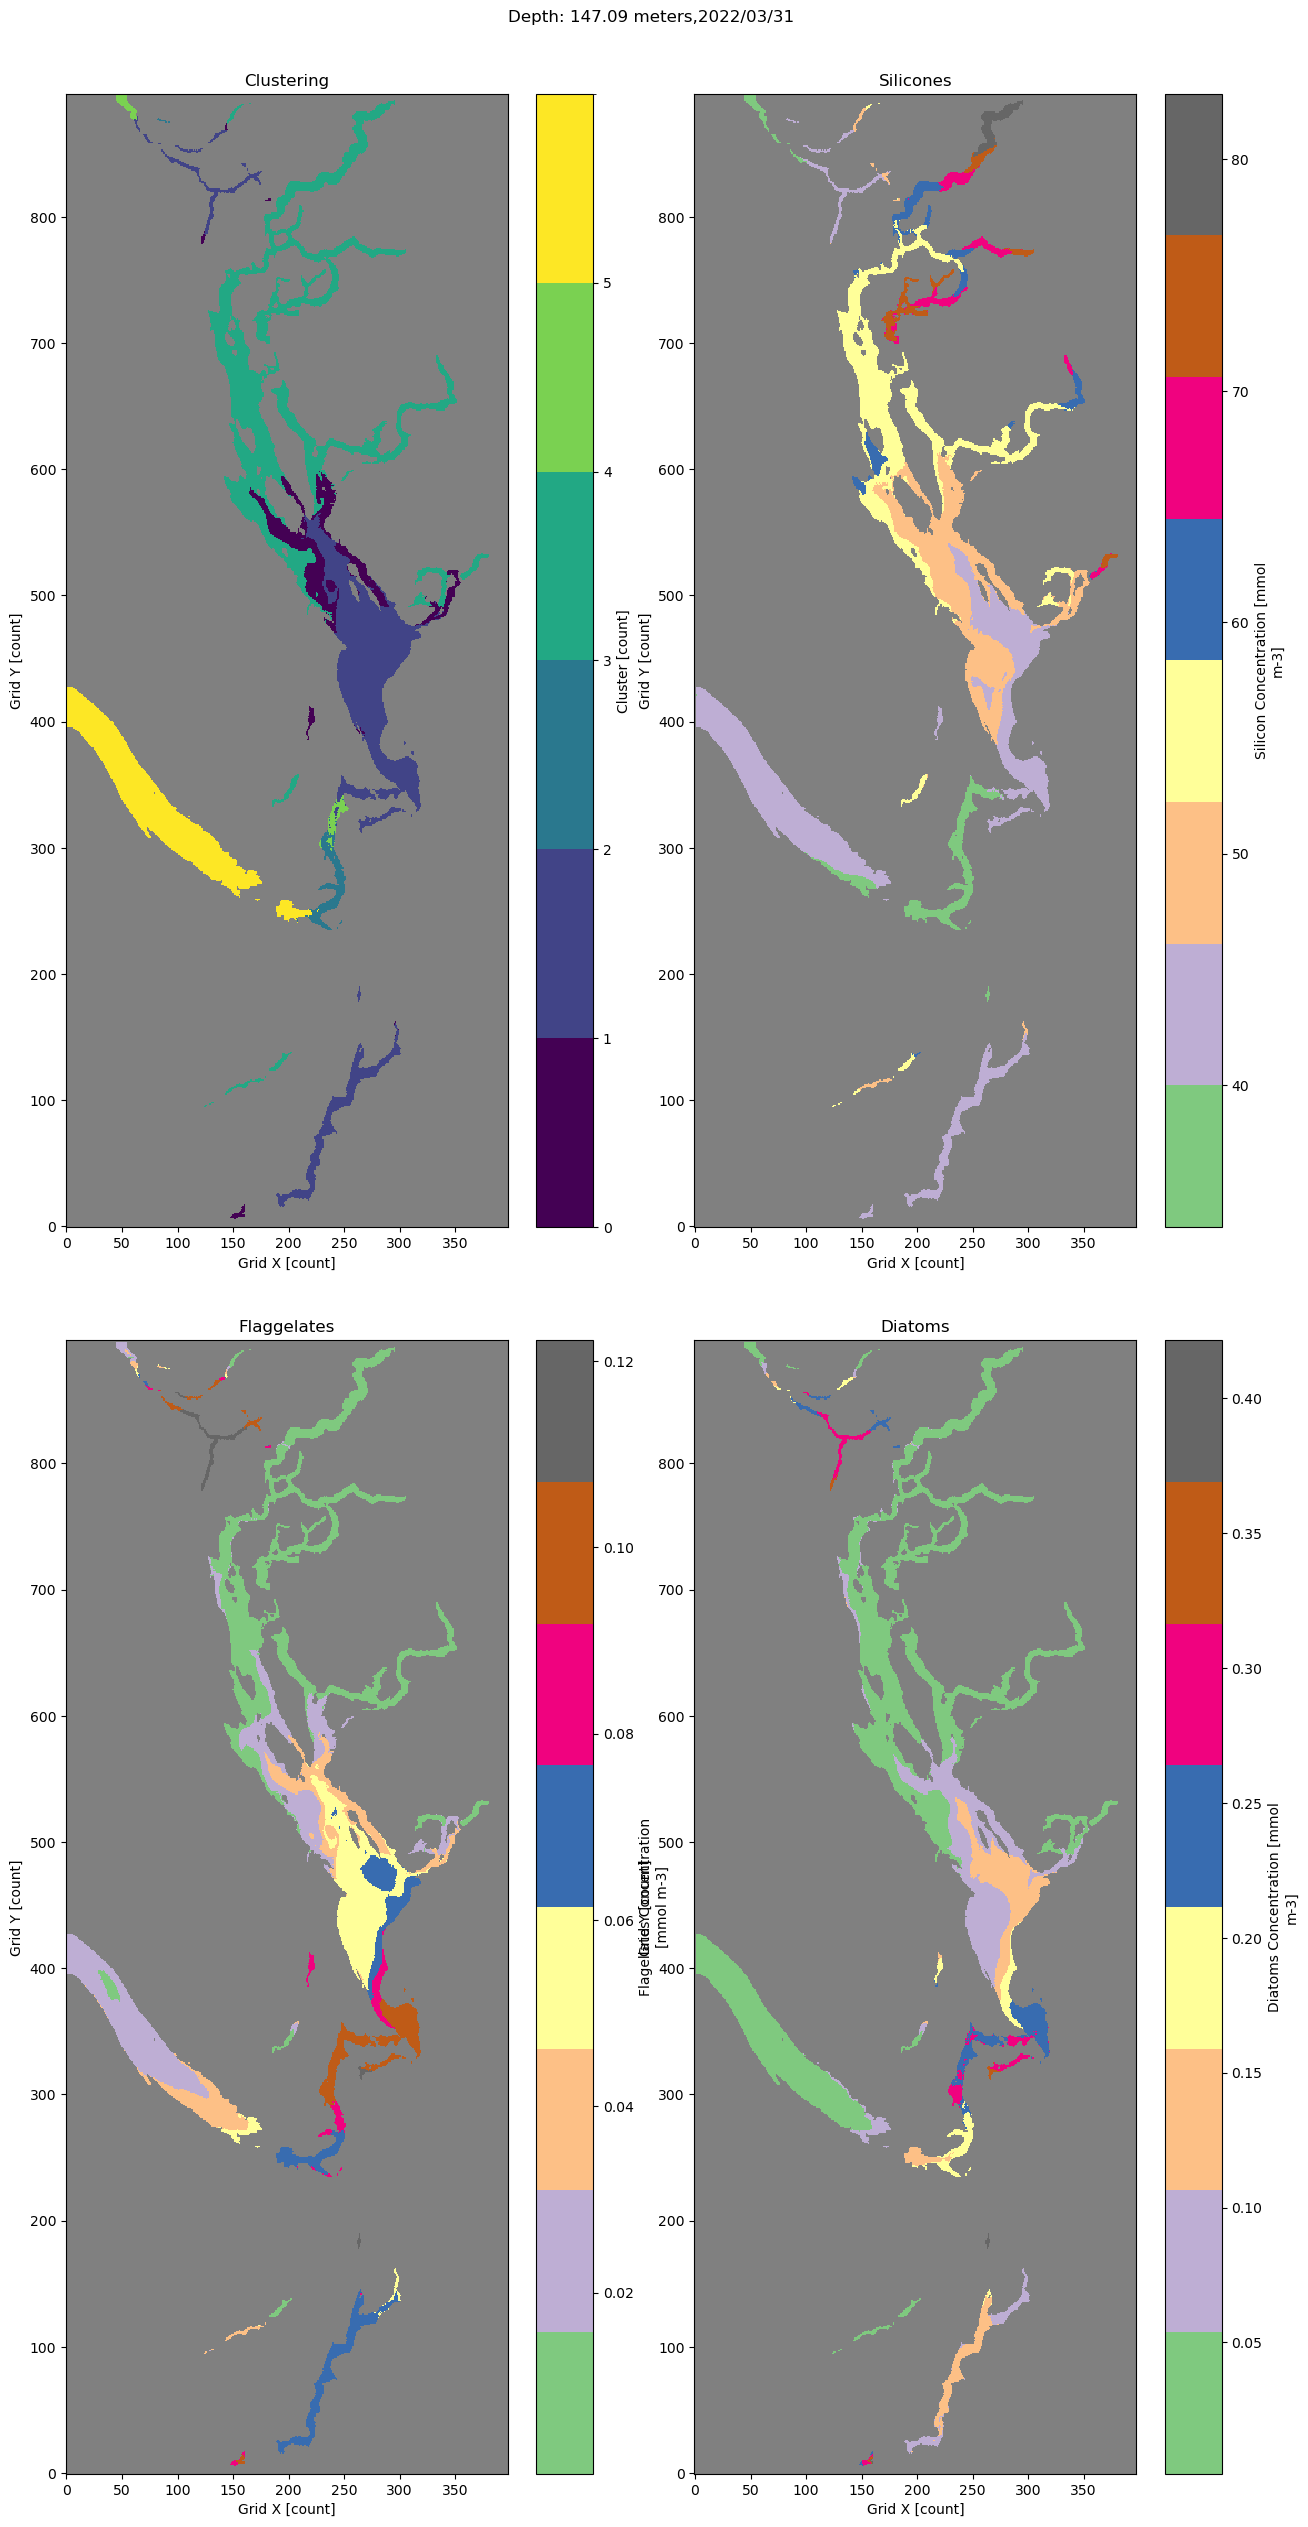

The amount of grid boxes for cluster 0 is 2043 

The minimum temperature for cluster 0 is 8.46 degrees Celsius
The maximum temperature for cluster 0 is 8.91 degrees Celsius
The mean temperature for cluster 0 is 8.7 degrees Celsius 

The minimum salinity for cluster 0 is 28.23 g/kg
The maximum salinity for cluster 0 is 30.78 g/kg
The mean salinity for cluster 0 is 30.62 g/kg 


The amount of grid boxes for cluster 1 is 8835 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 8.47 degrees Celsius
The mean temperature for cluster 1 is 8.02 degrees Celsius 

The minimum salinity for cluster 1 is 29.11 g/kg
The maximum salinity for cluster 1 is 30.91 g/kg
The mean salinity for cluster 1 is 30.43 g/kg 


The amount of grid boxes for cluster 2 is 798 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 7.68 degrees Celsius
The mean temperature for cluster 2 is 7.59 degrees Celsius 

The mi

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, sil, flag, diat)
